> Notebook com o treinamento dos modelos de ML para a classificação do label vivo_ano3.

---

1) excluir os casos de pele não melanoma (CID-O CID44 com as morfologias entre 80101 e 81103); ok

2) não utilizar as datas de recidiva (na ficha de seguimento há sobreposição); ok

3) a variável Cidade de residência (transformada em  RRAS - Rede Regional de Atenção à Saúde) relacionada com RRAS de atendimento (o valor 99 é ignorado);

4) Na questão de predição do óbito, sugiro que o comportamento 1 e 2 não sejam interessantes para a análise. Ao se observar a coluna MORFO o último dígito 1, 2 ou 3 faz referencia ao comportamento do tumor, por exemplo, 80503 = ductal invasivo. Os últimos dígitos 1 são incerto se benigno ou limítrofe e 2 carcinoma in situ.
Minha sugestão é gerar uma variável chamada comportamento e deixar só o comportamento 3 para certas análises; ok

5) trabalhar com o ano do diagnóstico agrupado é uma boa opção. O câncer não sofre mudanças abruptas ao longo do tempo e controlar por períodos de diagnóstico pode ser mais vantajoso (2000 - 2004; 2005 - 2009; 2010 - 2015). ok

6) não me recordo se os estadiamentos X e Y foram retirados, mas não devem ser trabalhados; ok

7) EC e ECGRUP dizem quase a mesma coisa. Talvez verificar o melhor preditor e usar para o modelo; ok

8) quanto a variável metástase e recidiva a distancia, deveriam estar preenchidas de forma homogênea, assim sugiro usar as informações de recidiva à distância;

9) o tempo entre o diagnóstico e o tratamento ou consulta e o tratamento devem ser recalculados (foi refeito, eu me recordo) e retirados das análise aqueles que não tiveram a possibilidade de serem tratados; ok

10) nesta base, a última coluna está preenchida com as habilitações para o tratamento CACON e UNACON. ok

# **Libraries**

Import of all libraries used in the project. 

In [ ]:
%%capture 

!pip install shap
# !pip install optuna

In [ ]:
seed = 10 # seed for the random state

# Basics
import pandas as pd
import numpy as np
import plotly.express as px

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# import optuna
# from optuna.samplers import RandomSampler
# from optuna.visualization import plot_optimization_history

# **Functions**

Here we have some functions used in the project, the ones for general use are for creating new columns in the data and reading and saving datasets. The functions for the models contain the preprocessing, division into training and test data, validation of the regressions and plot of the graph with the features importances.

In [ ]:
%%capture

!pip install --upgrade --no-cache-dir gdown
!gdown 1qUBLwQCloswnpRe4o2DLx0ewVzVx_6Pr

In [ ]:
from functions import *

# **Introduction**

In this section, two machine learning models will be used to classify the `vivo_ano3` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 1 if the patient is alive after three years of treatment and 0 if not.

The first approach is using the "raw data", the second is without the `EC` column, the third one is without `EC` and `HORMONIO`, the fourth is using the grouped years and without the column `EC` and the fifth is also with the years gruped and without `EC` and `HORMONIO`.

The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the columns `DTRECIDIVA`, `delta_t4`, `delta_t5` and `delta_t6` will not be used in this approach.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/geral_sp_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/geral_fora_sp_labels.csv')

(506037, 77)
(32891, 77)


Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
ULTIDIAG        0.746404
ULTICONS        0.740191
ULTITRAT        0.737903
vivo_ano5       0.688613
vivo_ano1       0.550659
obito_cancer    0.403906
obito_geral     0.365068
HORMONIO        0.236603
CIRURGIA        0.215579
MORFO           0.208184
ANODIAG         0.201279
ULTINFO         0.189965
QUIMIO          0.116880
G               0.103949
CLINICA         0.100960
DIAGTRAT        0.093799
SEXO            0.067311
TRATCONS        0.058532
CATEATEND       0.055419
Name: vivo_ano3, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
ULTIDIAG        0.759271
ULTICONS        0.753968
ULTITRAT        0.749534
vivo_ano5       0.667262
vivo_ano1       0.547481
obito_cancer    0.399038
obito_geral     0.385518
ANODIAG         0.258962
CIRURGIA        0.235109
ULTINFO         0.218422
HORMONIO        0.215508
MORFO           0.186335
CATEATEND       0.139831
QUIMIO          0.120061
TRATCONS        0.116820
DIAGTRAT        0.113094
RECLOCAL        0.060846
RECNENHUM       0.059315
SEXO            0.059252
Name: vivo_ano3, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification.

In [ ]:
df_SP.vivo_ano3.value_counts()

0    260942
1    245095
Name: vivo_ano3, dtype: int64

In [ ]:
df_fora.vivo_ano3.value_counts()

0    17264
1    15627
Name: vivo_ano3, dtype: int64

Years of diagnosis present in the data.

In [ ]:
np.sort(df_SP.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [ ]:
np.sort(df_fora.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

In [ ]:
# SP
df_SP_ano3 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 77)

In [ ]:
# Other States
df_fora_ano3 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 77)

# **First approach**

Approach with "raw data".

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano5', 'ULTINFO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (306886, 66), X_test = (102296, 66)
y_train = (306886,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (18960, 66), X_test = (6320, 66)
y_train = (18960,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1.557, 1:1}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1.557, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

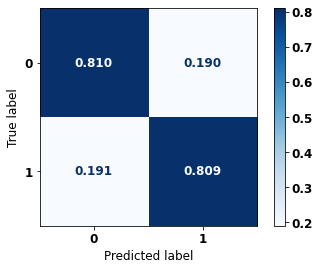


              precision    recall  f1-score   support

           0      0.740     0.810     0.773     41022
           1      0.864     0.809     0.836     61274

    accuracy                          0.809    102296
   macro avg      0.802     0.809     0.804    102296
weighted avg      0.814     0.809     0.811    102296



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


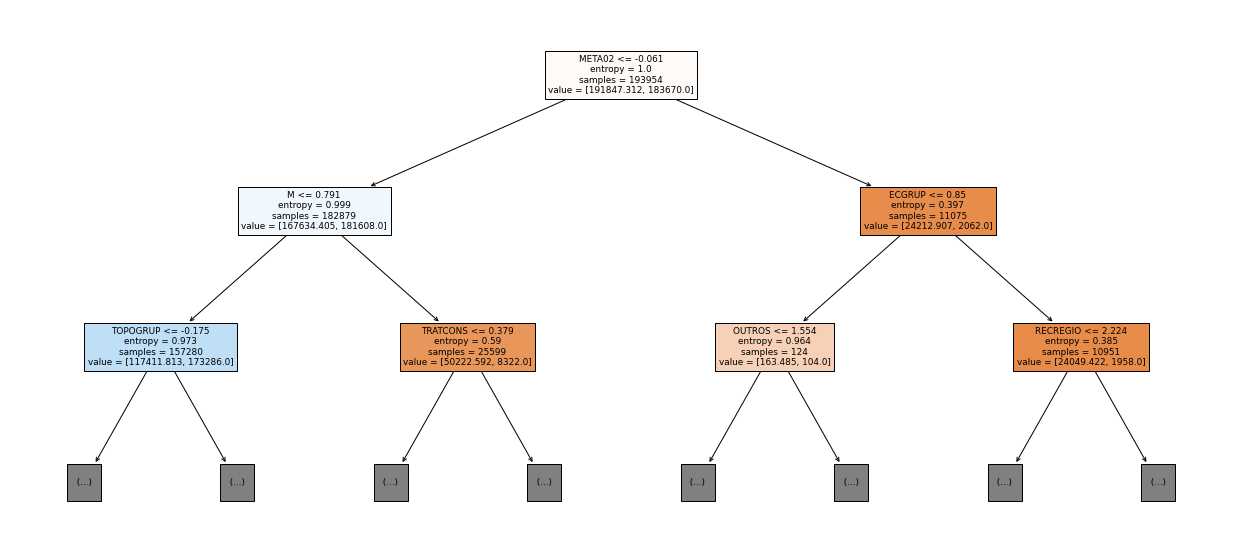

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

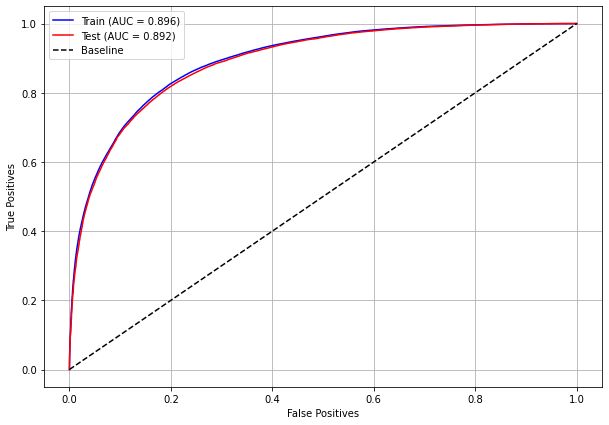

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

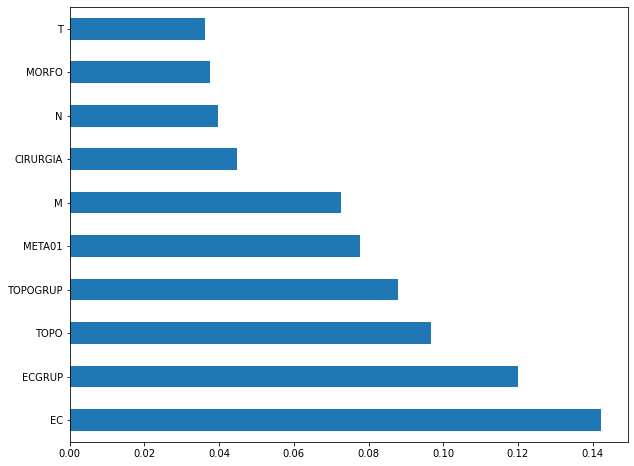

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `EC`, `ECGRUP`, `TOPO` and `TOPOGRUP`.

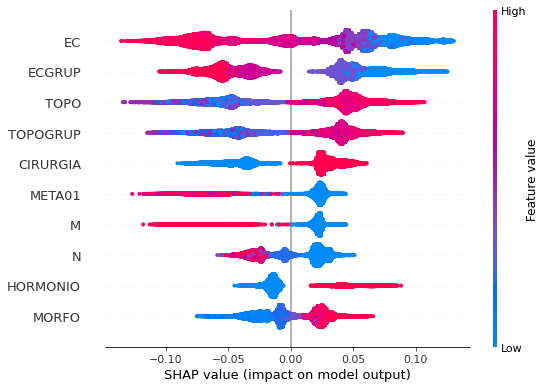

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.6, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.6, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

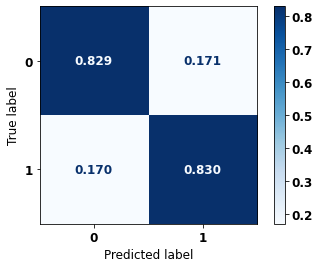


              precision    recall  f1-score   support

           0      0.750     0.829     0.788      2413
           1      0.887     0.830     0.857      3907

    accuracy                          0.829      6320
   macro avg      0.819     0.829     0.823      6320
weighted avg      0.835     0.829     0.831      6320



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


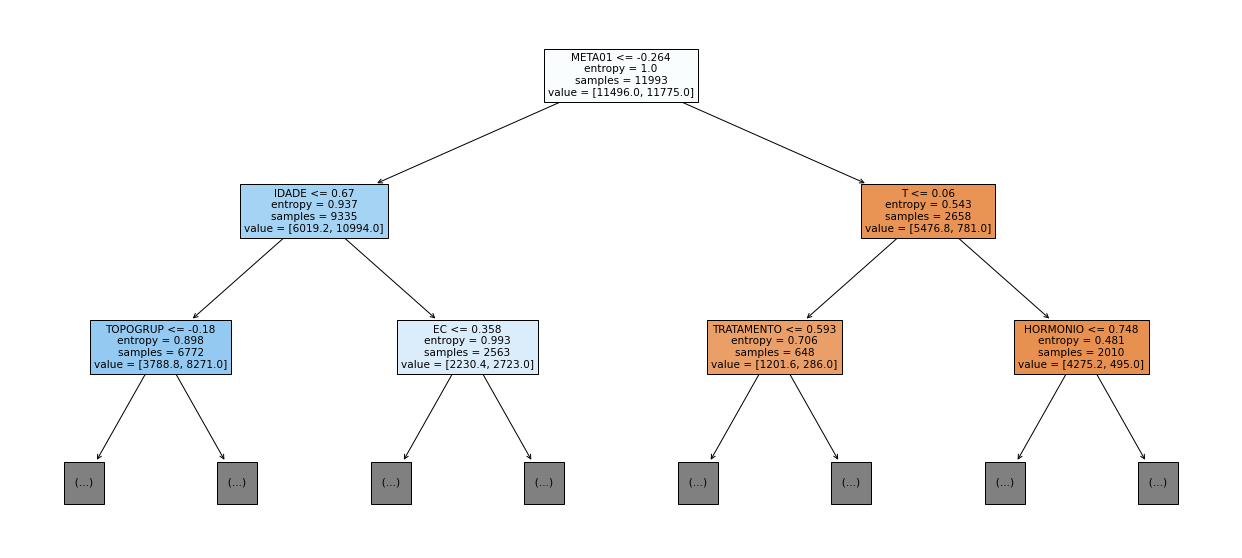

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

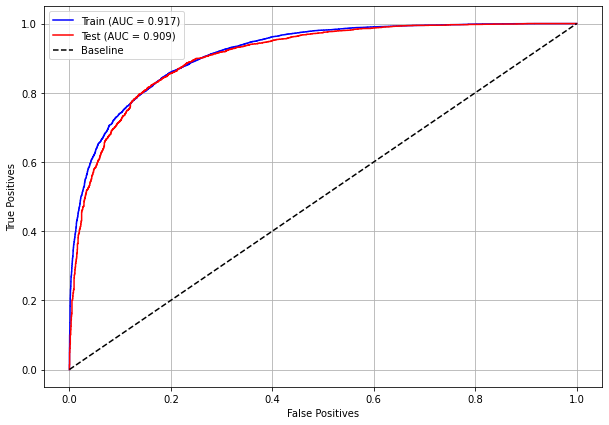

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

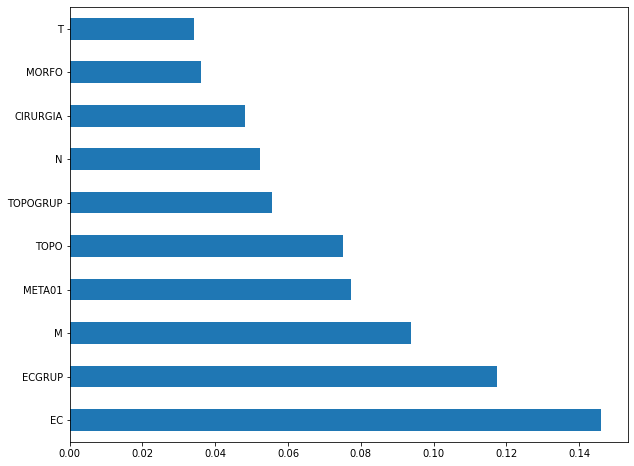

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `ECGRUP`, `M` and `META01`.

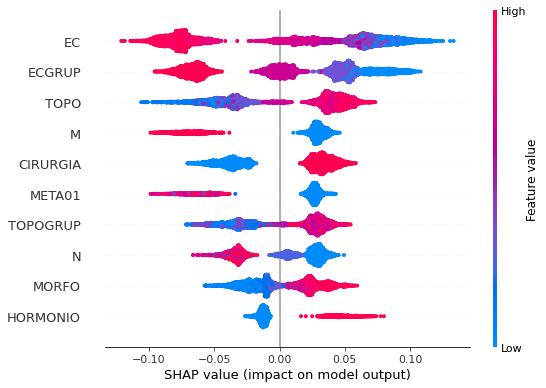

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperRF = {'n_estimators': [100, 150, 200, 250],
           'max_depth': [5, 8, 10, 12, 15],
           'min_samples_split': [2, 5, 10, 15],
           'min_samples_leaf': [1, 2, 5, 10]} 

rf = RandomForestClassifier(random_state=seed, criterion='entropy')

randRS = RandomizedSearchCV(rf, hyperRF, n_iter=20, cv=5, n_jobs=-1, 
                            random_state=seed)

In [ ]:
# SP
bestSP = randRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# SP
rf_sp_opt = bestSP.best_estimator_
rf_sp_opt.set_params(class_weight={0:1.61, 1:1})

rf_sp_opt.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1.61, 1: 1}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

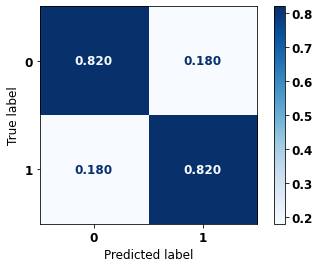


              precision    recall  f1-score   support

           0      0.753     0.820     0.785     41022
           1      0.872     0.820     0.845     61274

    accuracy                          0.820    102296
   macro avg      0.813     0.820     0.815    102296
weighted avg      0.824     0.820     0.821    102296



In [ ]:
display_confusion_matrix(rf_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = randRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# Other states
rf_fora_opt = bestOS.best_estimator_
rf_fora_opt.set_params(class_weight={0:2.06, 1:1})

rf_fora_opt.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 2.06, 1: 1}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

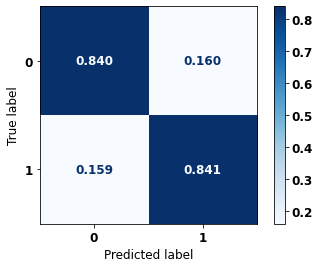


              precision    recall  f1-score   support

           0      0.765     0.840     0.801      2413
           1      0.895     0.841     0.867      3907

    accuracy                          0.840      6320
   macro avg      0.830     0.840     0.834      6320
weighted avg      0.845     0.840     0.842      6320



In [ ]:
display_confusion_matrix(rf_fora_opt, X_test_OS, y_test_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                               scale_pos_weight=0.651,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.651)

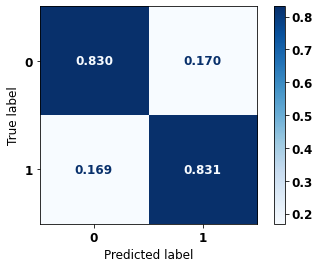


              precision    recall  f1-score   support

           0      0.767     0.830     0.798     41022
           1      0.880     0.831     0.855     61274

    accuracy                          0.831    102296
   macro avg      0.824     0.831     0.826    102296
weighted avg      0.835     0.831     0.832    102296



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 83% of accuracy.


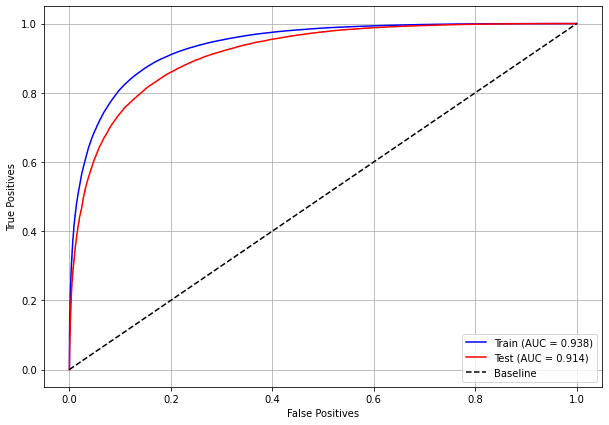

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

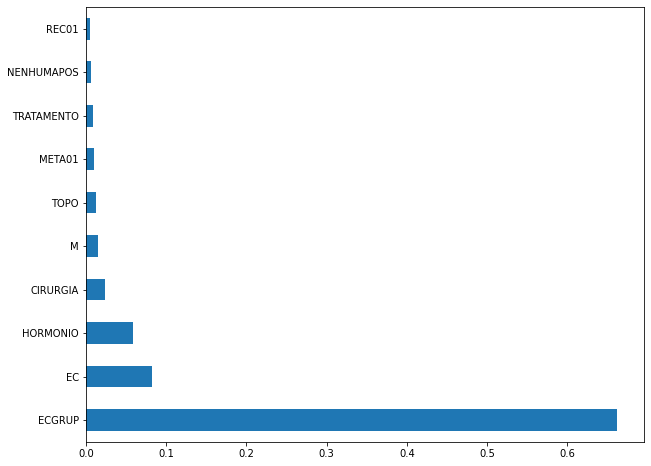

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `EC`, `HORMONIO` and `CIRURGIA`.

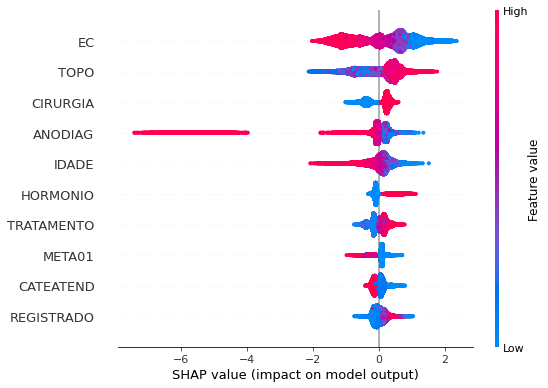

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=8, 
                             scale_pos_weight=0.55,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.55)

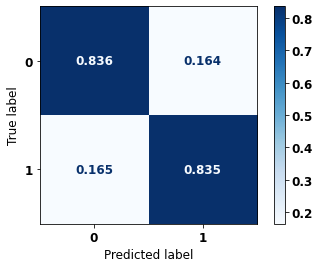


              precision    recall  f1-score   support

           0      0.758     0.836     0.795      2413
           1      0.892     0.835     0.863      3907

    accuracy                          0.836      6320
   macro avg      0.825     0.836     0.829      6320
weighted avg      0.841     0.836     0.837      6320



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


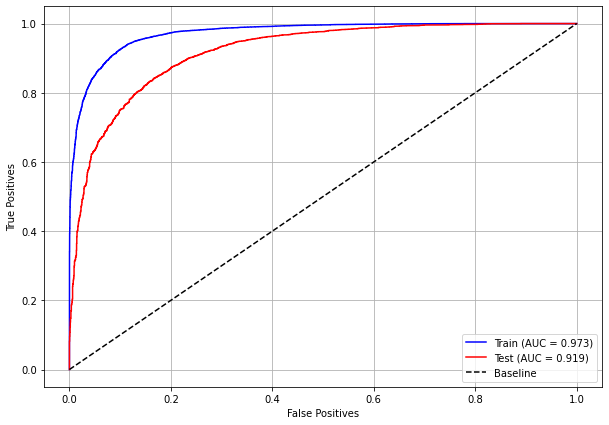

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

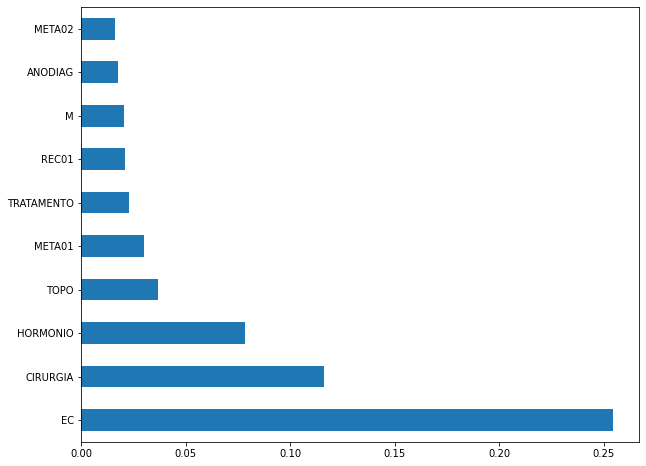

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `CIRURGIA`, `HORMONIO` and `TOPO`.

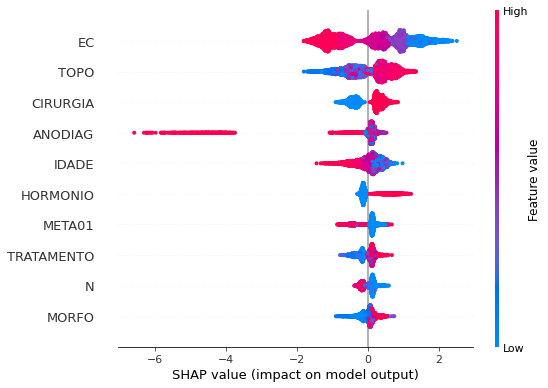

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
            'max_depth': [5, 8, 10, 12, 15],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
            'n_estimators': [100, 150, 200, 250]}

xgboost = XGBClassifier(random_state=seed)
xgbRS = RandomizedSearchCV(xgboost, hyperXGB, n_iter=20, cv=5, n_jobs=-1, 
                           random_state=seed)

In [ ]:
# SP
bestSP = xgbRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 250,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.15,
 'gamma': 0.3,
 'colsample_bytree': 0.4}

In [ ]:
# SP
xgb_sp_opt = bestSP.best_estimator_
xgb_sp_opt.set_params(scale_pos_weight=0.62)

xgb_sp_opt.fit(X_train_SP, y_train_SP)

XGBClassifier(colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=10,
              min_child_weight=5, n_estimators=250, random_state=10,
              scale_pos_weight=0.62)

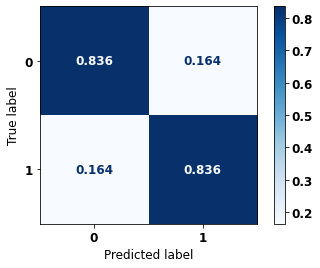


              precision    recall  f1-score   support

           0      0.773     0.836     0.804     41022
           1      0.884     0.836     0.859     61274

    accuracy                          0.836    102296
   macro avg      0.829     0.836     0.831    102296
weighted avg      0.840     0.836     0.837    102296



In [ ]:
display_confusion_matrix(xgb_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = xgbRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 150,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [ ]:
# Other states
xgb_fora_opt = bestOS.best_estimator_
xgb_fora_opt.set_params(scale_pos_weight=0.61)

xgb_fora_opt.fit(X_train_OS, y_train_OS)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8,
              min_child_weight=7, n_estimators=150, random_state=10,
              scale_pos_weight=0.61)

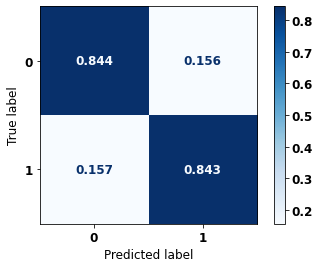


              precision    recall  f1-score   support

           0      0.768     0.844     0.804      2413
           1      0.897     0.843     0.869      3907

    accuracy                          0.843      6320
   macro avg      0.833     0.843     0.837      6320
weighted avg      0.848     0.843     0.844      6320



In [ ]:
display_confusion_matrix(xgb_fora_opt, X_test_OS, y_test_OS)

# **Second approach**

Approach without column `EC` as a feature.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano5',
             'ULTINFO', 'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (306886, 65), X_test = (102296, 65)
y_train = (306886,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (18960, 65), X_test = (6320, 65)
y_train = (18960,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1.548, 1:1}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1.548, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

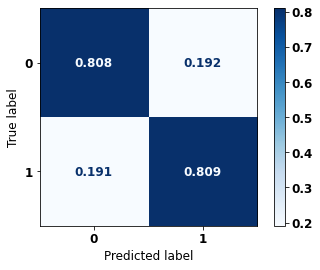


              precision    recall  f1-score   support

           0      0.739     0.808     0.772     41022
           1      0.863     0.809     0.835     61274

    accuracy                          0.809    102296
   macro avg      0.801     0.809     0.804    102296
weighted avg      0.813     0.809     0.810    102296



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


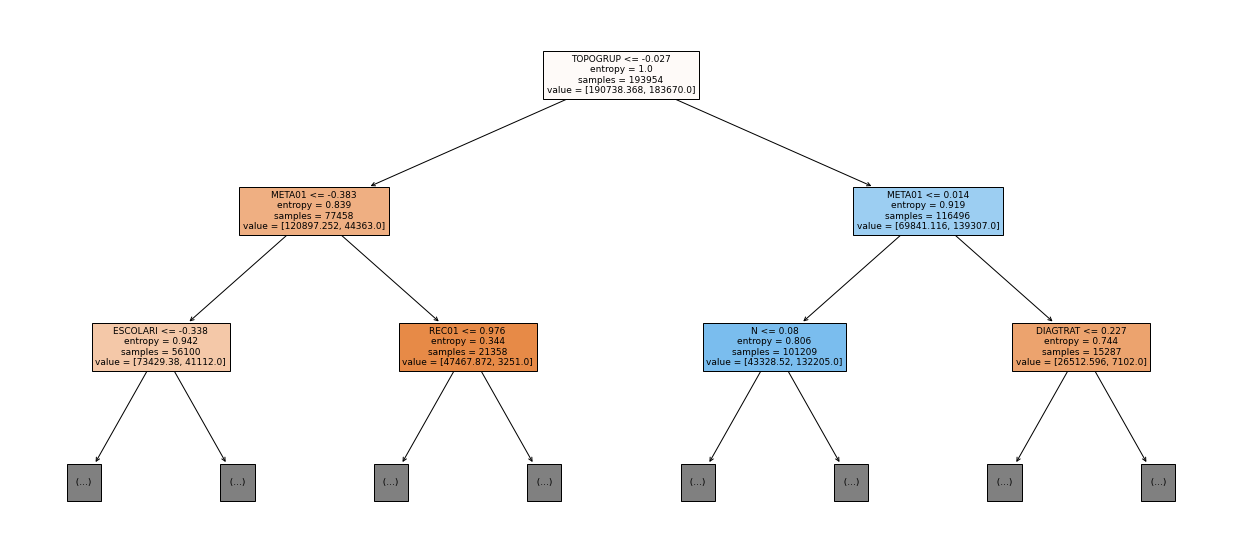

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

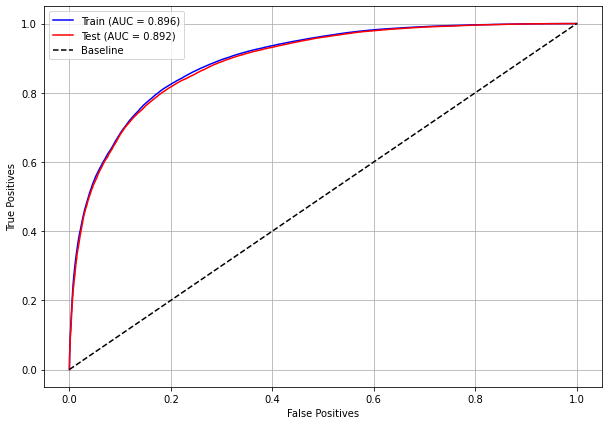

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

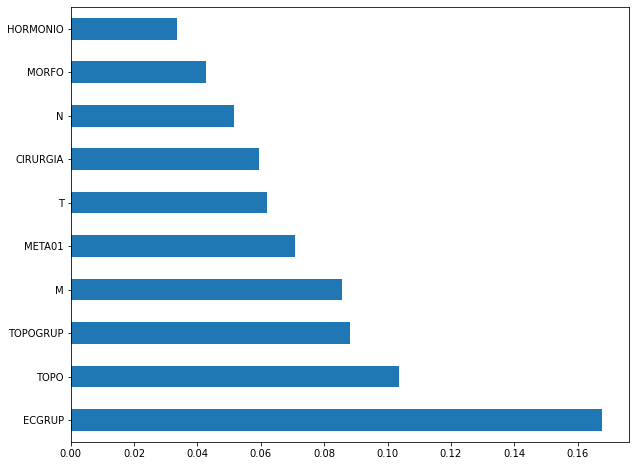

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `M`.

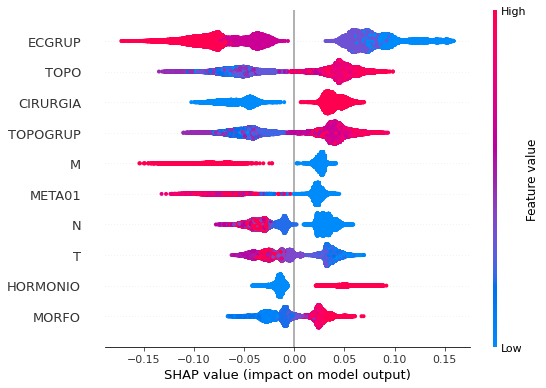

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.75, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.75, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

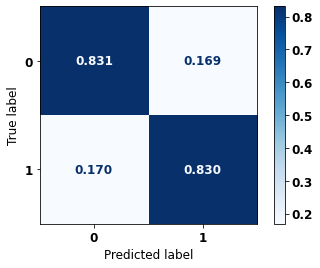


              precision    recall  f1-score   support

           0      0.751     0.831     0.789      2413
           1      0.888     0.830     0.858      3907

    accuracy                          0.830      6320
   macro avg      0.820     0.830     0.824      6320
weighted avg      0.836     0.830     0.832      6320



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


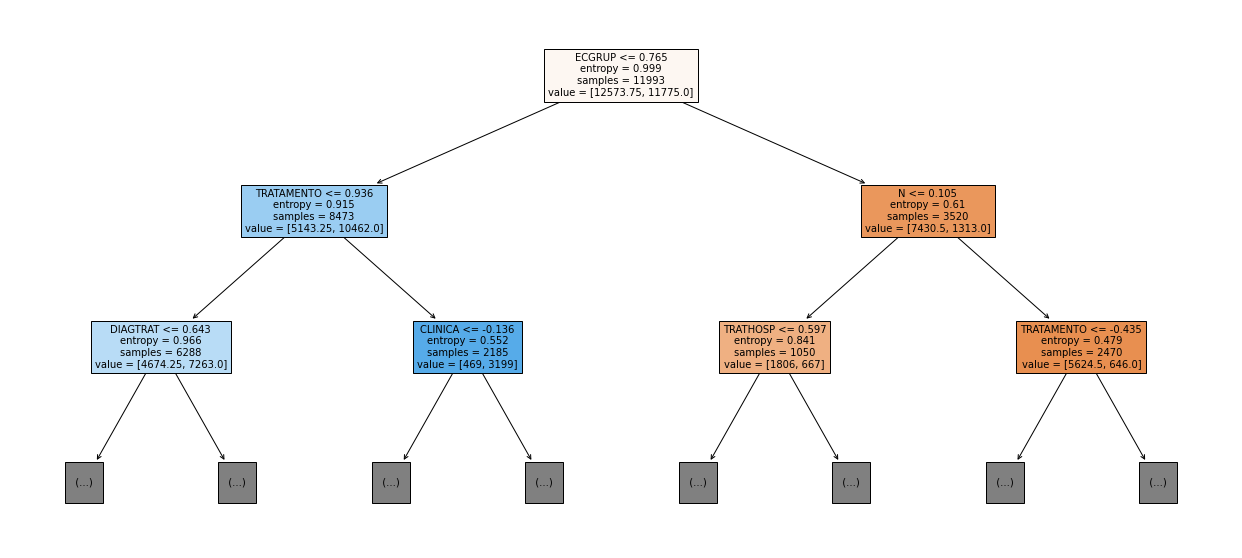

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

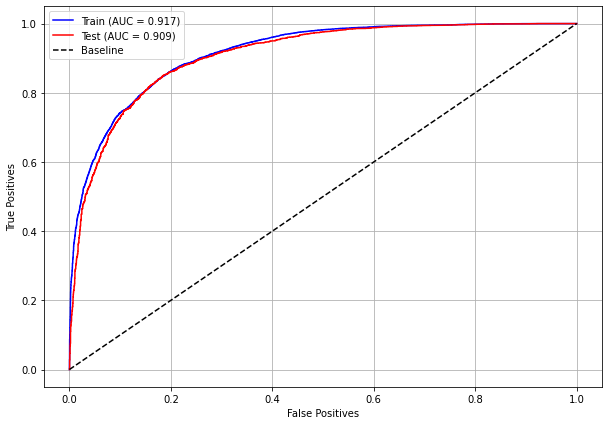

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

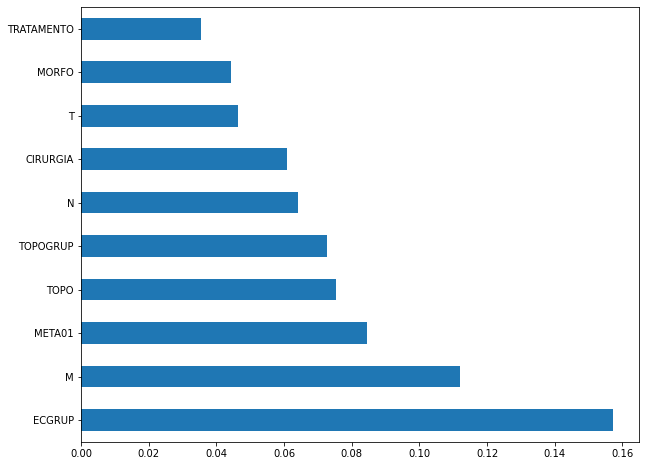

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `TOPO`.

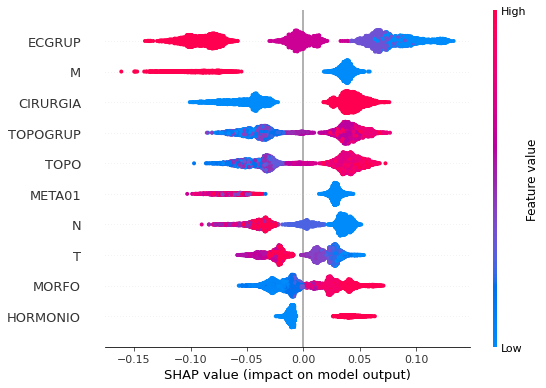

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=0.65,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.65)

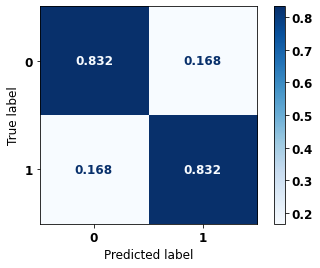


              precision    recall  f1-score   support

           0      0.768     0.832     0.799     41022
           1      0.881     0.832     0.856     61274

    accuracy                          0.832    102296
   macro avg      0.825     0.832     0.827    102296
weighted avg      0.836     0.832     0.833    102296



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 83% of accuracy.


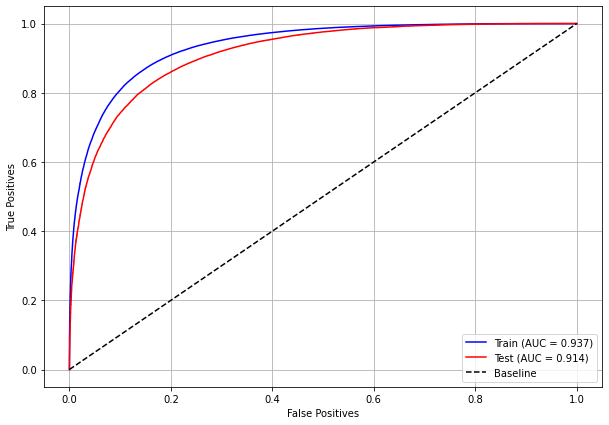

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

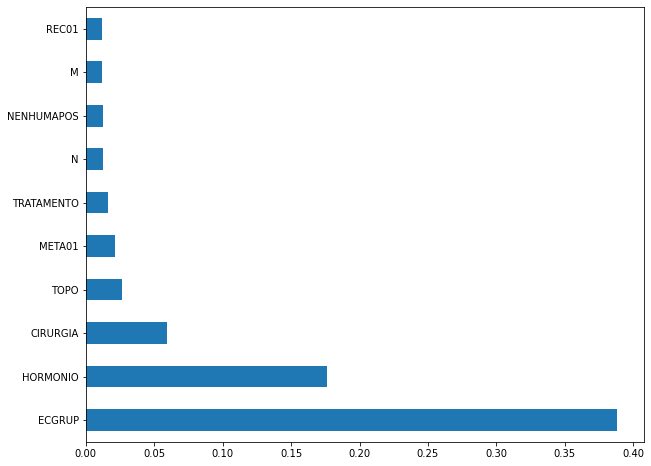

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `CIRURGIA` and `TOPO`.

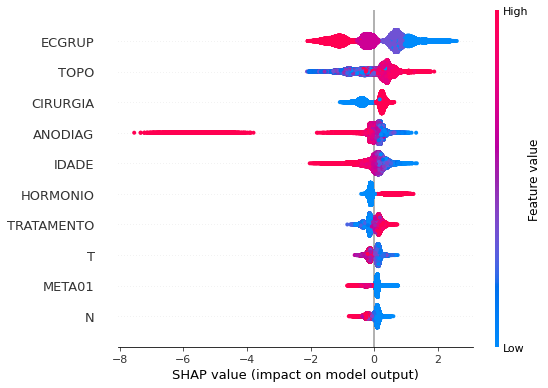

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=8, 
                             scale_pos_weight=0.56,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.56)

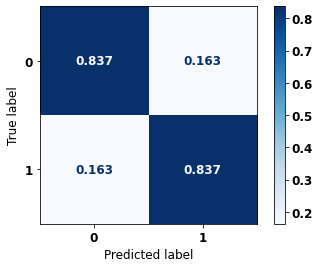


              precision    recall  f1-score   support

           0      0.760     0.837     0.797      2413
           1      0.892     0.837     0.864      3907

    accuracy                          0.837      6320
   macro avg      0.826     0.837     0.830      6320
weighted avg      0.842     0.837     0.838      6320



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


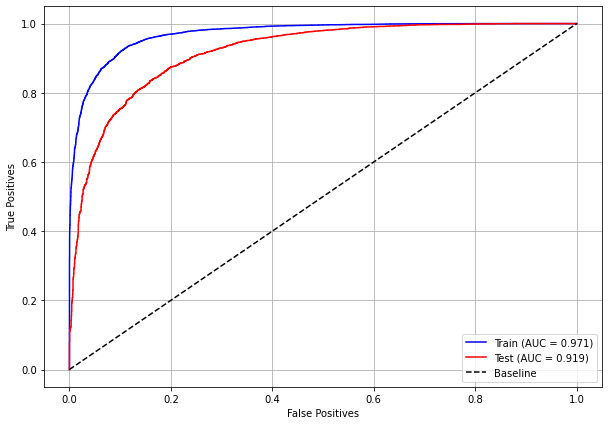

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

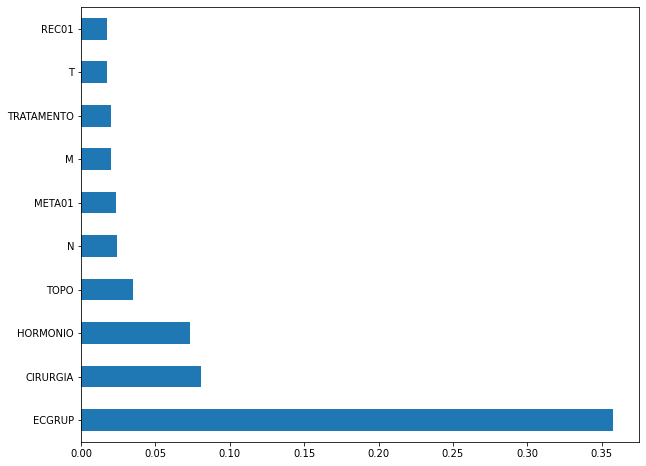

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `CIRURGIA`, `HORMONIO` and `TOPO`.

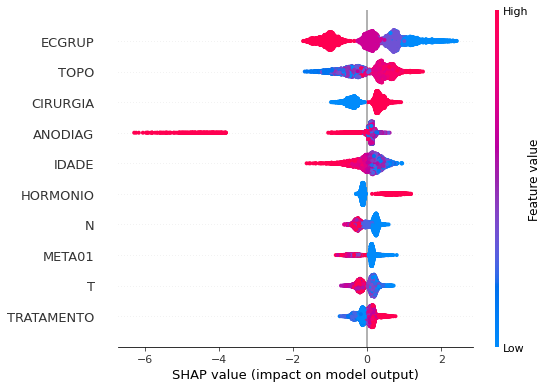

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

# **Third approach**

Approach without columns `EC` and `HORMONIO` as features.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano5', 
             'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (306886, 64), X_test = (102296, 64)
y_train = (306886,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (18960, 64), X_test = (6320, 64)
y_train = (18960,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1.56, 1:1}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1.56, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

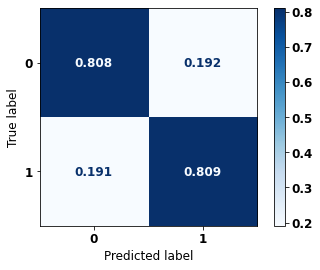


              precision    recall  f1-score   support

           0      0.739     0.808     0.772     41022
           1      0.863     0.809     0.835     61274

    accuracy                          0.809    102296
   macro avg      0.801     0.809     0.804    102296
weighted avg      0.813     0.809     0.810    102296



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


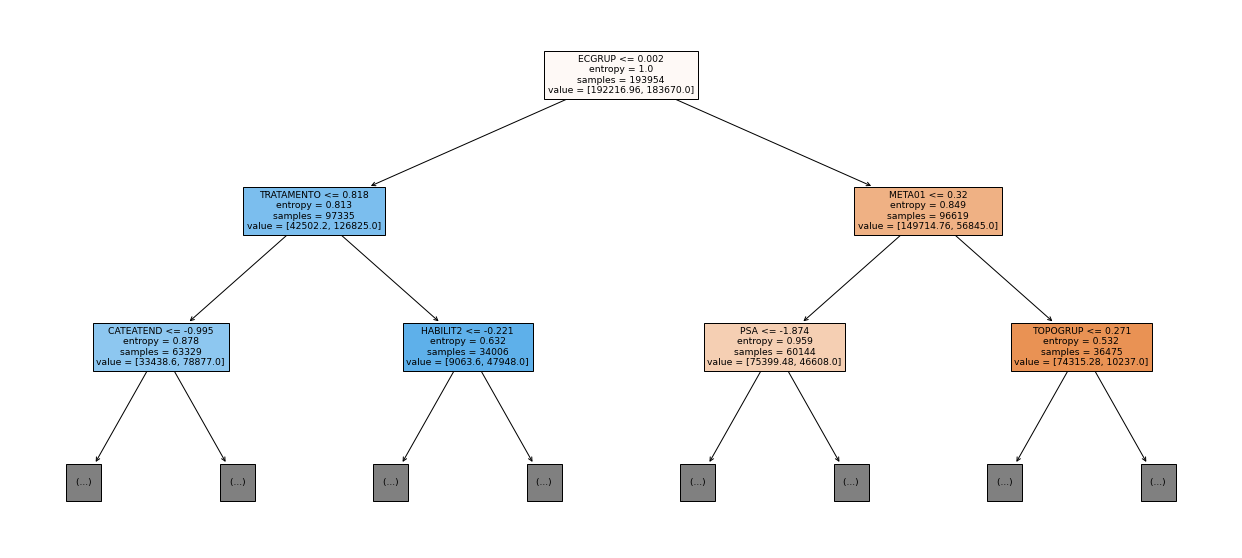

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

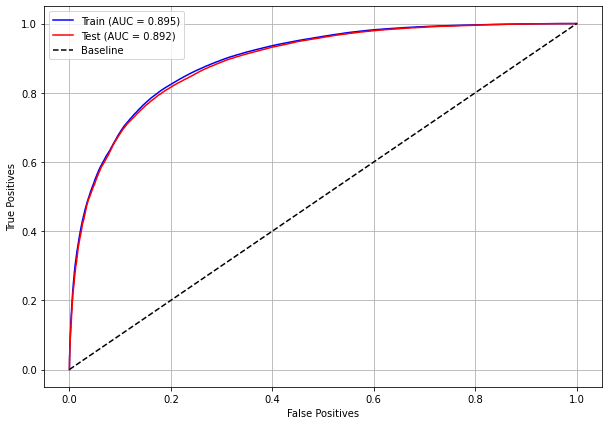

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

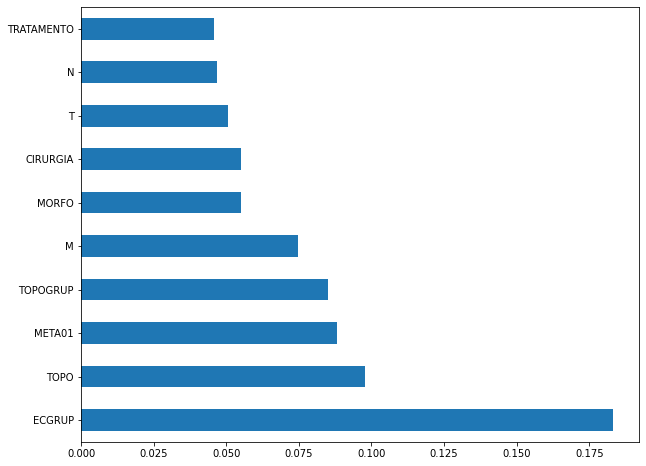

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `TOPO`, `META01` and `TOPOGRUP`.

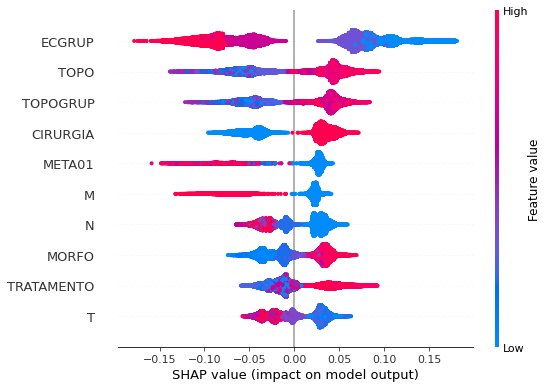

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.747, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.747, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

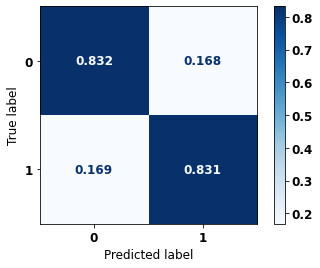


              precision    recall  f1-score   support

           0      0.753     0.832     0.790      2413
           1      0.889     0.831     0.859      3907

    accuracy                          0.831      6320
   macro avg      0.821     0.832     0.825      6320
weighted avg      0.837     0.831     0.833      6320



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


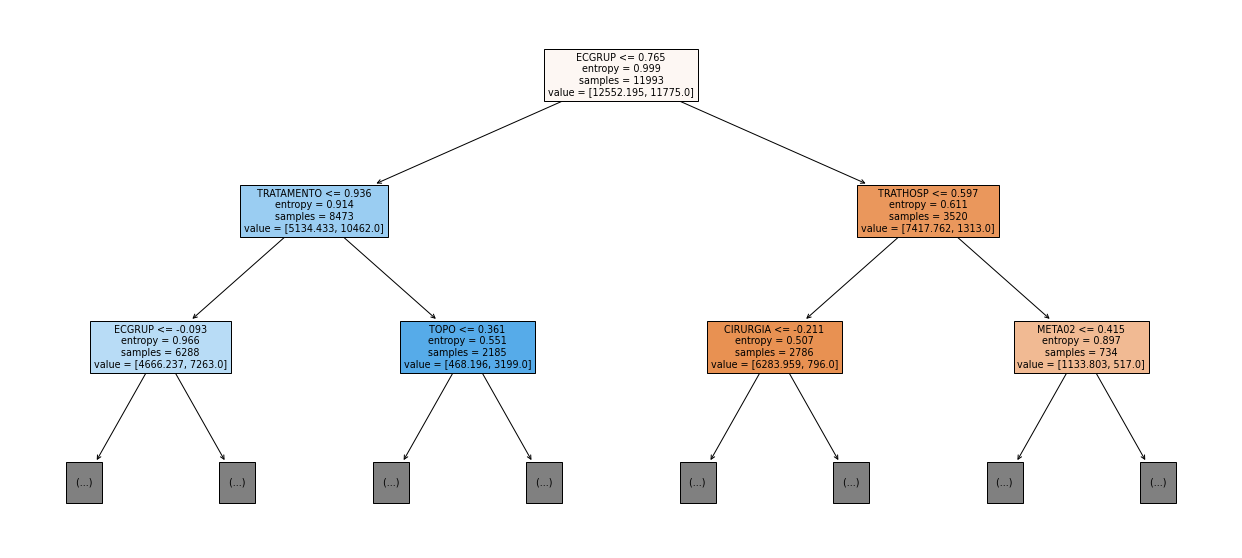

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

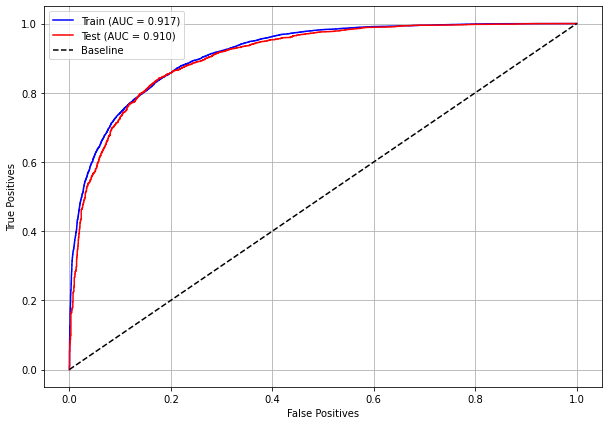

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

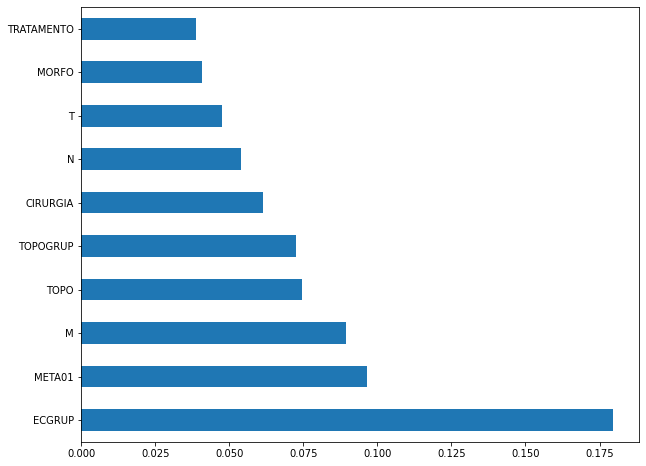

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `META01`, `M` and `TOPO`.

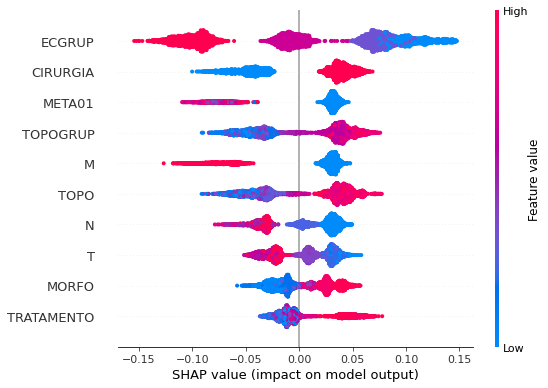

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=0.64,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.64)

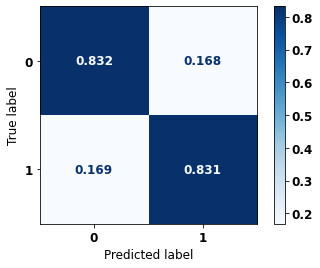


              precision    recall  f1-score   support

           0      0.767     0.832     0.798     41022
           1      0.881     0.831     0.855     61274

    accuracy                          0.831    102296
   macro avg      0.824     0.831     0.827    102296
weighted avg      0.835     0.831     0.832    102296



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 83% of accuracy.


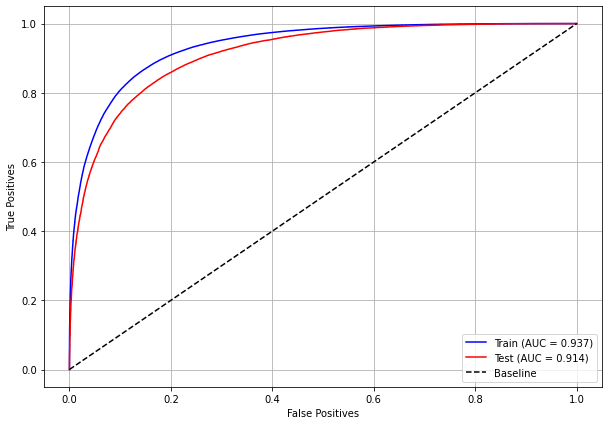

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

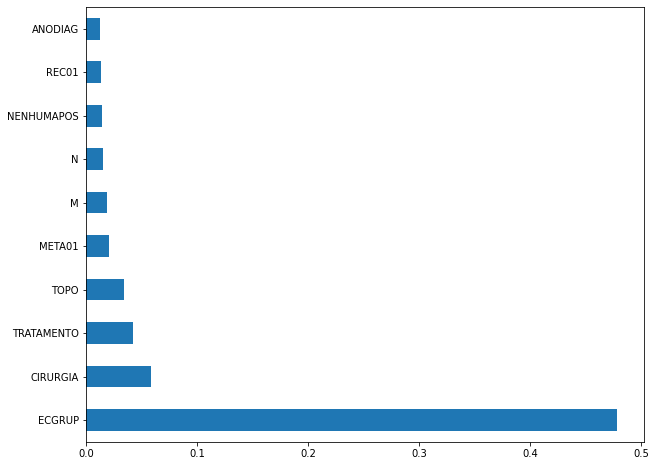

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `CIRURGIA`, `TRATAMENTO` and `TOPO`.

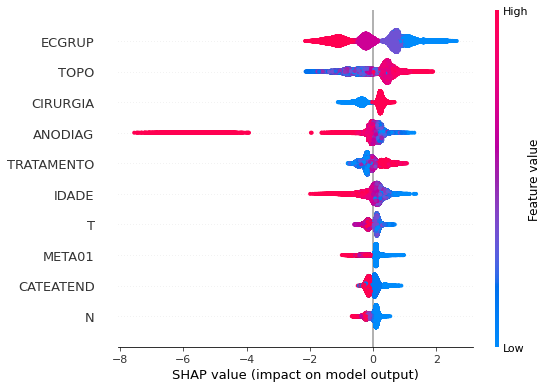

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=8, 
                             scale_pos_weight=0.555,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.555)

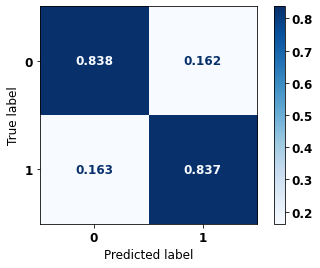


              precision    recall  f1-score   support

           0      0.760     0.838     0.797      2413
           1      0.893     0.837     0.864      3907

    accuracy                          0.837      6320
   macro avg      0.827     0.837     0.831      6320
weighted avg      0.842     0.837     0.838      6320



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


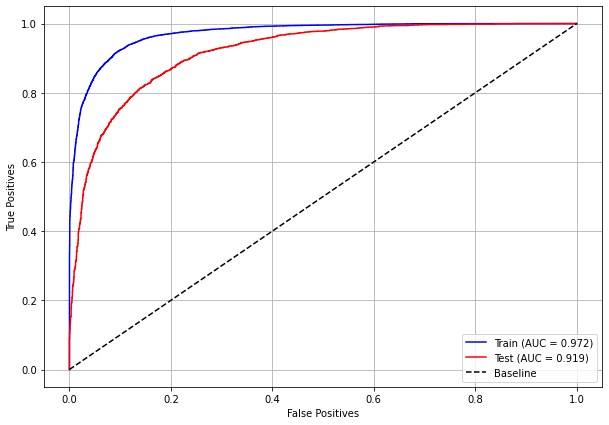

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

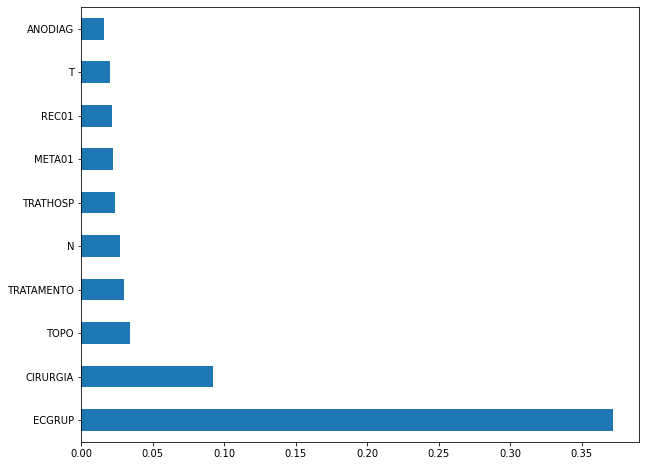

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `CIRURGIA`, `TOPO` and `TRATAMENTO`.

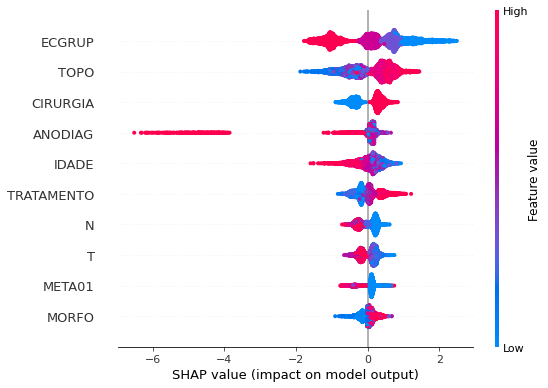

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

# **Fourth approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano5', 'ULTINFO', 
             'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (45987, 65), X_test = (15329, 65)
y_train = (45987,), y_test = (15329,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (57801, 65), X_test = (19267, 65)
y_train = (57801,), y_test = (19267,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (77655, 65), X_test = (25886, 65)
y_train = (77655,), y_test = (25886,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (89562, 65), X_test = (29854, 65)
y_train = (89562,), y_test = (29854,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2021, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (35880, 65), X_test = (11961, 65)
y_train = (35880,), y_test = (11961,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2631, 65), X_test = (877, 65)
y_train = (2631,), y_test = (877,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3652, 65), X_test = (1218, 65)
y_train = (3652,), y_test = (1218,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4387, 65), X_test = (1463, 65)
y_train = (4387,), y_test = (1463,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (5346, 65), X_test = (1782, 65)
y_train = (5346,), y_test = (1782,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2020, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2943, 65), X_test = (981, 65)
y_train = (2943,), y_test = (981,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.4, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1.4, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

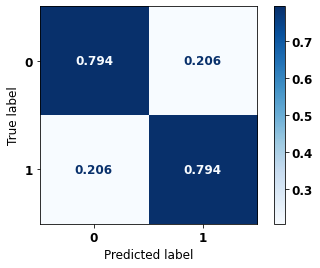


              precision    recall  f1-score   support

           0      0.738     0.794     0.765      6483
           1      0.840     0.794     0.816      8846

    accuracy                          0.794     15329
   macro avg      0.789     0.794     0.791     15329
weighted avg      0.797     0.794     0.795     15329



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


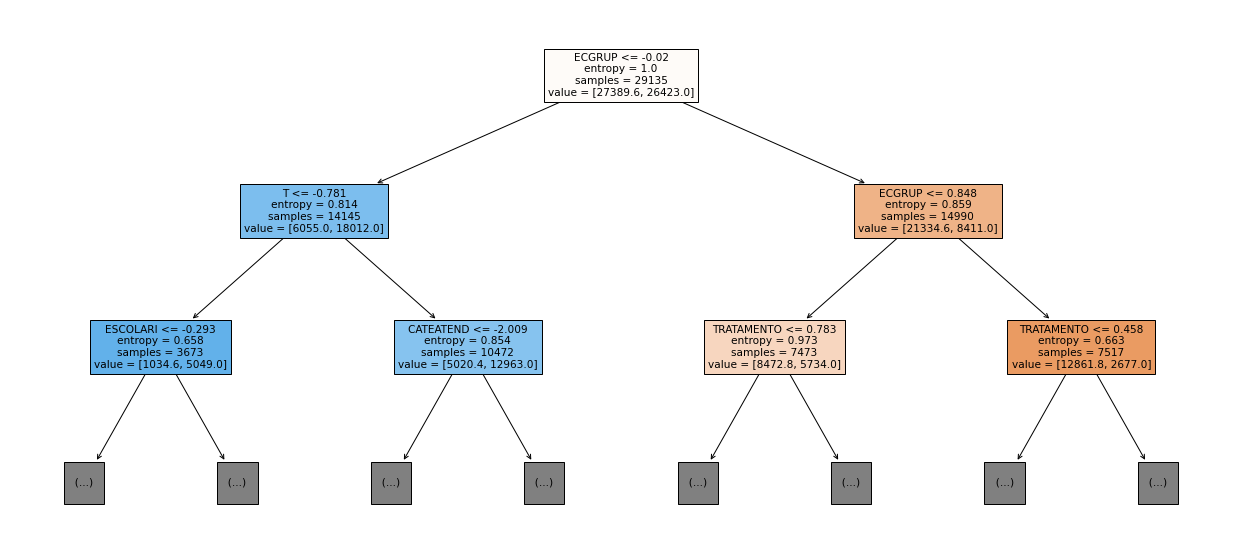

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

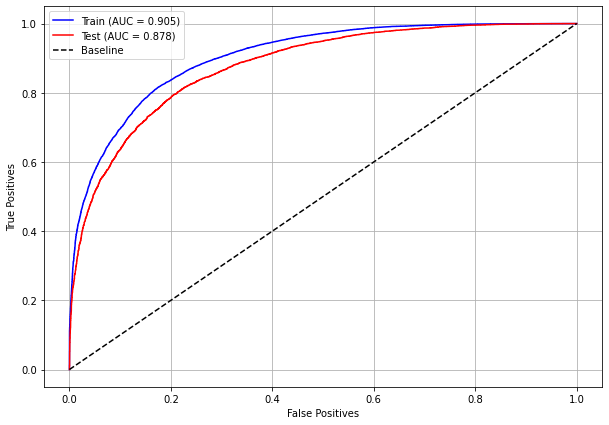

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

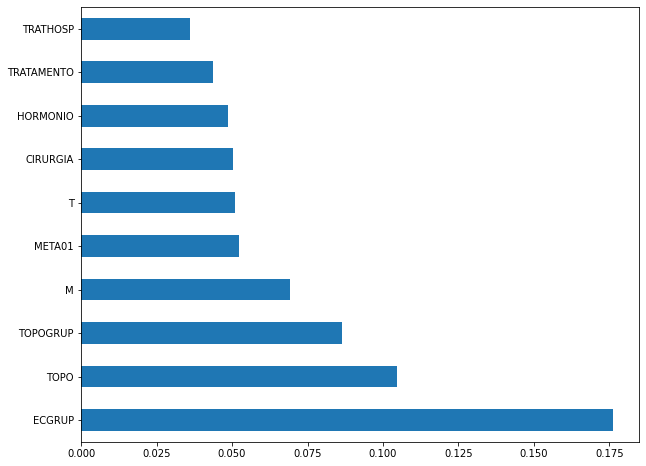

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP`, and `M`. 

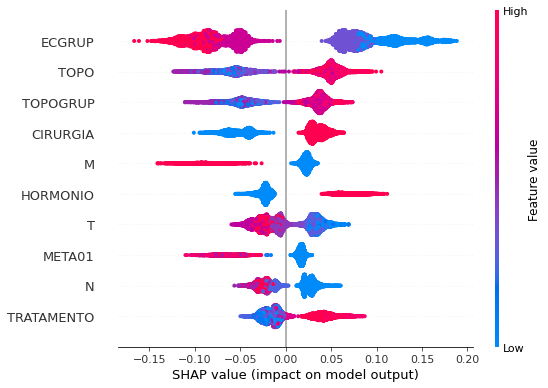

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.614, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.614, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

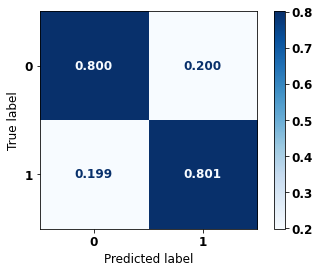


              precision    recall  f1-score   support

           0      0.722     0.800     0.759      7568
           1      0.861     0.801     0.830     11699

    accuracy                          0.801     19267
   macro avg      0.792     0.801     0.795     19267
weighted avg      0.807     0.801     0.802     19267



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.

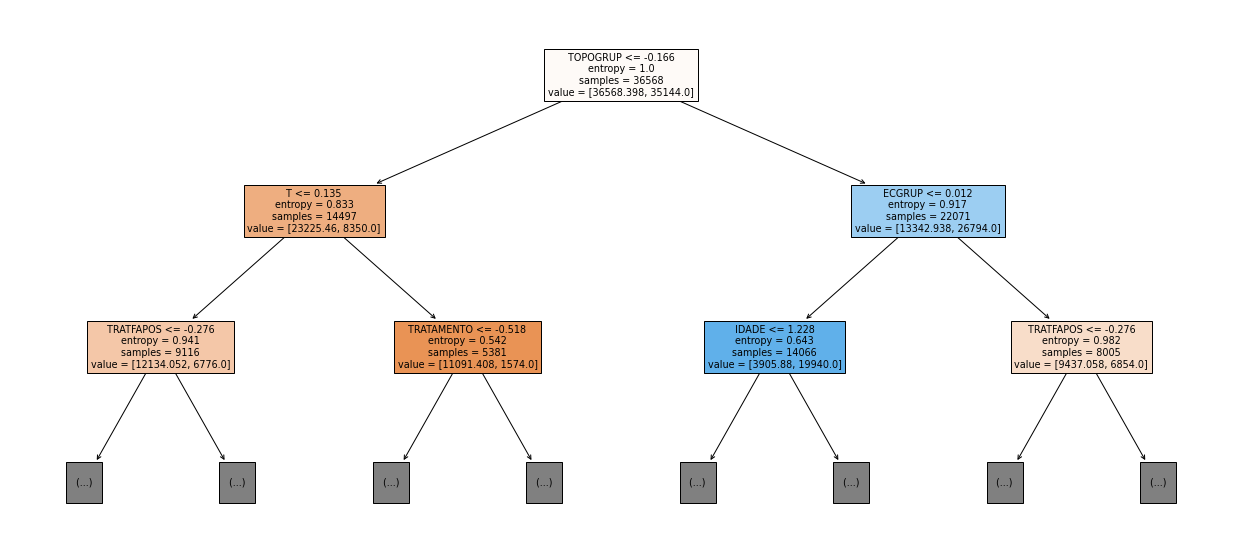

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

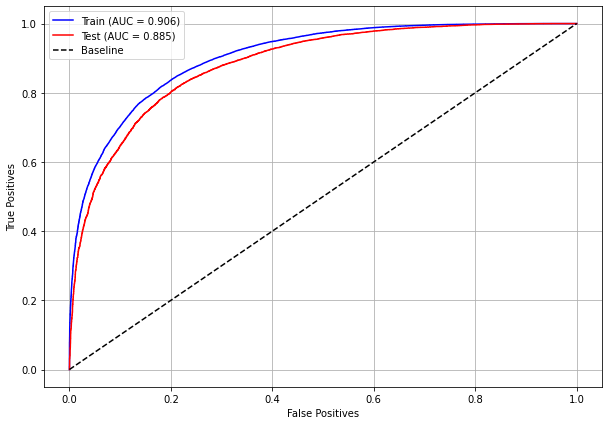

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

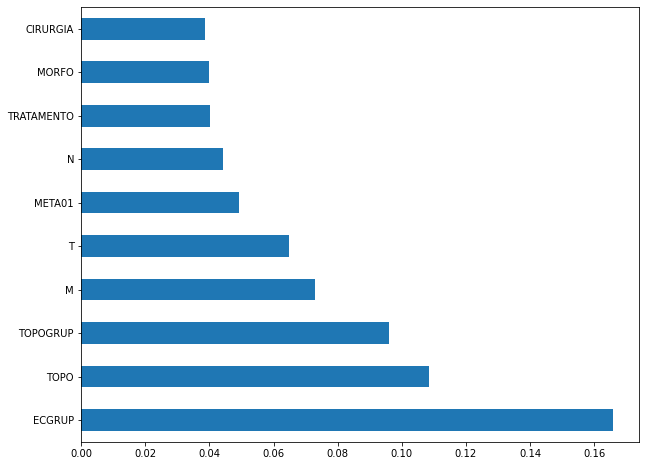

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `M`.

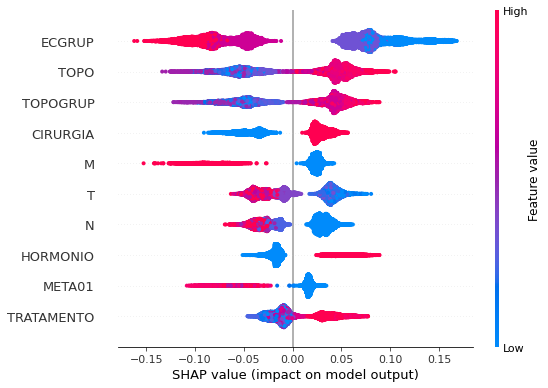

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.798, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1.798, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

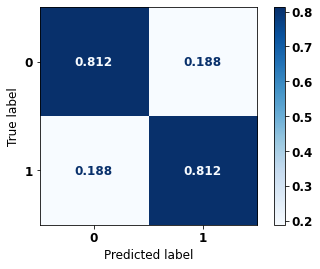


              precision    recall  f1-score   support

           0      0.719     0.812     0.763      9635
           1      0.879     0.812     0.844     16251

    accuracy                          0.812     25886
   macro avg      0.799     0.812     0.804     25886
weighted avg      0.820     0.812     0.814     25886



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuracy.

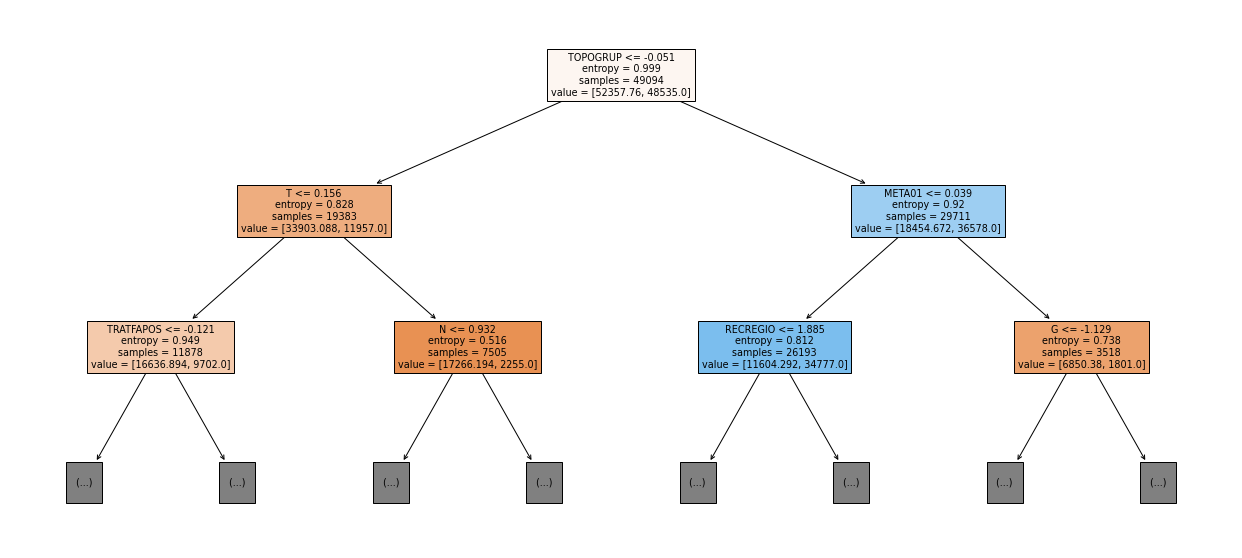

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

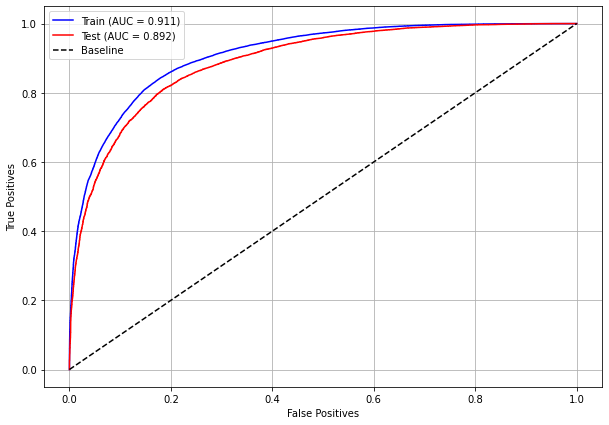

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

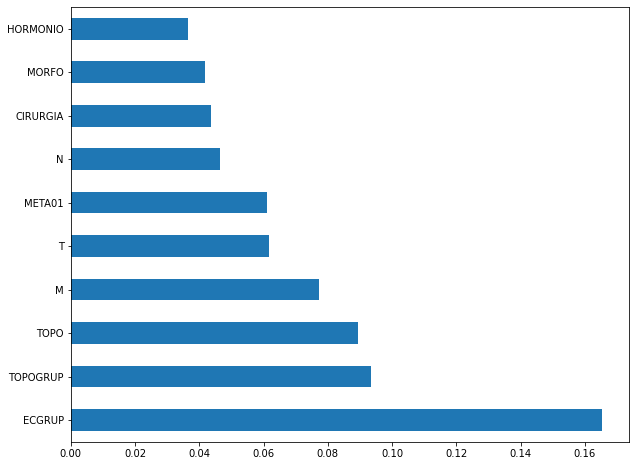

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `TOPO` and `M`.

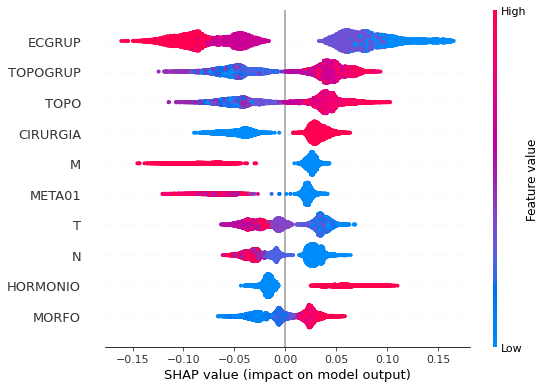

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:2, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 2, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

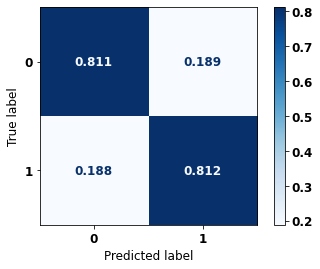


              precision    recall  f1-score   support

           0      0.702     0.811     0.753     10563
           1      0.887     0.812     0.848     19291

    accuracy                          0.812     29854
   macro avg      0.795     0.811     0.800     29854
weighted avg      0.822     0.812     0.814     29854



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 81% of accuracy.

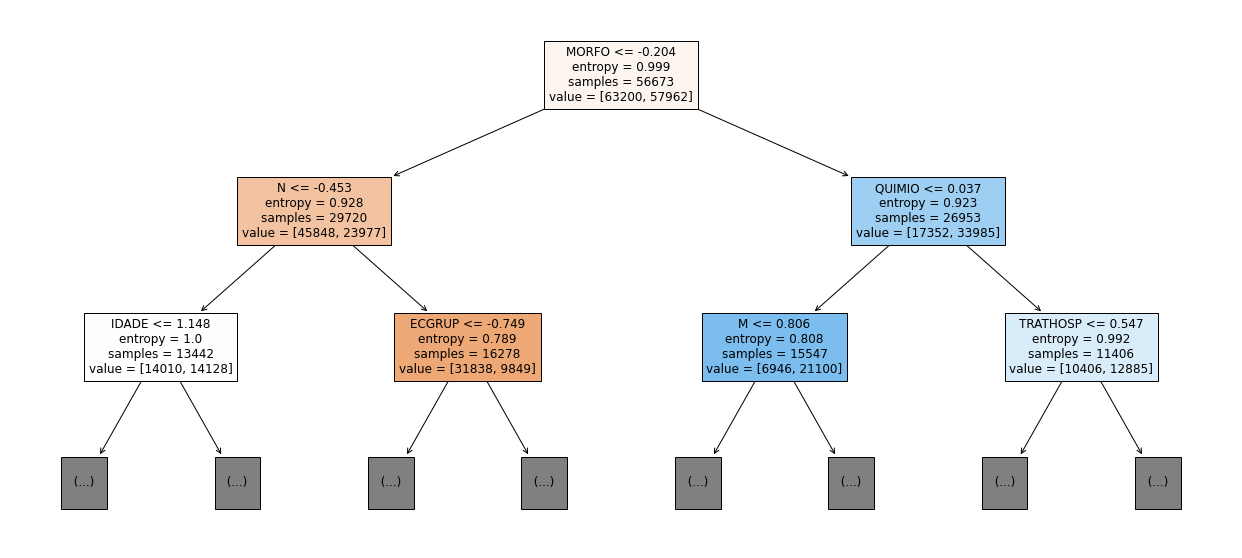

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

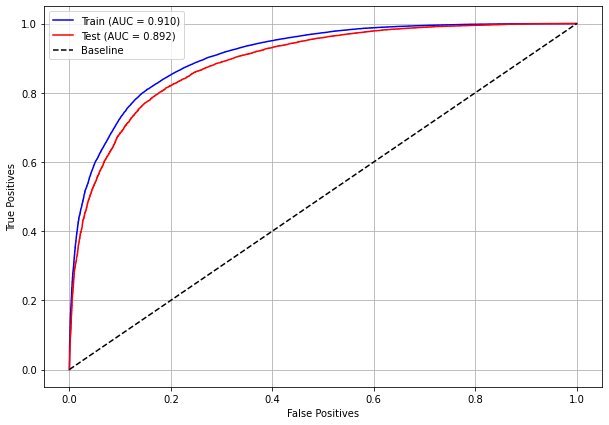

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

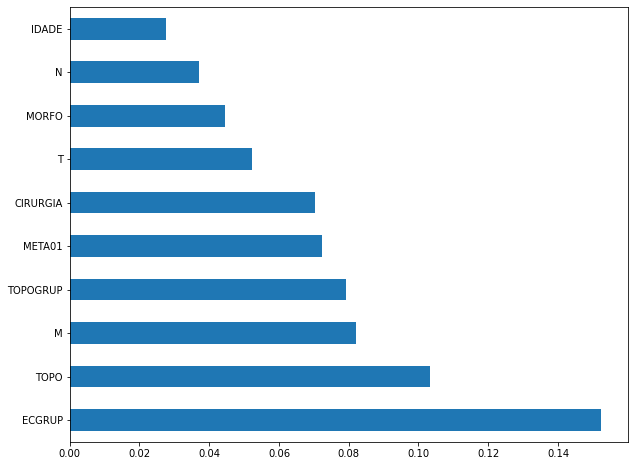

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `M` and `TOPOGRUP`.

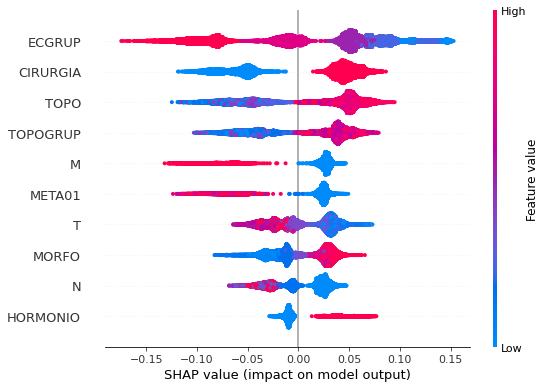

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.26},
                                     criterion='entropy', 
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 1.26}, criterion='entropy',
                       max_depth=10, random_state=10)

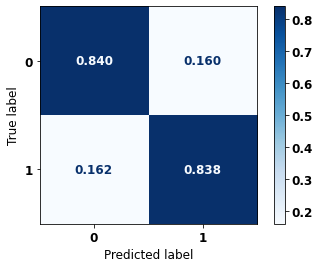


              precision    recall  f1-score   support

           0      0.871     0.840     0.855      6773
           1      0.800     0.838     0.818      5188

    accuracy                          0.839     11961
   macro avg      0.835     0.839     0.837     11961
weighted avg      0.840     0.839     0.839     11961



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 84% of accuracy.

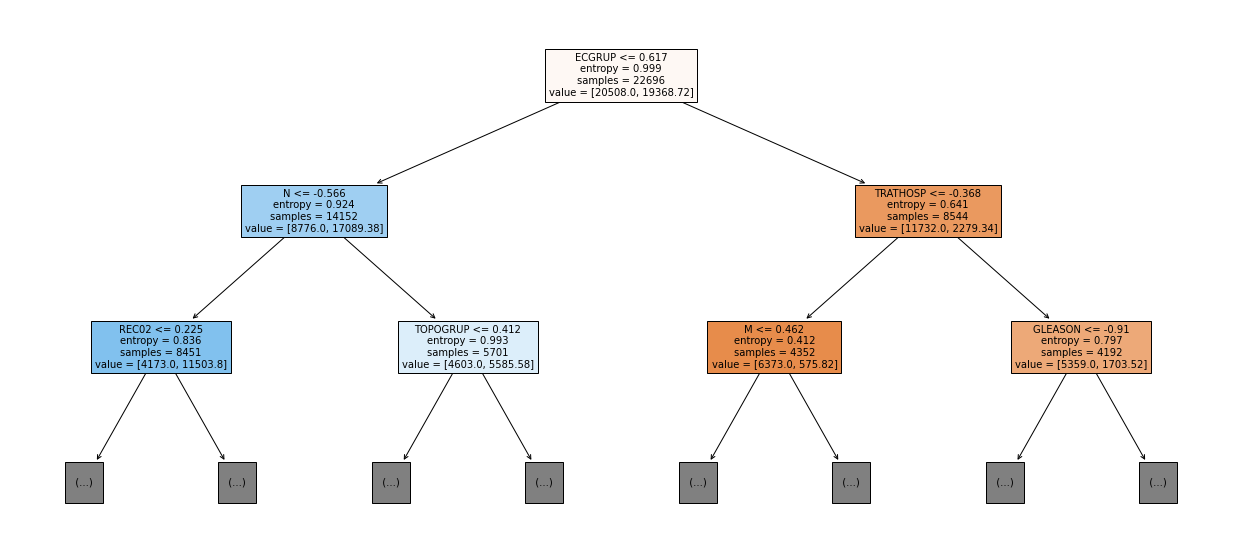

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

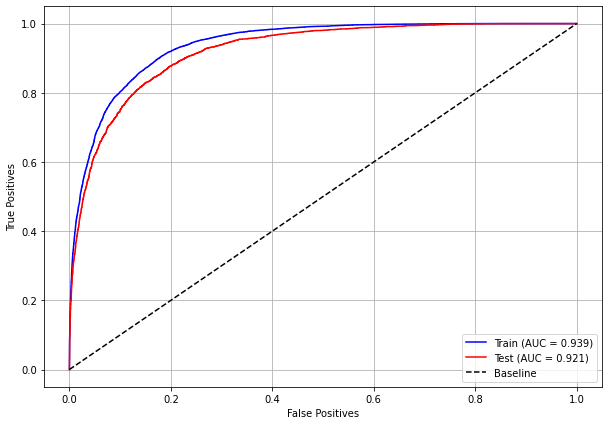

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

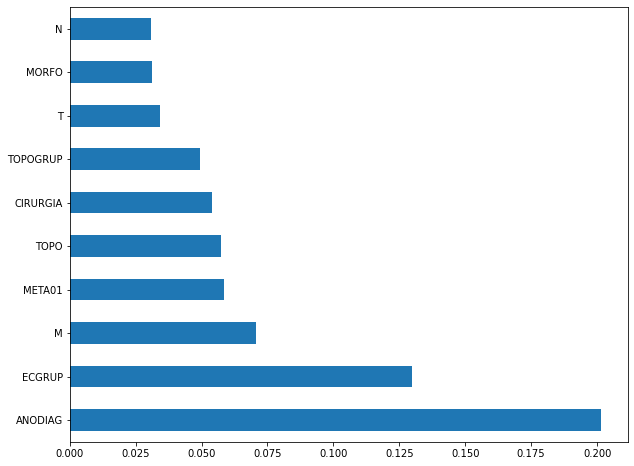

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ANODIAG`, `ECGRUP`, `M`, and `META01`.



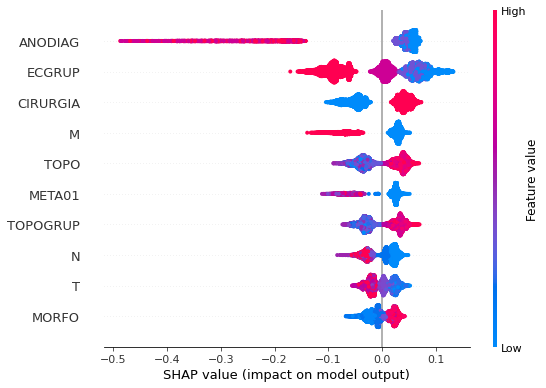

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.776, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.776, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

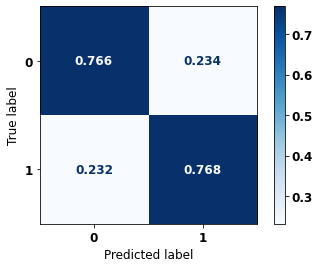


              precision    recall  f1-score   support

           0      0.688     0.766     0.725       351
           1      0.831     0.768     0.798       526

    accuracy                          0.767       877
   macro avg      0.760     0.767     0.762       877
weighted avg      0.774     0.767     0.769       877



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 77% of accuracy.

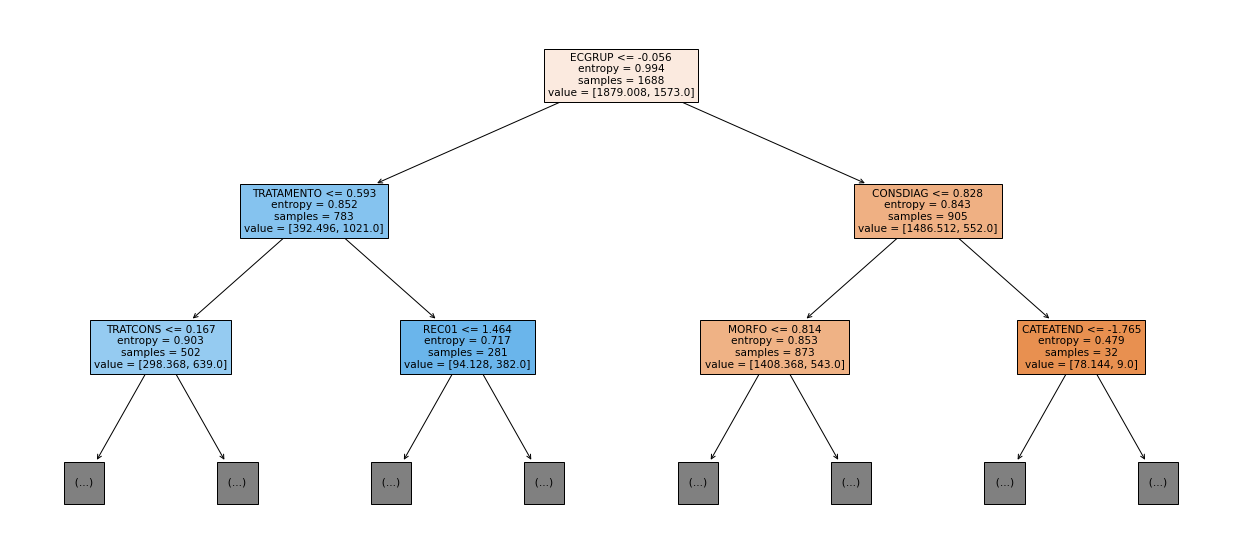

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

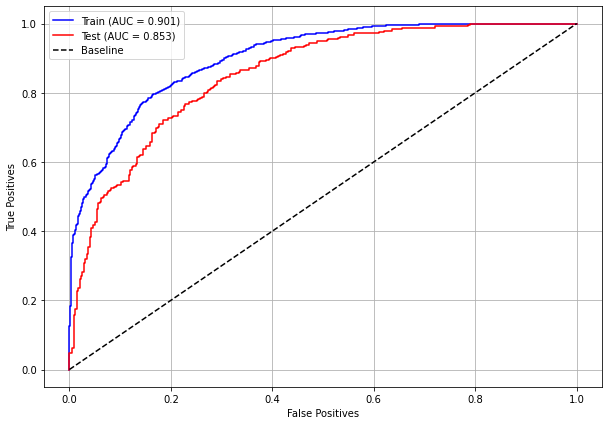

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

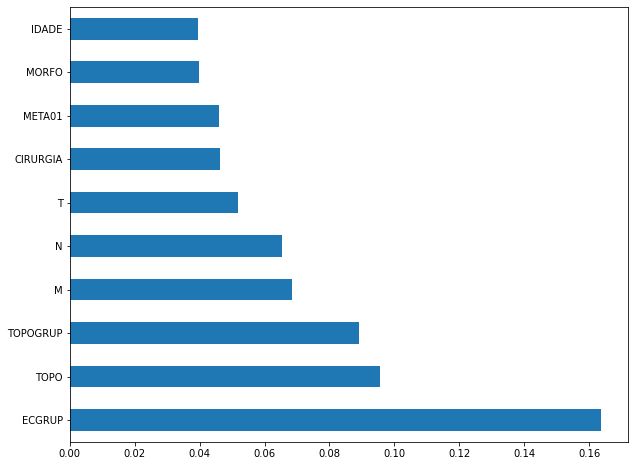

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `M`.

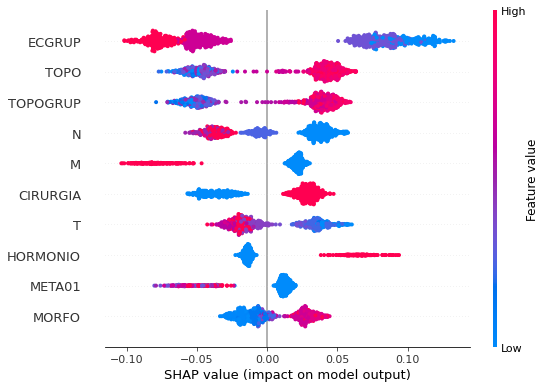

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.7, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1.7, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

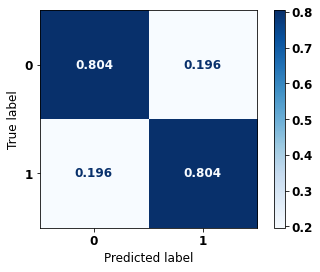


              precision    recall  f1-score   support

           0      0.701     0.804     0.749       443
           1      0.877     0.804     0.839       775

    accuracy                          0.804      1218
   macro avg      0.789     0.804     0.794      1218
weighted avg      0.813     0.804     0.806      1218



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 80% of accuracy.


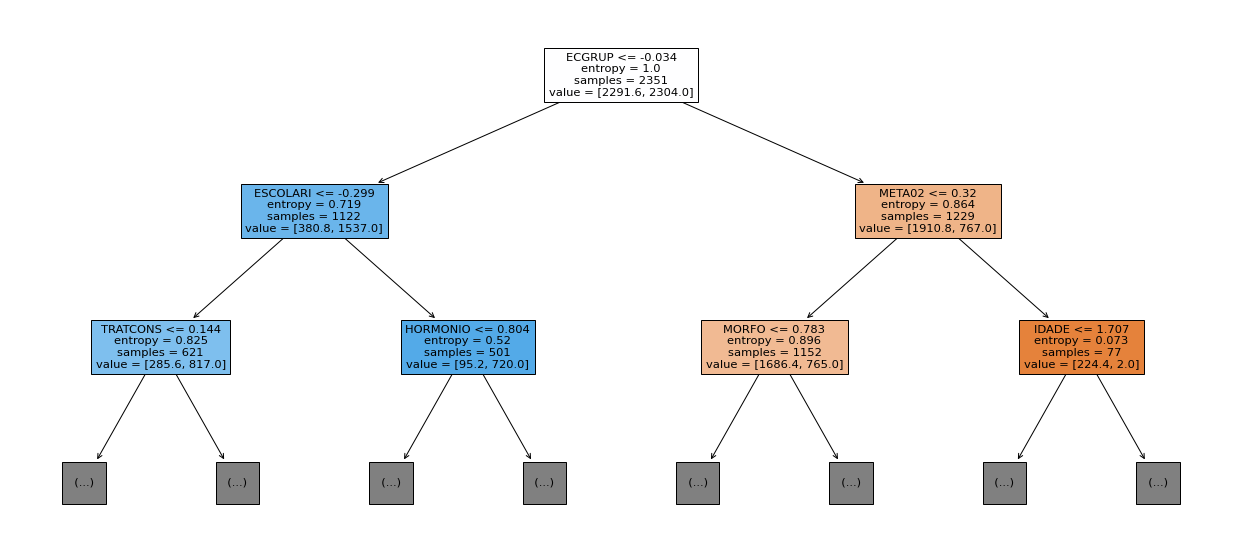

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

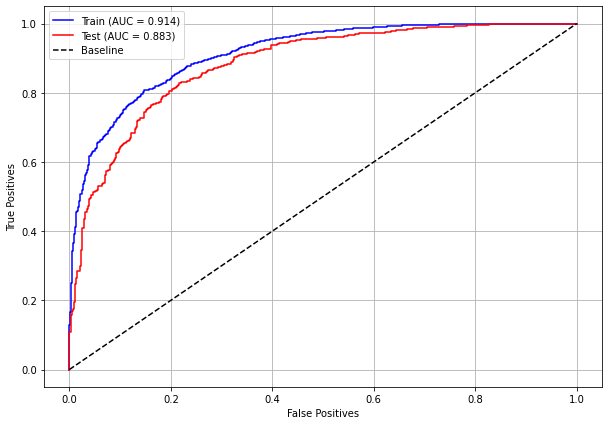

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

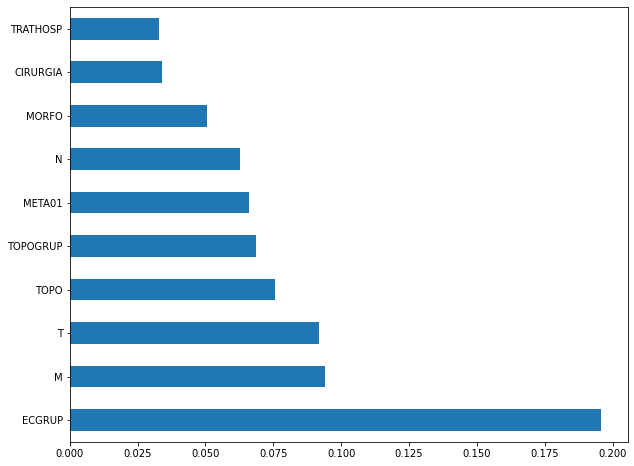

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `TOPO`.

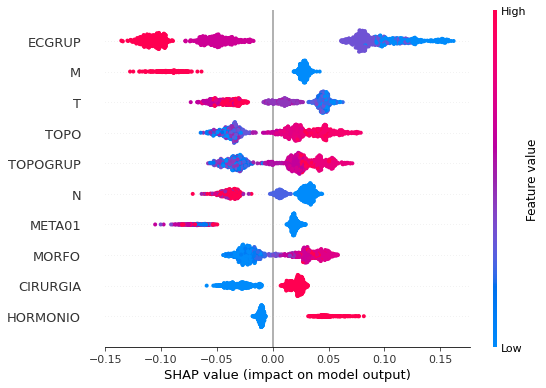

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:2.31, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 2.31, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

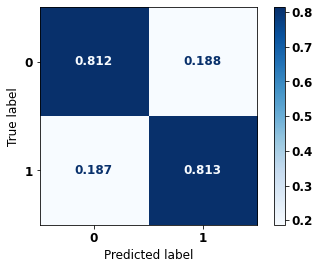


              precision    recall  f1-score   support

           0      0.699     0.812     0.751       510
           1      0.890     0.813     0.850       953

    accuracy                          0.813      1463
   macro avg      0.795     0.812     0.801      1463
weighted avg      0.823     0.813     0.815      1463



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 81% of accuracy.


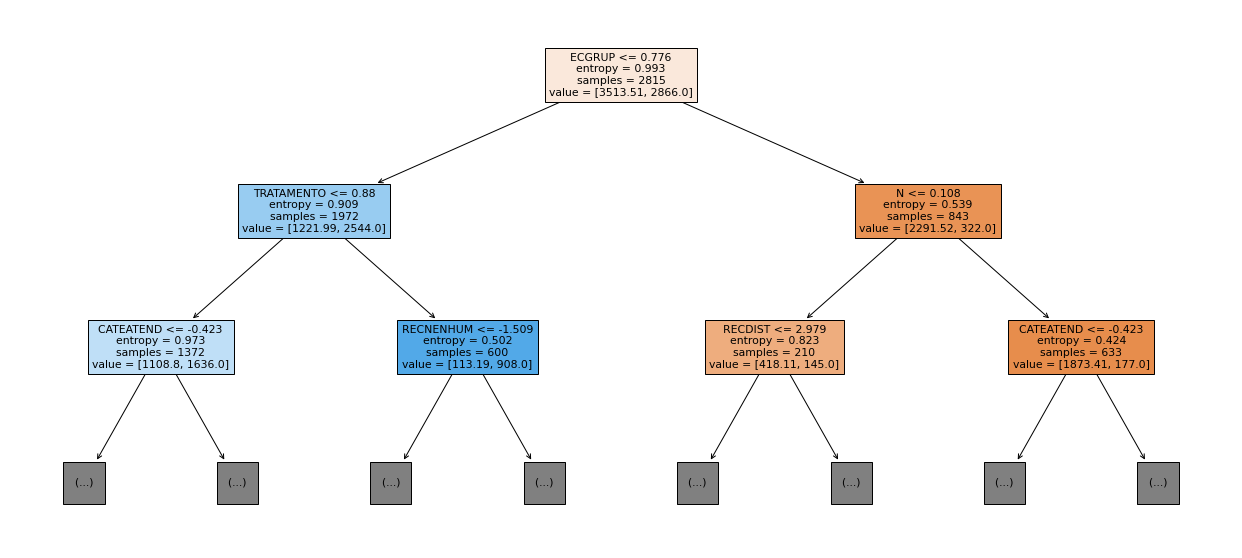

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

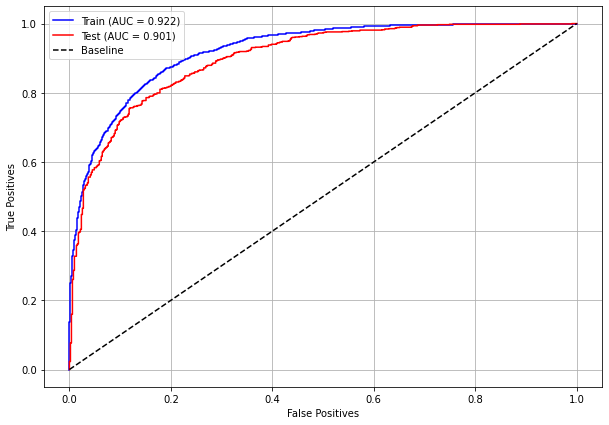

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

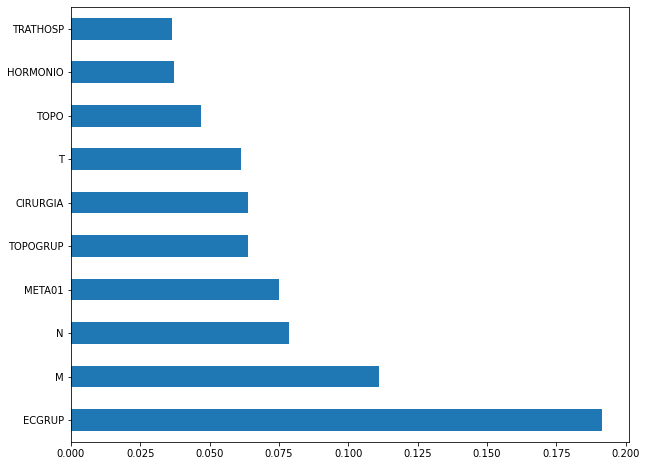

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `N` and `META01`.

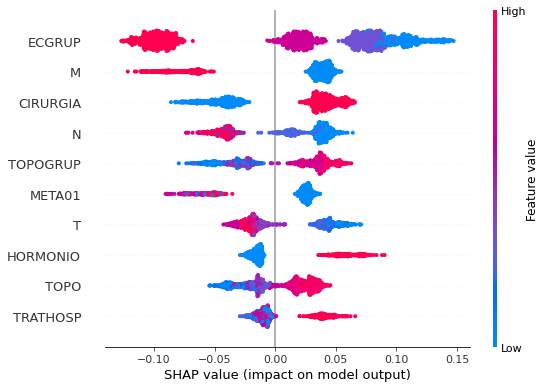

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:2.9, 1:1},
                                       criterion='entropy',
                                       max_depth=7)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 2.9, 1: 1}, criterion='entropy',
                       max_depth=7, random_state=10)

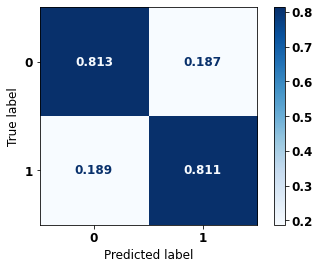


              precision    recall  f1-score   support

           0      0.670     0.813     0.734       571
           1      0.902     0.811     0.854      1211

    accuracy                          0.811      1782
   macro avg      0.786     0.812     0.794      1782
weighted avg      0.827     0.811     0.816      1782



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 81% of accuracy.


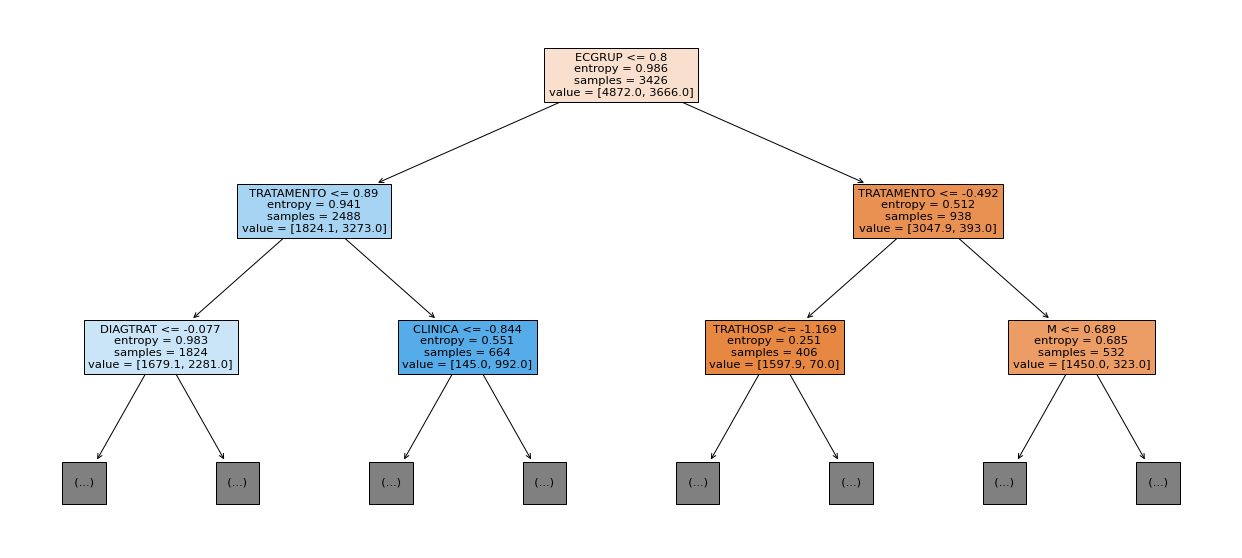

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

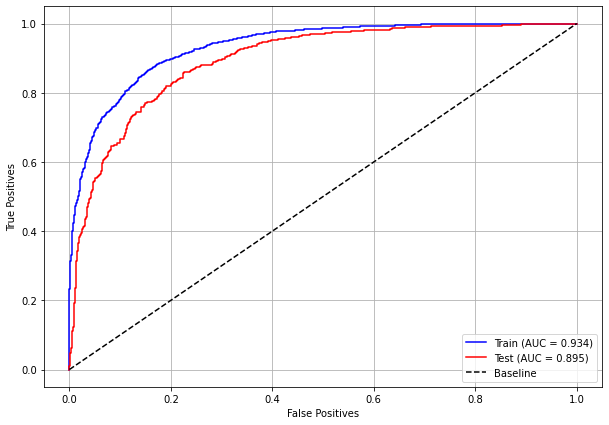

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

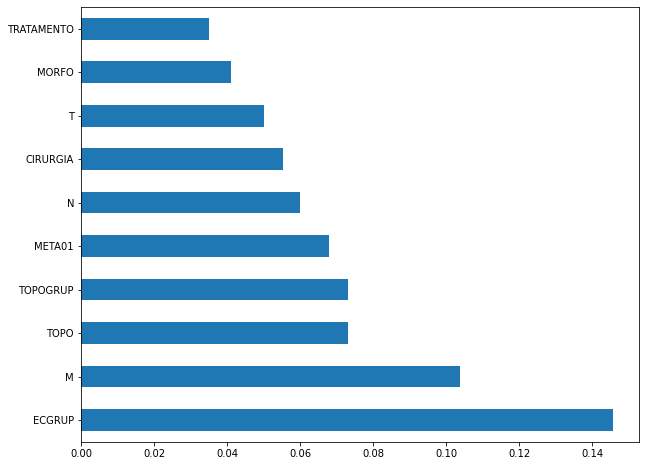

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `TOPOGRUP`.

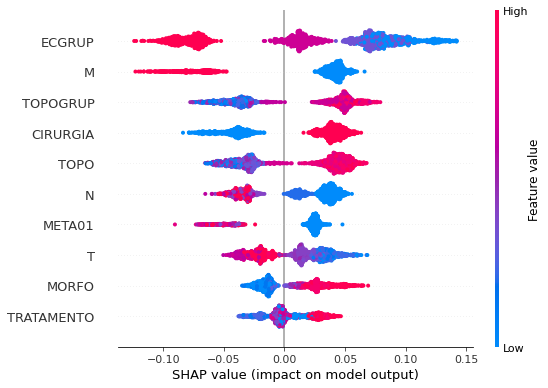

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

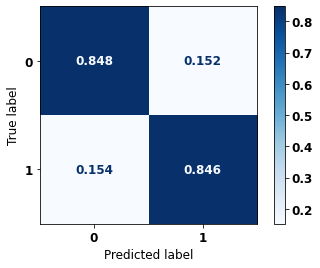


              precision    recall  f1-score   support

           0      0.870     0.848     0.859       539
           1      0.820     0.846     0.833       442

    accuracy                          0.847       981
   macro avg      0.845     0.847     0.846       981
weighted avg      0.848     0.847     0.847       981



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 85% of accuracy.


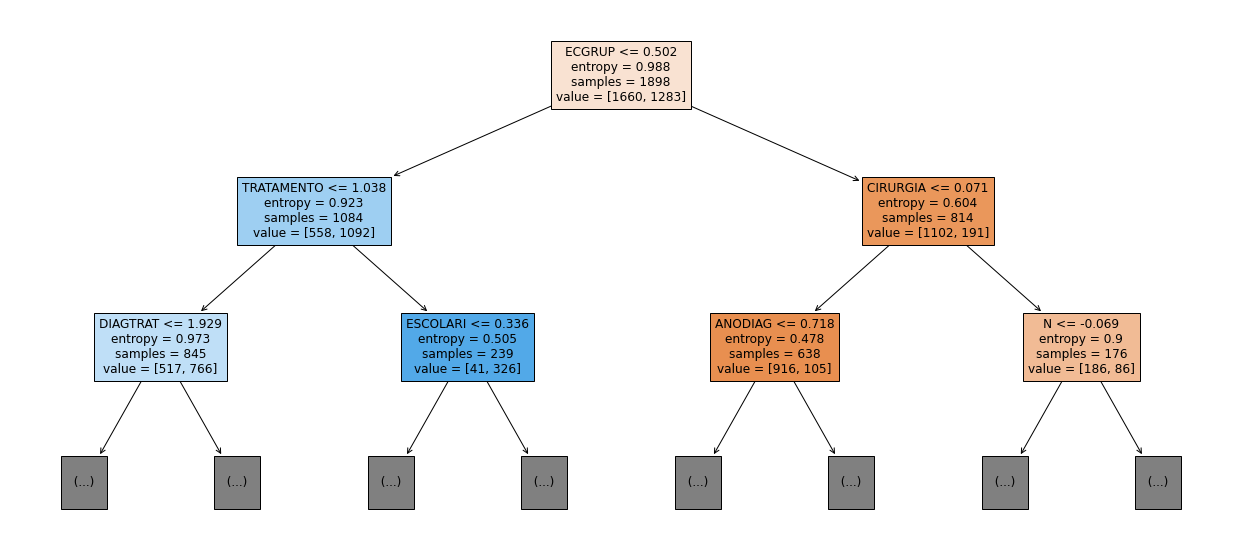

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

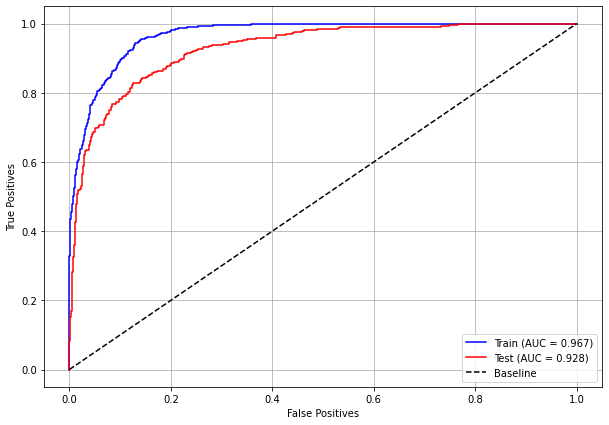

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

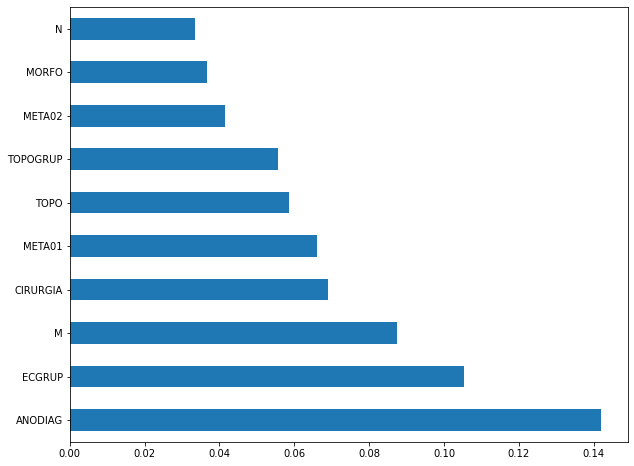

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ANODIAG`, `ECGRUP`, `M` and `CIRURGIA`.

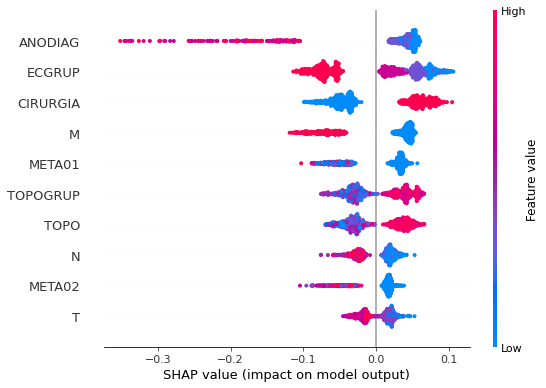

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.71)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.71)

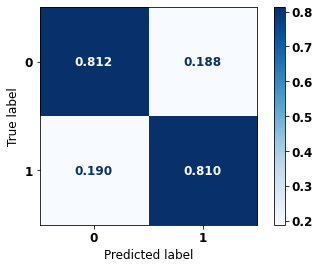


              precision    recall  f1-score   support

           0      0.758     0.812     0.784      6483
           1      0.855     0.810     0.832      8846

    accuracy                          0.811     15329
   macro avg      0.806     0.811     0.808     15329
weighted avg      0.814     0.811     0.812     15329



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 81% of accuracy.

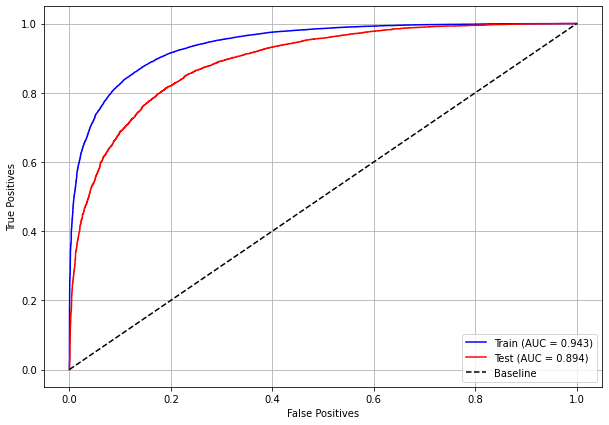

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

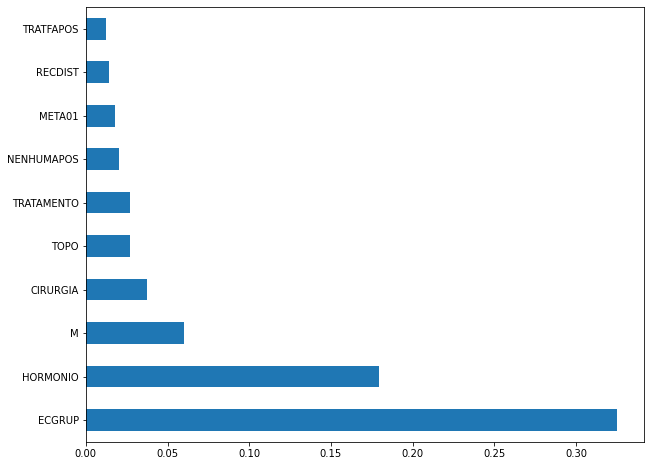

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `CIRURGIA`.

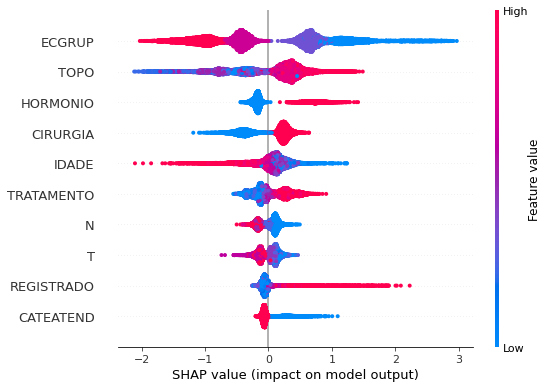

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.635)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.635)

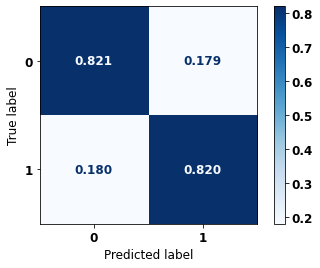


              precision    recall  f1-score   support

           0      0.746     0.821     0.782      7568
           1      0.876     0.820     0.847     11699

    accuracy                          0.820     19267
   macro avg      0.811     0.820     0.814     19267
weighted avg      0.825     0.820     0.821     19267



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 82% of accuracy.


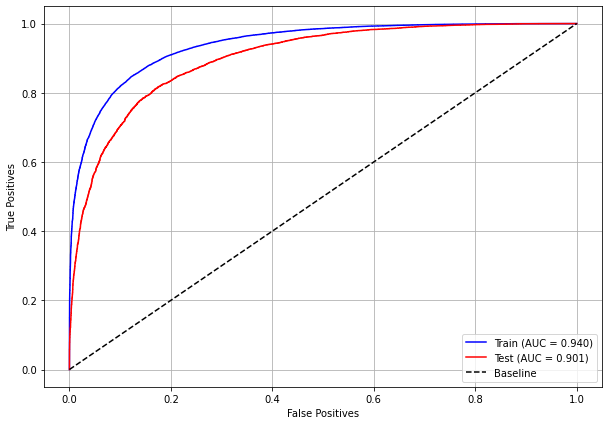

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

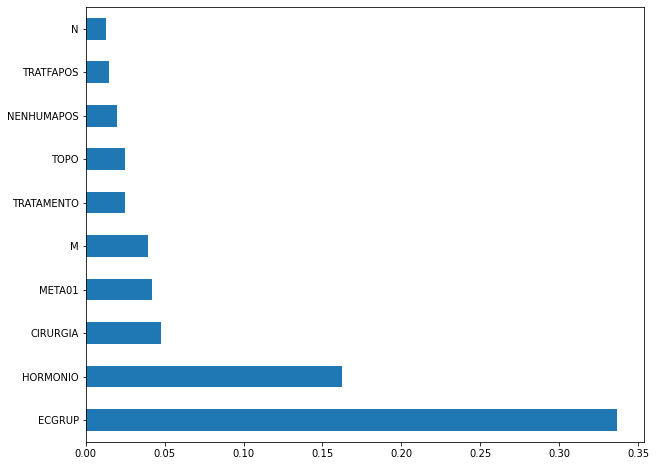

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with some advantage over the others. Following we have `HORMONIO`, `CIRURGIA` and `META01`. 

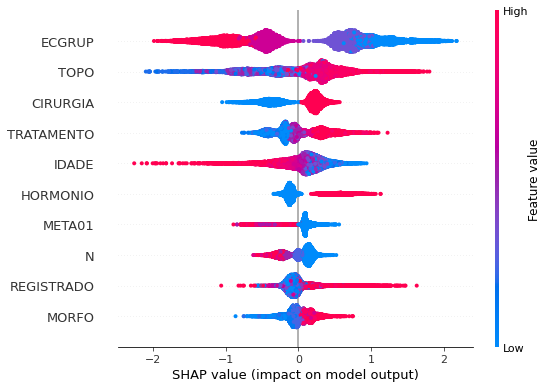

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=0.5605,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.5605)

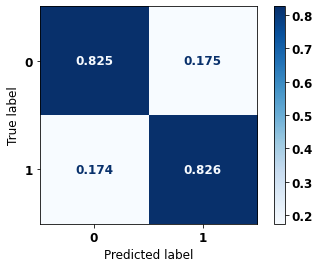


              precision    recall  f1-score   support

           0      0.738     0.825     0.779      9635
           1      0.889     0.826     0.856     16251

    accuracy                          0.826     25886
   macro avg      0.813     0.826     0.818     25886
weighted avg      0.832     0.826     0.827     25886



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

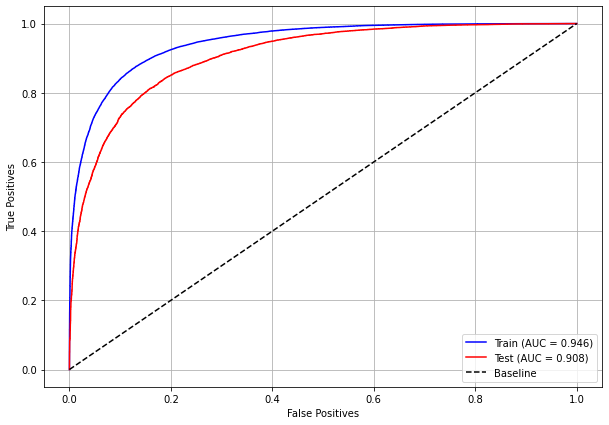

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

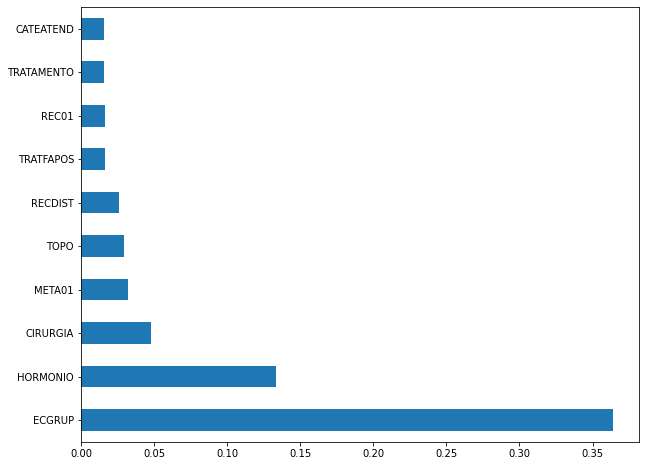

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `HORMONIO`, `CIRURGIA` and `META01`. 

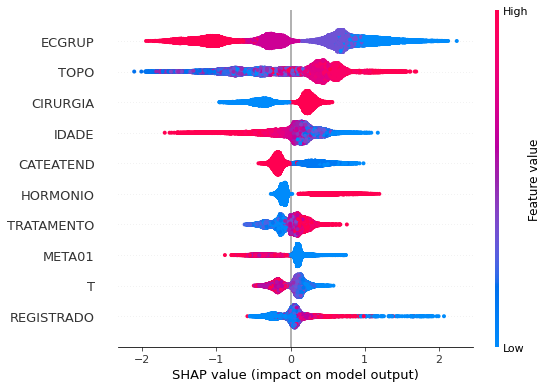

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=0.51)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.51)

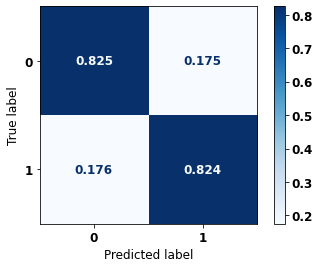


              precision    recall  f1-score   support

           0      0.720     0.825     0.769     10563
           1      0.896     0.824     0.858     19291

    accuracy                          0.824     29854
   macro avg      0.808     0.825     0.814     29854
weighted avg      0.834     0.824     0.827     29854



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

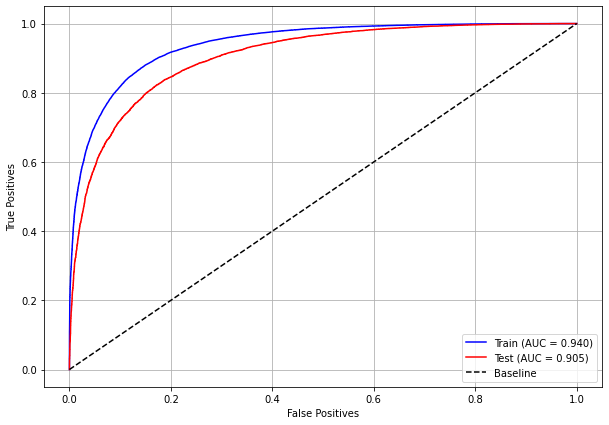

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

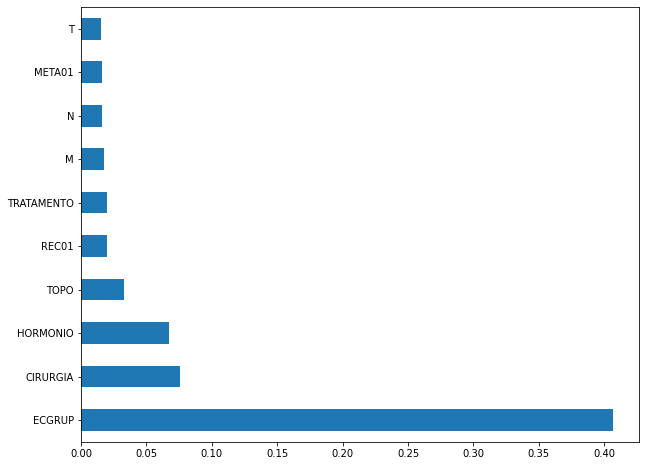

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `CIRURGIA`, `HORMONIO` and `TOPO`. 

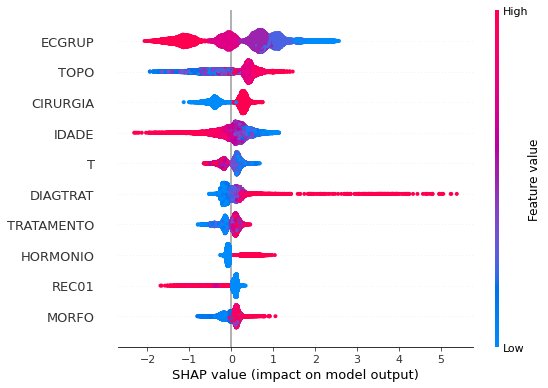

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.26)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.26)

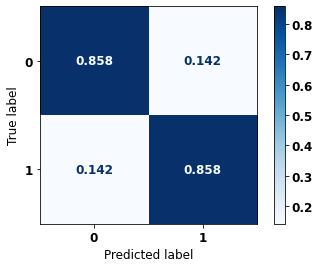


              precision    recall  f1-score   support

           0      0.888     0.858     0.872      6773
           1      0.822     0.858     0.840      5188

    accuracy                          0.858     11961
   macro avg      0.855     0.858     0.856     11961
weighted avg      0.859     0.858     0.858     11961



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 86% of accuracy.


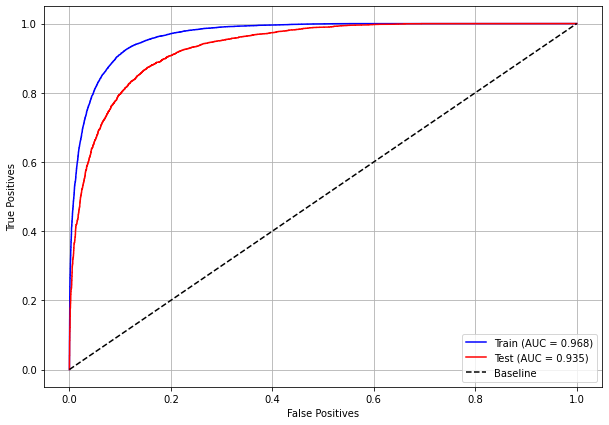

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

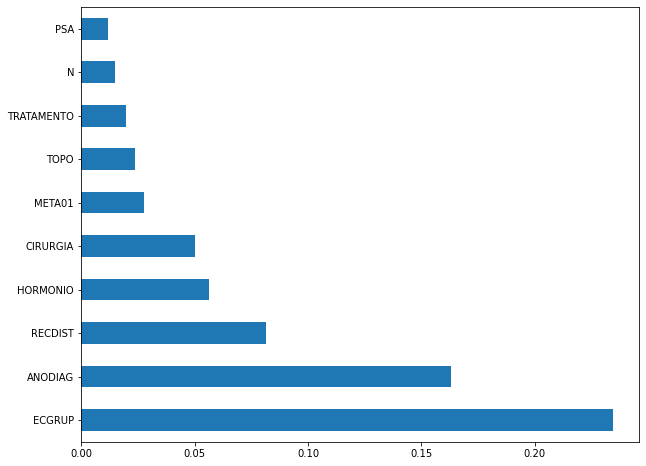

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `ANODIAG`, `RECDIST` and `HORMONIO`.

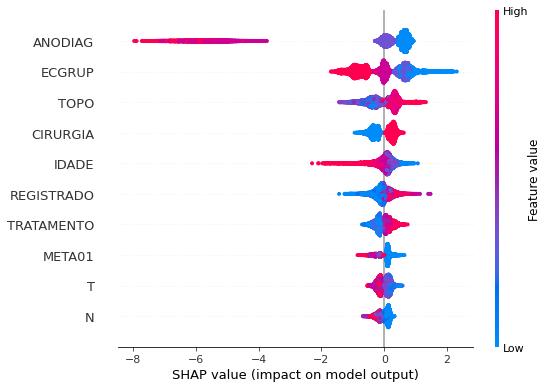

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.55,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.55)

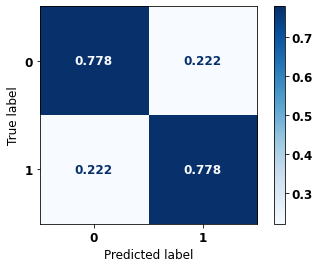


              precision    recall  f1-score   support

           0      0.700     0.778     0.737       351
           1      0.840     0.778     0.808       526

    accuracy                          0.778       877
   macro avg      0.770     0.778     0.772       877
weighted avg      0.784     0.778     0.779       877



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 78% of accuracy.

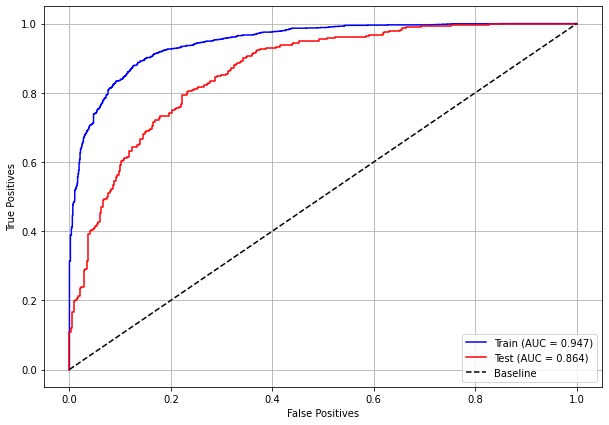

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

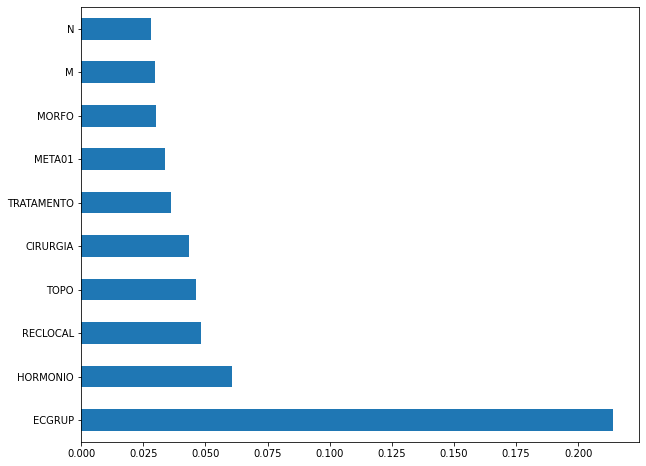

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `RECLOCAL` and `TOPO`.

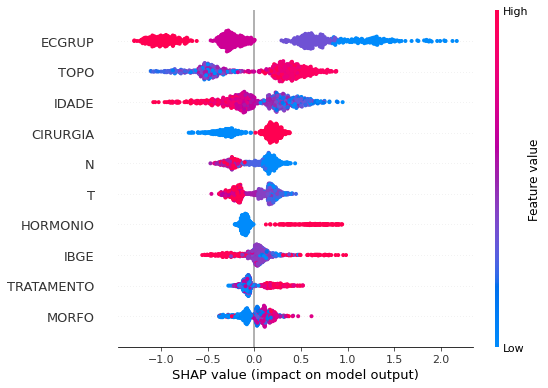

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.6,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.6)

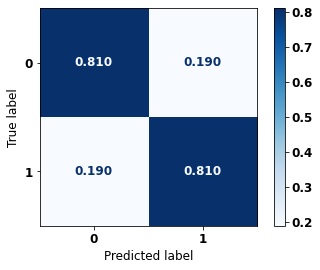


              precision    recall  f1-score   support

           0      0.709     0.810     0.757       443
           1      0.882     0.810     0.845       775

    accuracy                          0.810      1218
   macro avg      0.796     0.810     0.801      1218
weighted avg      0.819     0.810     0.813      1218



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 81% of accuracy.

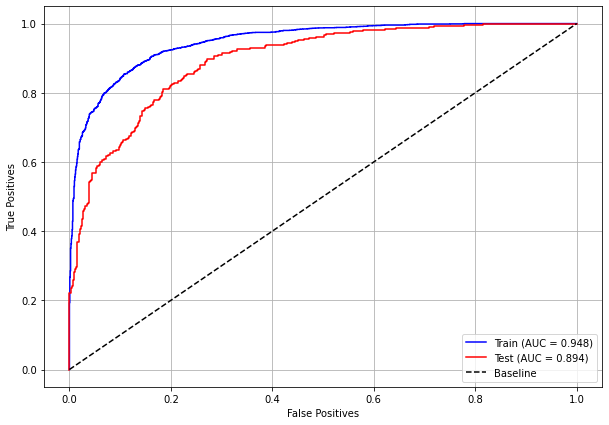

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

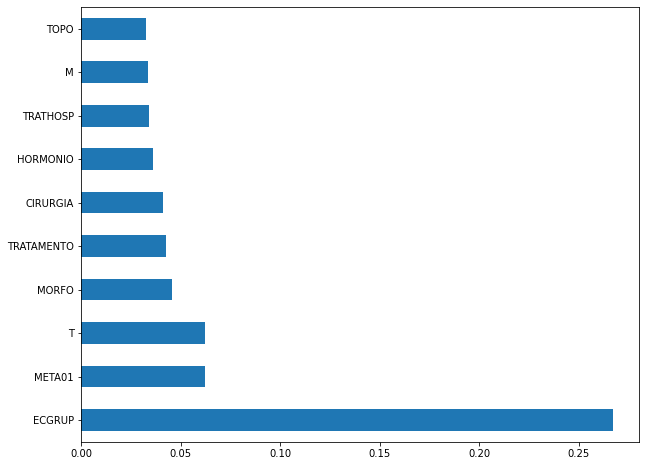

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `META01`, `T` and `MORFO`.

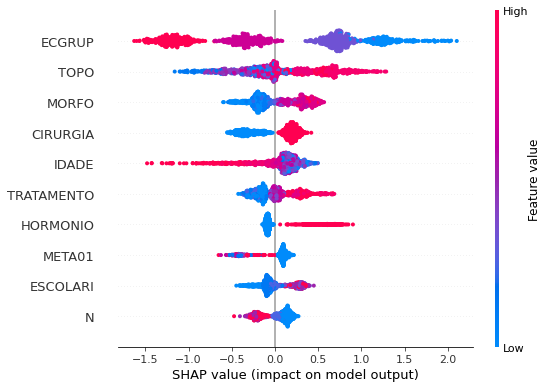

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.49,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.49)

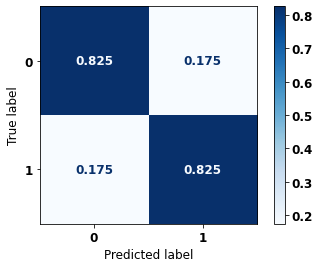


              precision    recall  f1-score   support

           0      0.716     0.825     0.767       510
           1      0.898     0.825     0.860       953

    accuracy                          0.825      1463
   macro avg      0.807     0.825     0.813      1463
weighted avg      0.835     0.825     0.827      1463



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 82% of accuracy.

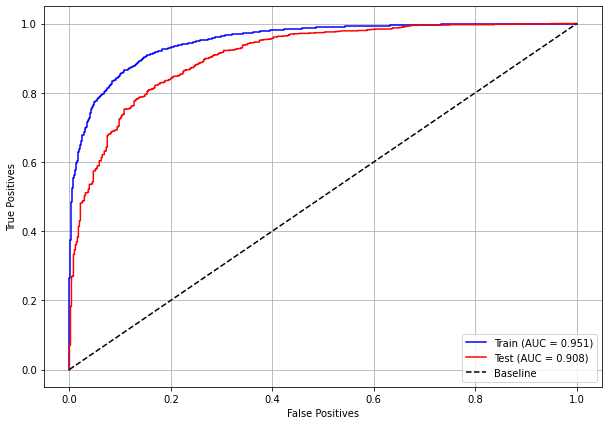

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

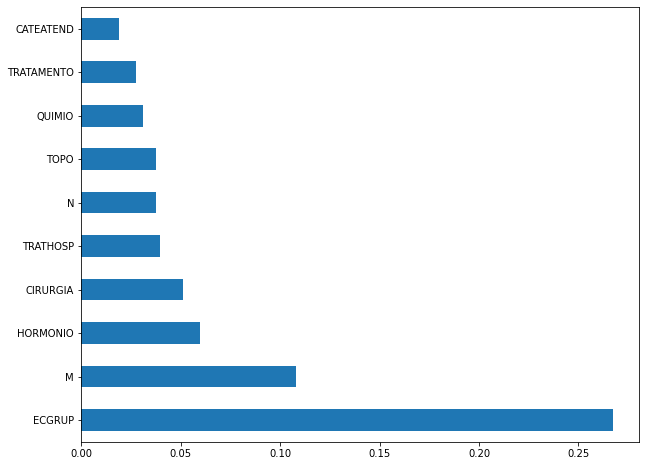

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, with a lot advantage. The following most important features were `M`, `HORMONIO` and `CIRURGIA`.

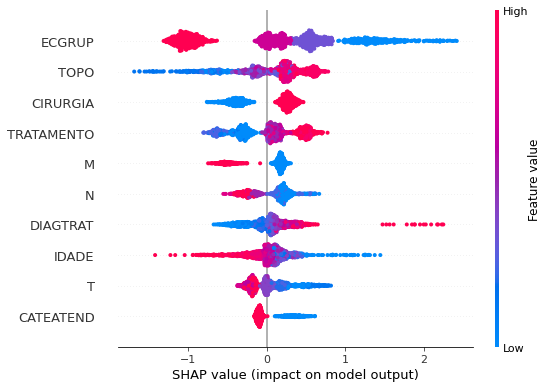

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.37,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.37)

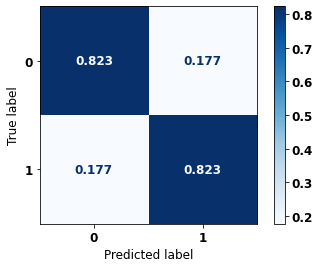


              precision    recall  f1-score   support

           0      0.687     0.823     0.749       571
           1      0.908     0.823     0.864      1211

    accuracy                          0.823      1782
   macro avg      0.798     0.823     0.806      1782
weighted avg      0.837     0.823     0.827      1782



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 82% of accuracy.

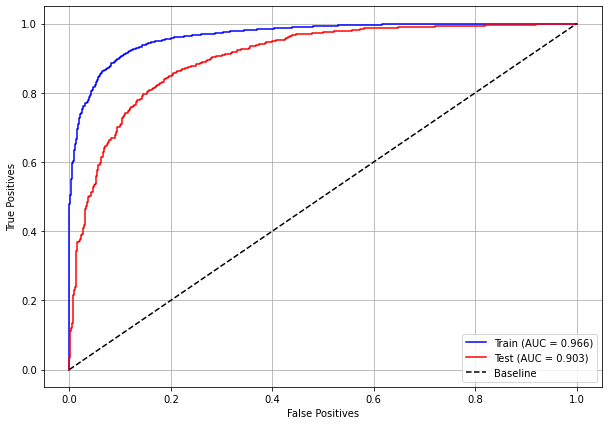

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

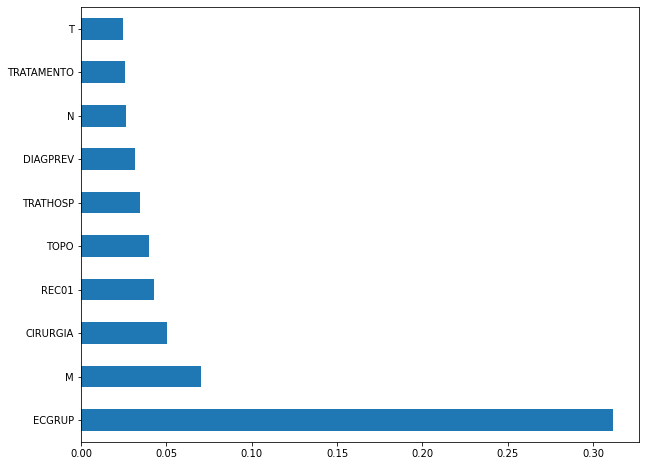

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `M`, `CIRURGIA` and `REC01`.

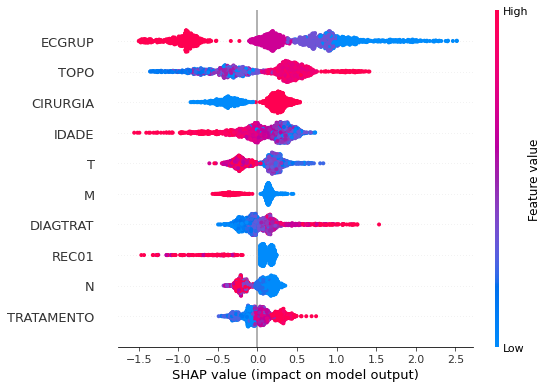

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.04,
                               random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.04)

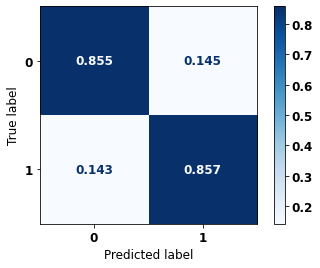


              precision    recall  f1-score   support

           0      0.880     0.855     0.867       539
           1      0.829     0.857     0.843       442

    accuracy                          0.856       981
   macro avg      0.855     0.856     0.855       981
weighted avg      0.857     0.856     0.856       981



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 86% of accuracy.

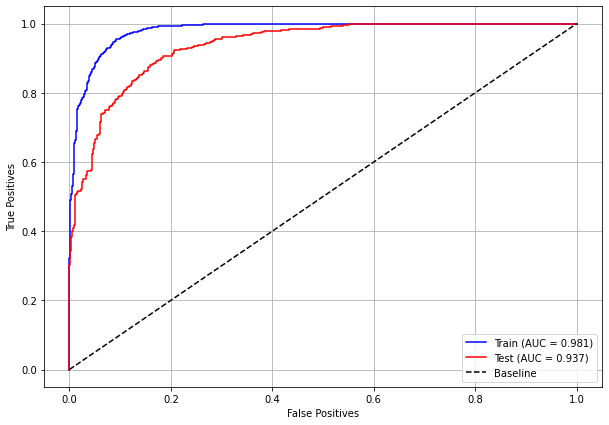

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

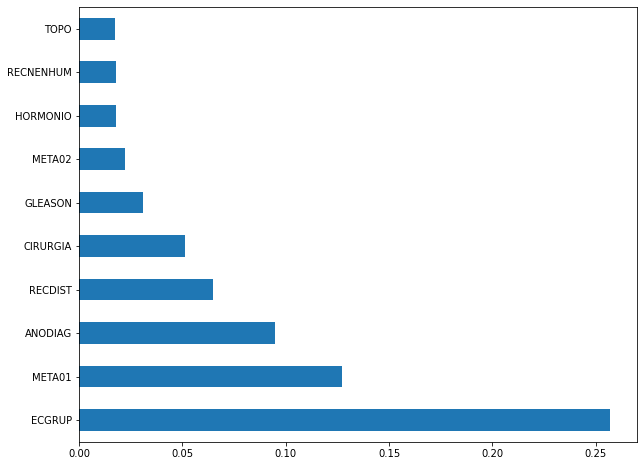

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `META01`, `ANODIAG` and `RECDIST`.

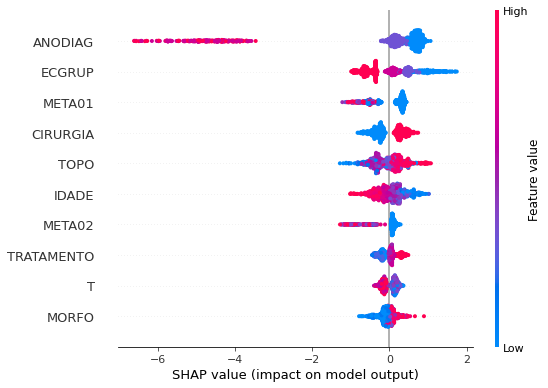

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

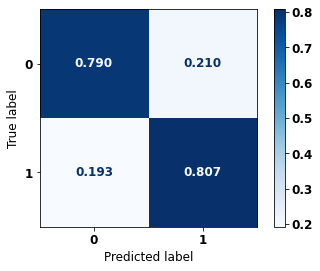


              precision    recall  f1-score   support

           0      0.726     0.790     0.757      7568
           1      0.856     0.807     0.831     11699

    accuracy                          0.801     19267
   macro avg      0.791     0.799     0.794     19267
weighted avg      0.805     0.801     0.802     19267



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

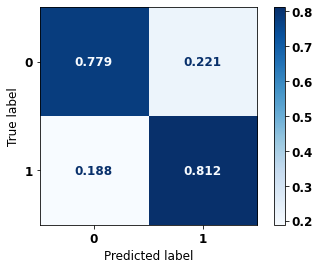


              precision    recall  f1-score   support

           0      0.710     0.779     0.743      9635
           1      0.861     0.812     0.836     16251

    accuracy                          0.799     25886
   macro avg      0.786     0.795     0.789     25886
weighted avg      0.805     0.799     0.801     25886



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

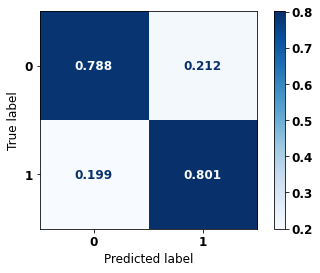


              precision    recall  f1-score   support

           0      0.684     0.788     0.732     10563
           1      0.873     0.801     0.835     19291

    accuracy                          0.796     29854
   macro avg      0.779     0.794     0.784     29854
weighted avg      0.806     0.796     0.799     29854



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

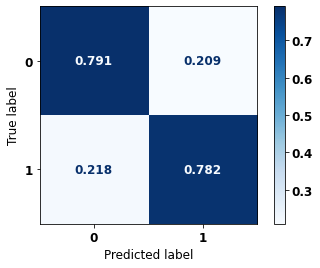


              precision    recall  f1-score   support

           0      0.826     0.791     0.808      6773
           1      0.742     0.782     0.761      5188

    accuracy                          0.787     11961
   macro avg      0.784     0.787     0.785     11961
weighted avg      0.789     0.787     0.788     11961



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

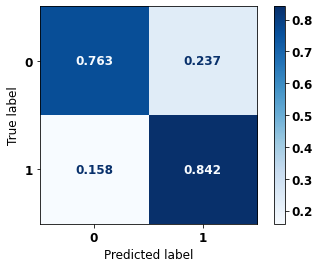


              precision    recall  f1-score   support

           0      0.757     0.763     0.760      7568
           1      0.846     0.842     0.844     11699

    accuracy                          0.811     19267
   macro avg      0.802     0.802     0.802     19267
weighted avg      0.811     0.811     0.811     19267



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

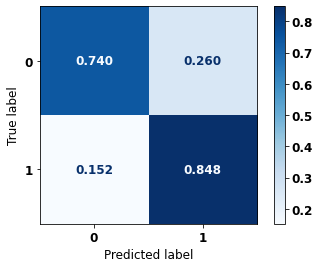


              precision    recall  f1-score   support

           0      0.742     0.740     0.741      9635
           1      0.846     0.848     0.847     16251

    accuracy                          0.807     25886
   macro avg      0.794     0.794     0.794     25886
weighted avg      0.807     0.807     0.807     25886



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

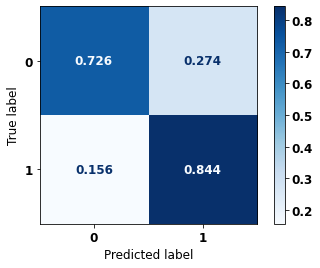


              precision    recall  f1-score   support

           0      0.718     0.726     0.722     10563
           1      0.849     0.844     0.846     19291

    accuracy                          0.802     29854
   macro avg      0.783     0.785     0.784     29854
weighted avg      0.803     0.802     0.802     29854



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

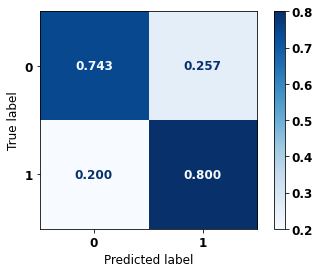


              precision    recall  f1-score   support

           0      0.829     0.743     0.784      6773
           1      0.705     0.800     0.749      5188

    accuracy                          0.768     11961
   macro avg      0.767     0.772     0.767     11961
weighted avg      0.775     0.768     0.769     11961



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

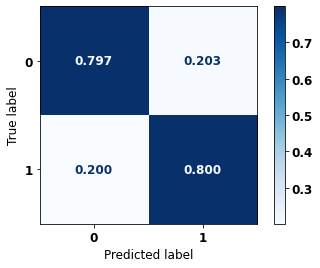


              precision    recall  f1-score   support

           0      0.702     0.797     0.746      9635
           1      0.869     0.800     0.833     16251

    accuracy                          0.799     25886
   macro avg      0.786     0.798     0.790     25886
weighted avg      0.807     0.799     0.801     25886



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

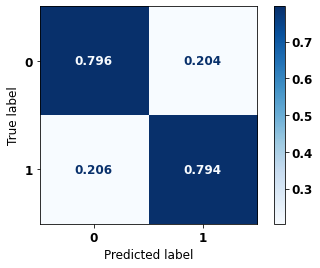


              precision    recall  f1-score   support

           0      0.679     0.796     0.733     10563
           1      0.877     0.794     0.833     19291

    accuracy                          0.795     29854
   macro avg      0.778     0.795     0.783     29854
weighted avg      0.807     0.795     0.798     29854



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

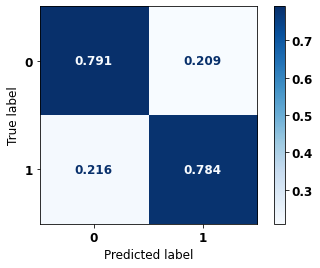


              precision    recall  f1-score   support

           0      0.827     0.791     0.809      6773
           1      0.742     0.784     0.762      5188

    accuracy                          0.788     11961
   macro avg      0.784     0.787     0.785     11961
weighted avg      0.790     0.788     0.789     11961



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

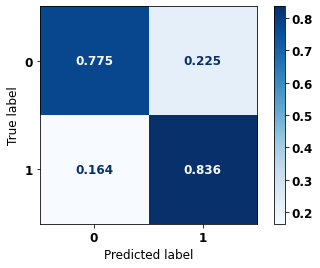


              precision    recall  f1-score   support

           0      0.736     0.775     0.755      9635
           1      0.862     0.836     0.849     16251

    accuracy                          0.813     25886
   macro avg      0.799     0.805     0.802     25886
weighted avg      0.815     0.813     0.814     25886



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

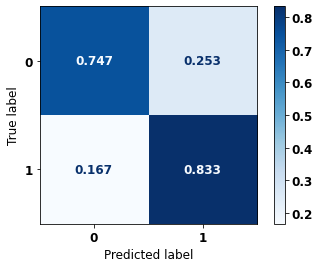


              precision    recall  f1-score   support

           0      0.710     0.747     0.728     10563
           1      0.857     0.833     0.845     19291

    accuracy                          0.802     29854
   macro avg      0.783     0.790     0.786     29854
weighted avg      0.805     0.802     0.803     29854



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

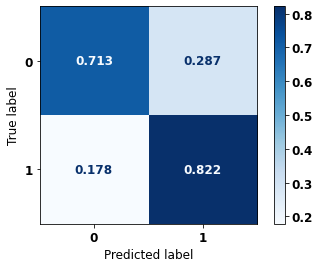


              precision    recall  f1-score   support

           0      0.839     0.713     0.771      6773
           1      0.687     0.822     0.748      5188

    accuracy                          0.760     11961
   macro avg      0.763     0.768     0.760     11961
weighted avg      0.773     0.760     0.761     11961



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

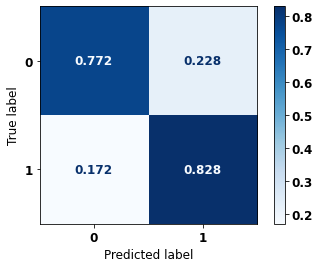


              precision    recall  f1-score   support

           0      0.711     0.772     0.740     10563
           1      0.869     0.828     0.848     19291

    accuracy                          0.808     29854
   macro avg      0.790     0.800     0.794     29854
weighted avg      0.813     0.808     0.810     29854



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

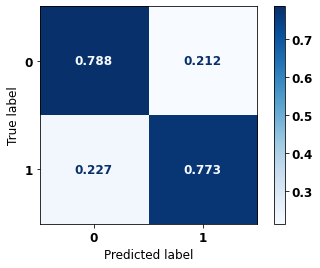


              precision    recall  f1-score   support

           0      0.819     0.788     0.803      6773
           1      0.736     0.773     0.754      5188

    accuracy                          0.781     11961
   macro avg      0.777     0.780     0.778     11961
weighted avg      0.783     0.781     0.782     11961



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

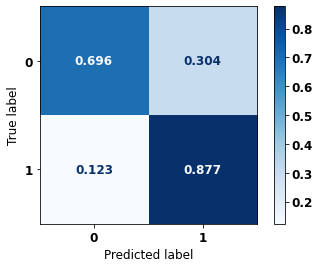


              precision    recall  f1-score   support

           0      0.756     0.696     0.725     10563
           1      0.840     0.877     0.858     19291

    accuracy                          0.813     29854
   macro avg      0.798     0.786     0.791     29854
weighted avg      0.810     0.813     0.811     29854



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

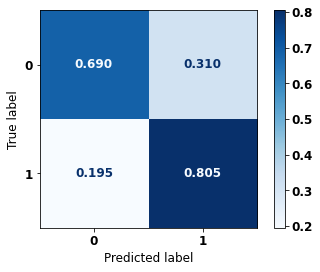


              precision    recall  f1-score   support

           0      0.822     0.690     0.750      6773
           1      0.665     0.805     0.728      5188

    accuracy                          0.740     11961
   macro avg      0.743     0.747     0.739     11961
weighted avg      0.754     0.740     0.741     11961



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

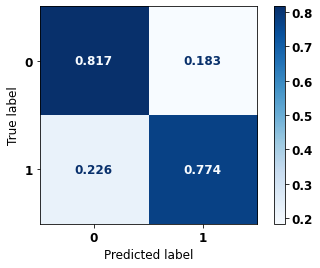


              precision    recall  f1-score   support

           0      0.825     0.817     0.821      6773
           1      0.764     0.774     0.769      5188

    accuracy                          0.798     11961
   macro avg      0.794     0.795     0.795     11961
weighted avg      0.798     0.798     0.798     11961



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

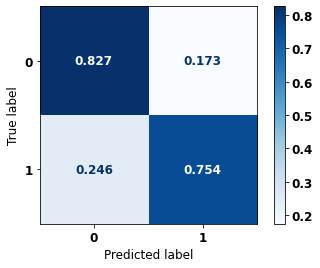


              precision    recall  f1-score   support

           0      0.814     0.827     0.820      6773
           1      0.769     0.754     0.761      5188

    accuracy                          0.795     11961
   macro avg      0.792     0.790     0.791     11961
weighted avg      0.795     0.795     0.795     11961



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

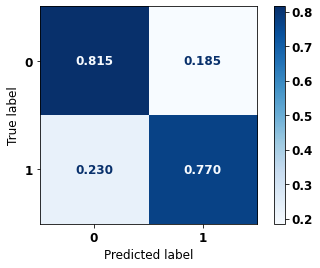


              precision    recall  f1-score   support

           0      0.670     0.815     0.735       443
           1      0.879     0.770     0.821       775

    accuracy                          0.787      1218
   macro avg      0.774     0.793     0.778      1218
weighted avg      0.803     0.787     0.790      1218



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

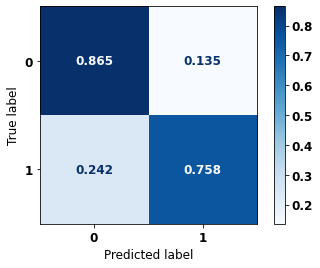


              precision    recall  f1-score   support

           0      0.656     0.865     0.746       510
           1      0.913     0.758     0.828       953

    accuracy                          0.795      1463
   macro avg      0.785     0.811     0.787      1463
weighted avg      0.823     0.795     0.799      1463



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

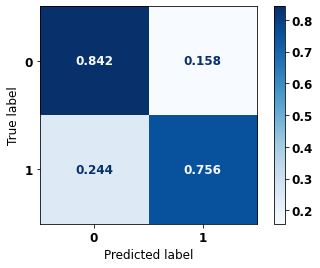


              precision    recall  f1-score   support

           0      0.619     0.842     0.714       571
           1      0.910     0.756     0.826      1211

    accuracy                          0.783      1782
   macro avg      0.765     0.799     0.770      1782
weighted avg      0.817     0.783     0.790      1782



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

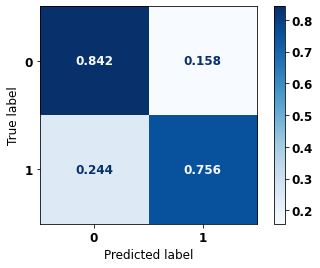


              precision    recall  f1-score   support

           0      0.808     0.842     0.825       539
           1      0.797     0.756     0.776       442

    accuracy                          0.803       981
   macro avg      0.802     0.799     0.800       981
weighted avg      0.803     0.803     0.803       981



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

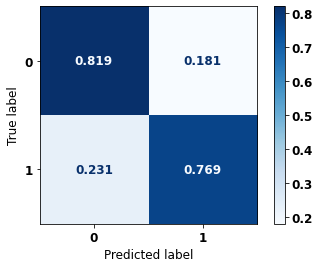


              precision    recall  f1-score   support

           0      0.670     0.819     0.737       443
           1      0.882     0.769     0.822       775

    accuracy                          0.787      1218
   macro avg      0.776     0.794     0.779      1218
weighted avg      0.805     0.787     0.791      1218



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

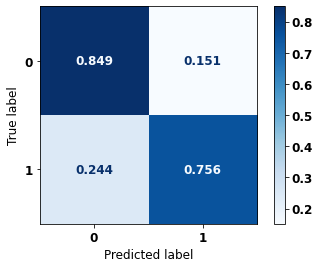


              precision    recall  f1-score   support

           0      0.650     0.849     0.736       510
           1      0.903     0.756     0.823       953

    accuracy                          0.788      1463
   macro avg      0.777     0.802     0.780      1463
weighted avg      0.815     0.788     0.793      1463



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

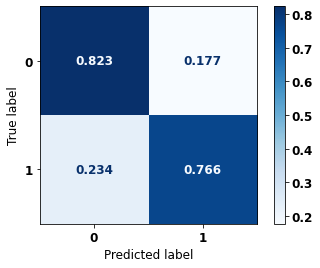


              precision    recall  f1-score   support

           0      0.624     0.823     0.710       571
           1      0.902     0.766     0.829      1211

    accuracy                          0.785      1782
   macro avg      0.763     0.795     0.769      1782
weighted avg      0.813     0.785     0.791      1782



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

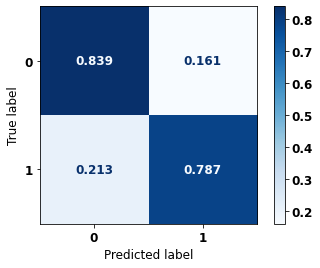


              precision    recall  f1-score   support

           0      0.828     0.839     0.833       539
           1      0.800     0.787     0.794       442

    accuracy                          0.815       981
   macro avg      0.814     0.813     0.813       981
weighted avg      0.815     0.815     0.815       981



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

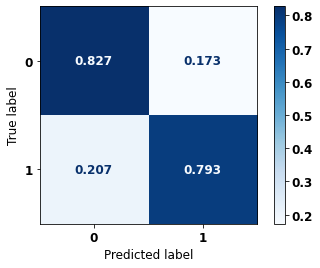


              precision    recall  f1-score   support

           0      0.682     0.827     0.748       510
           1      0.896     0.793     0.841       953

    accuracy                          0.805      1463
   macro avg      0.789     0.810     0.794      1463
weighted avg      0.821     0.805     0.809      1463



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

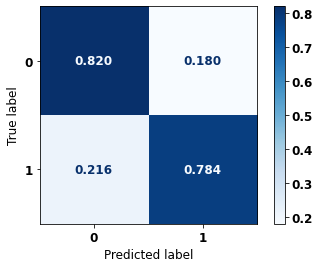


              precision    recall  f1-score   support

           0      0.642     0.820     0.720       571
           1      0.902     0.784     0.839      1211

    accuracy                          0.796      1782
   macro avg      0.772     0.802     0.780      1782
weighted avg      0.819     0.796     0.801      1782



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

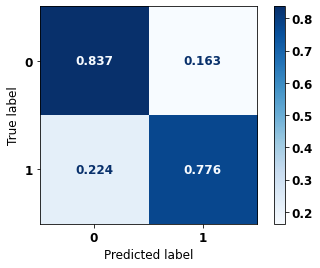


              precision    recall  f1-score   support

           0      0.820     0.837     0.828       539
           1      0.796     0.776     0.786       442

    accuracy                          0.809       981
   macro avg      0.808     0.806     0.807       981
weighted avg      0.809     0.809     0.809       981



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

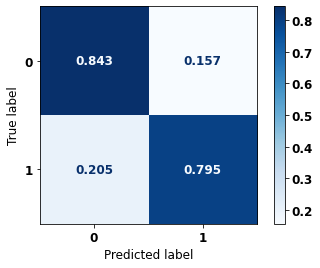


              precision    recall  f1-score   support

           0      0.688     0.843     0.758       510
           1      0.905     0.795     0.846       953

    accuracy                          0.812      1463
   macro avg      0.796     0.819     0.802      1463
weighted avg      0.829     0.812     0.816      1463



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

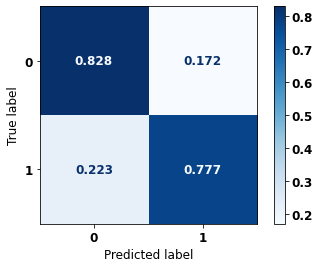


              precision    recall  f1-score   support

           0      0.637     0.828     0.720       571
           1      0.906     0.777     0.836      1211

    accuracy                          0.793      1782
   macro avg      0.771     0.803     0.778      1782
weighted avg      0.819     0.793     0.799      1782



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

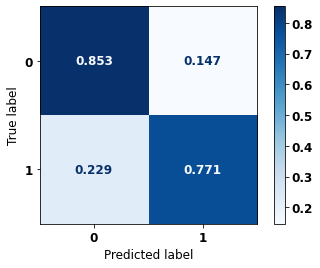


              precision    recall  f1-score   support

           0      0.820     0.853     0.836       539
           1      0.812     0.771     0.791       442

    accuracy                          0.817       981
   macro avg      0.816     0.812     0.814       981
weighted avg      0.816     0.817     0.816       981



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

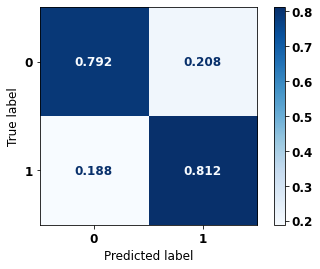


              precision    recall  f1-score   support

           0      0.665     0.792     0.723       571
           1      0.892     0.812     0.850      1211

    accuracy                          0.805      1782
   macro avg      0.778     0.802     0.786      1782
weighted avg      0.819     0.805     0.809      1782



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

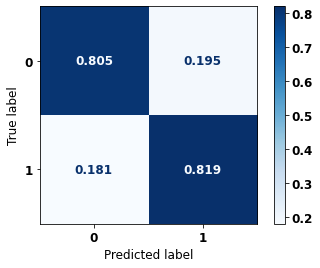


              precision    recall  f1-score   support

           0      0.844     0.805     0.824       539
           1      0.775     0.819     0.796       442

    accuracy                          0.811       981
   macro avg      0.810     0.812     0.810       981
weighted avg      0.813     0.811     0.812       981



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

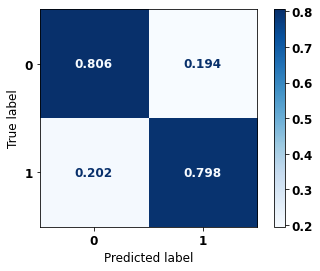


              precision    recall  f1-score   support

           0      0.652     0.806     0.721       571
           1      0.897     0.798     0.844      1211

    accuracy                          0.800      1782
   macro avg      0.775     0.802     0.783      1782
weighted avg      0.819     0.800     0.805      1782



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

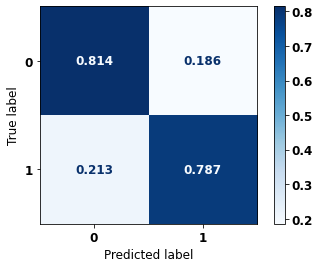


              precision    recall  f1-score   support

           0      0.824     0.814     0.819       539
           1      0.777     0.787     0.782       442

    accuracy                          0.802       981
   macro avg      0.800     0.801     0.801       981
weighted avg      0.803     0.802     0.802       981



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

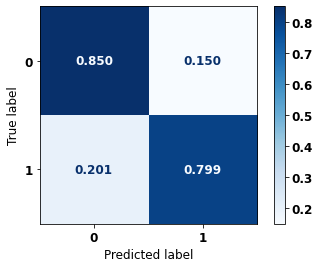


              precision    recall  f1-score   support

           0      0.837     0.850     0.843       539
           1      0.813     0.799     0.806       442

    accuracy                          0.827       981
   macro avg      0.825     0.824     0.825       981
weighted avg      0.827     0.827     0.827       981



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

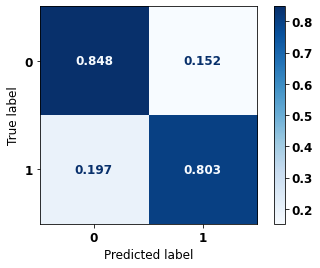


              precision    recall  f1-score   support

           0      0.840     0.848     0.844       539
           1      0.812     0.803     0.808       442

    accuracy                          0.828       981
   macro avg      0.826     0.826     0.826       981
weighted avg      0.828     0.828     0.828       981



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)

# **Fifth approach**

Approach with grouped years and without the columns `EC` and `HORMONIO`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano5',
             'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (45987, 64), X_test = (15329, 64)
y_train = (45987,), y_test = (15329,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (57801, 64), X_test = (19267, 64)
y_train = (57801,), y_test = (19267,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (77655, 64), X_test = (25886, 64)
y_train = (77655,), y_test = (25886,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (89562, 64), X_test = (29854, 64)
y_train = (89562,), y_test = (29854,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2021, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (35880, 64), X_test = (11961, 64)
y_train = (35880,), y_test = (11961,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2631, 64), X_test = (877, 64)
y_train = (2631,), y_test = (877,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3652, 64), X_test = (1218, 64)
y_train = (3652,), y_test = (1218,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4387, 64), X_test = (1463, 64)
y_train = (4387,), y_test = (1463,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (5346, 64), X_test = (1782, 64)
y_train = (5346,), y_test = (1782,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2020, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2943, 64), X_test = (981, 64)
y_train = (2943,), y_test = (981,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.405, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1.405, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

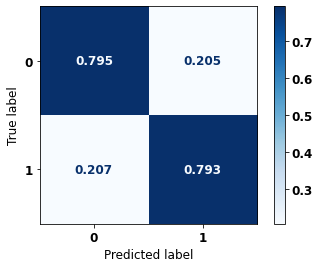


              precision    recall  f1-score   support

           0      0.738     0.795     0.765      6483
           1      0.841     0.793     0.816      8846

    accuracy                          0.794     15329
   macro avg      0.789     0.794     0.791     15329
weighted avg      0.797     0.794     0.795     15329



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


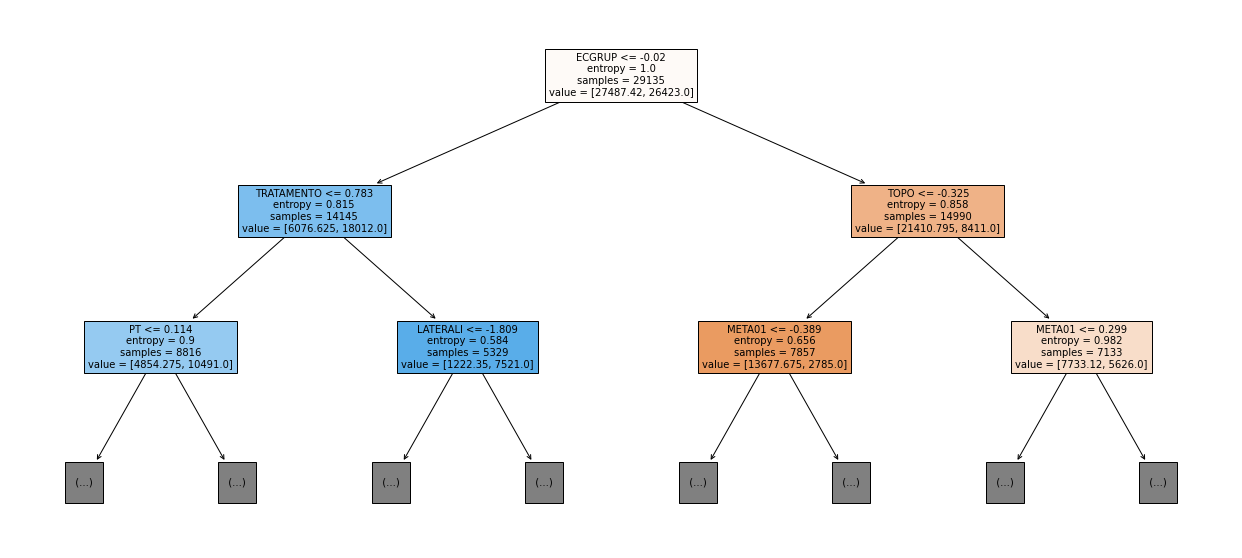

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

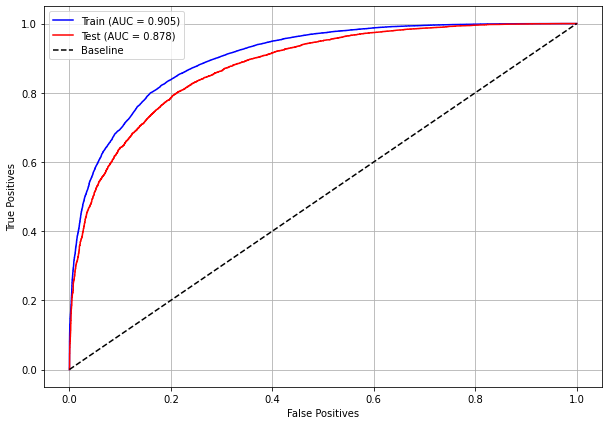

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

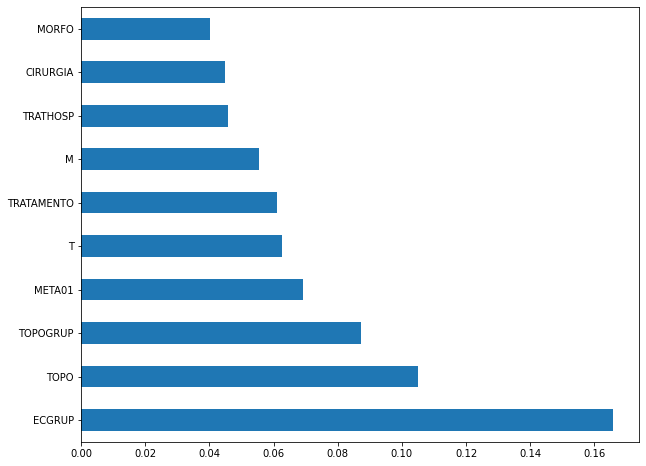

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP`, and `META01`. 

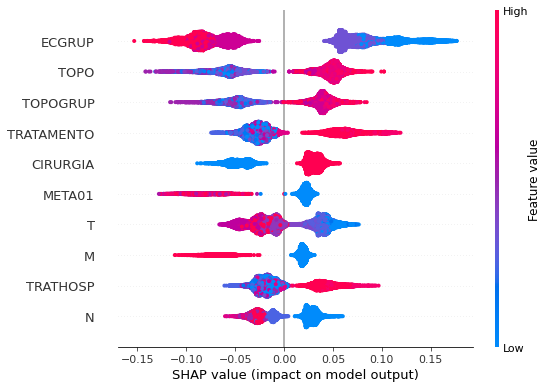

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.62, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.62, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

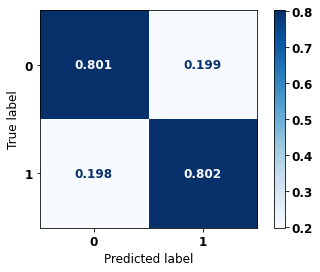


              precision    recall  f1-score   support

           0      0.724     0.801     0.760      7568
           1      0.862     0.802     0.831     11699

    accuracy                          0.802     19267
   macro avg      0.793     0.802     0.796     19267
weighted avg      0.808     0.802     0.803     19267



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.

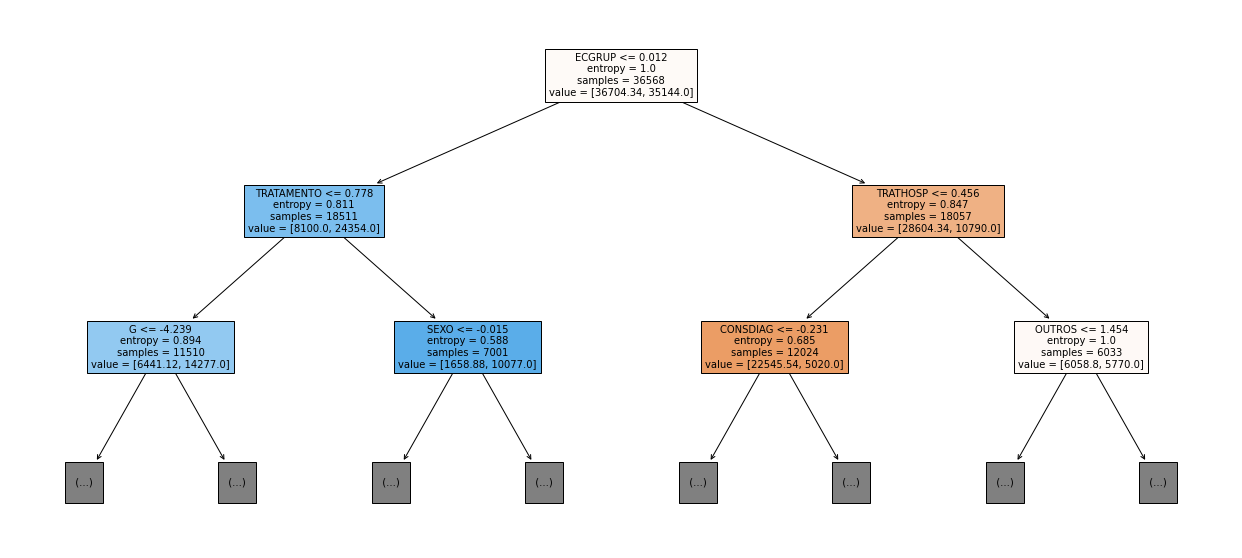

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

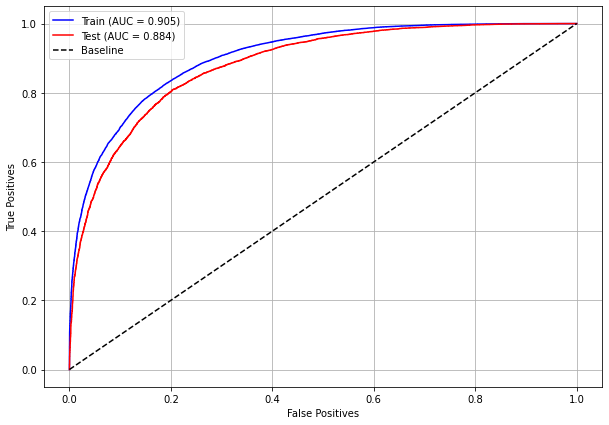

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

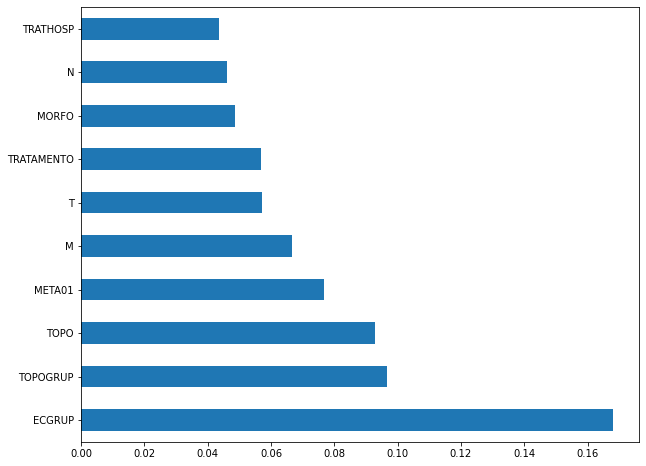

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `TOPO` and `META01`.

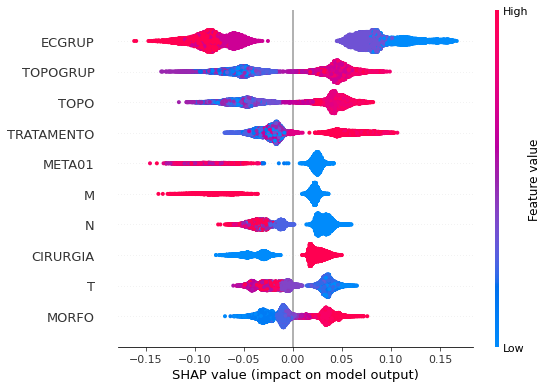

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.85, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1.85, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

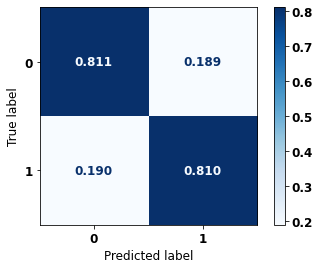


              precision    recall  f1-score   support

           0      0.717     0.811     0.761      9635
           1      0.879     0.810     0.843     16251

    accuracy                          0.811     25886
   macro avg      0.798     0.811     0.802     25886
weighted avg      0.818     0.811     0.813     25886



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuracy.

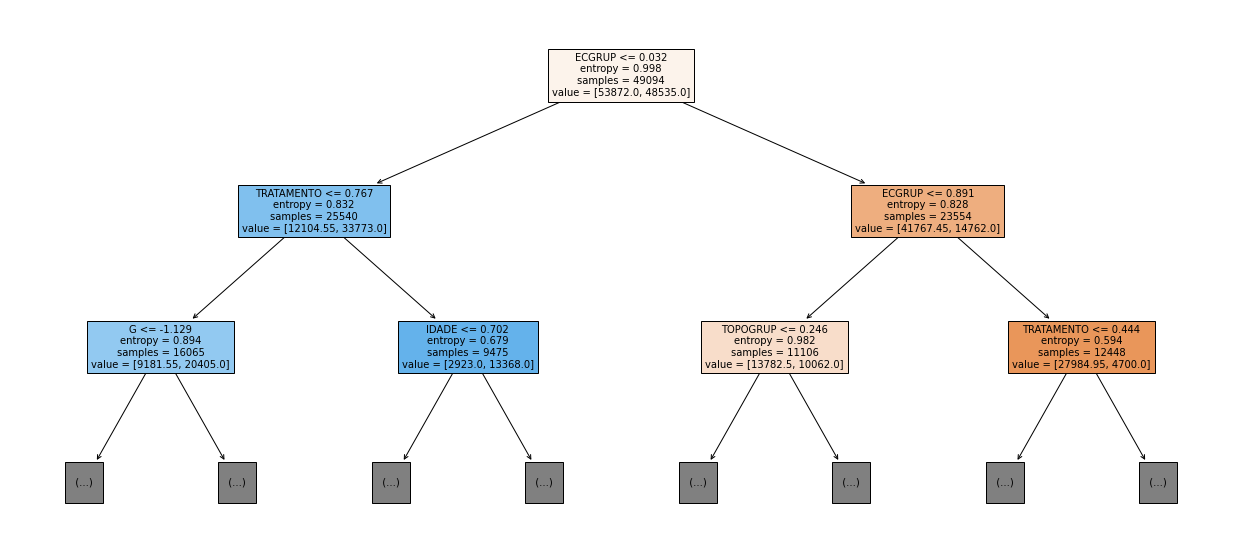

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

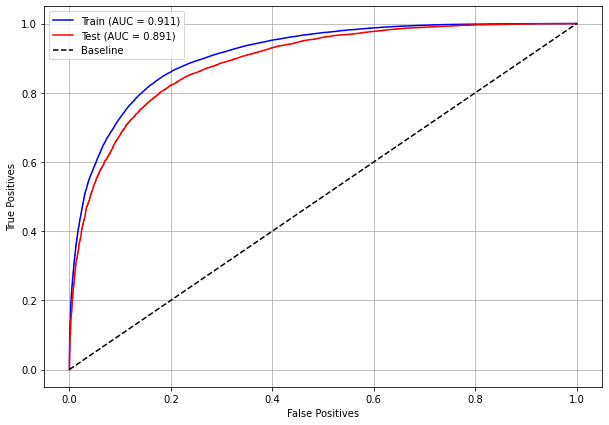

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

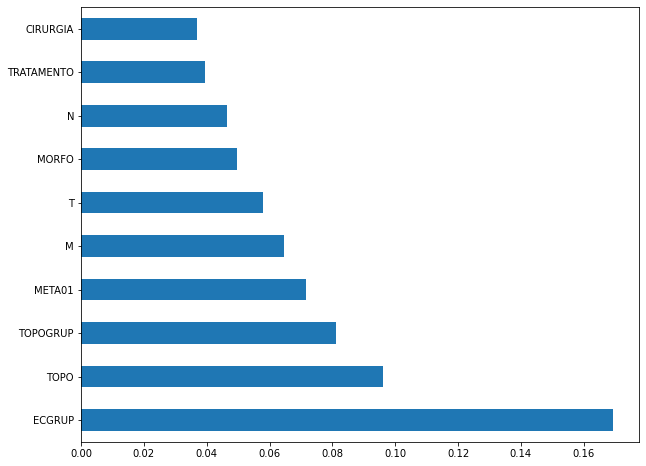

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `META01`.

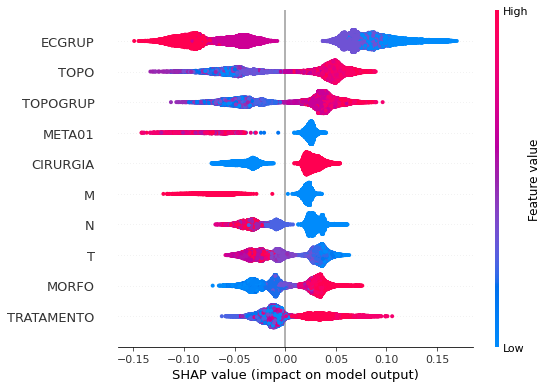

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:2.03, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 2.03, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

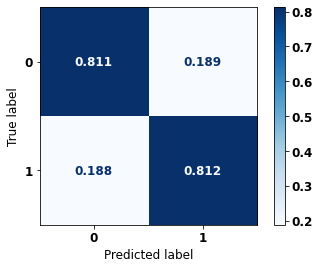


              precision    recall  f1-score   support

           0      0.703     0.811     0.753     10563
           1      0.887     0.812     0.848     19291

    accuracy                          0.812     29854
   macro avg      0.795     0.812     0.800     29854
weighted avg      0.822     0.812     0.814     29854



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 81% of accuracy.

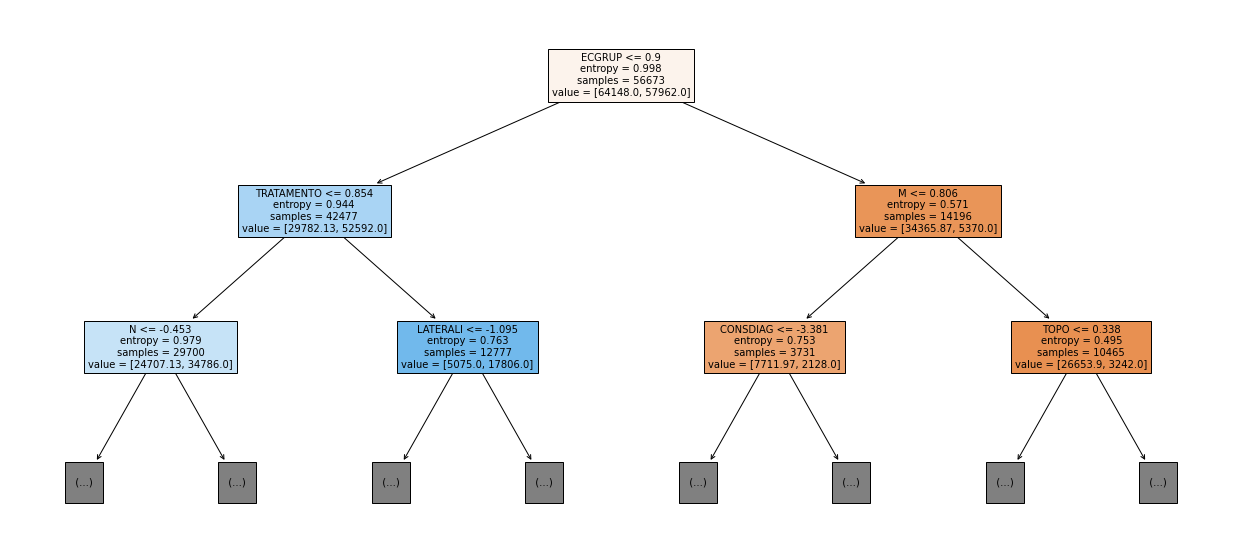

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

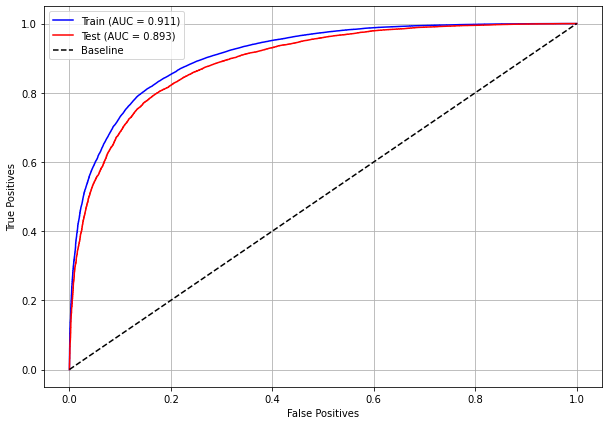

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

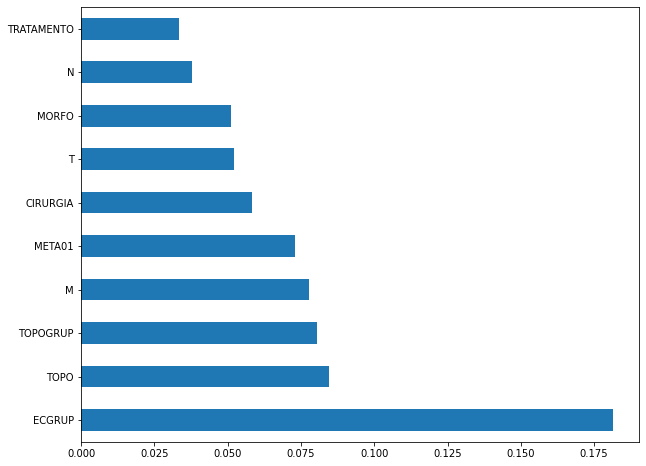

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `M`.

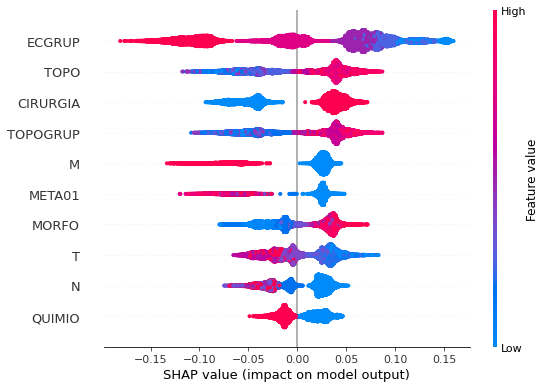

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.25},
                                     criterion='entropy', 
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 1.25}, criterion='entropy',
                       max_depth=10, random_state=10)

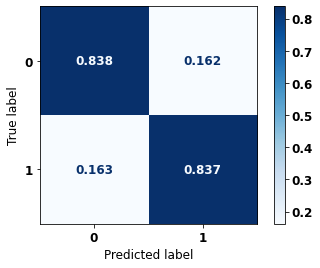


              precision    recall  f1-score   support

           0      0.870     0.838     0.854      6773
           1      0.798     0.837     0.817      5188

    accuracy                          0.837     11961
   macro avg      0.834     0.837     0.835     11961
weighted avg      0.839     0.837     0.838     11961



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 84% of accuracy.

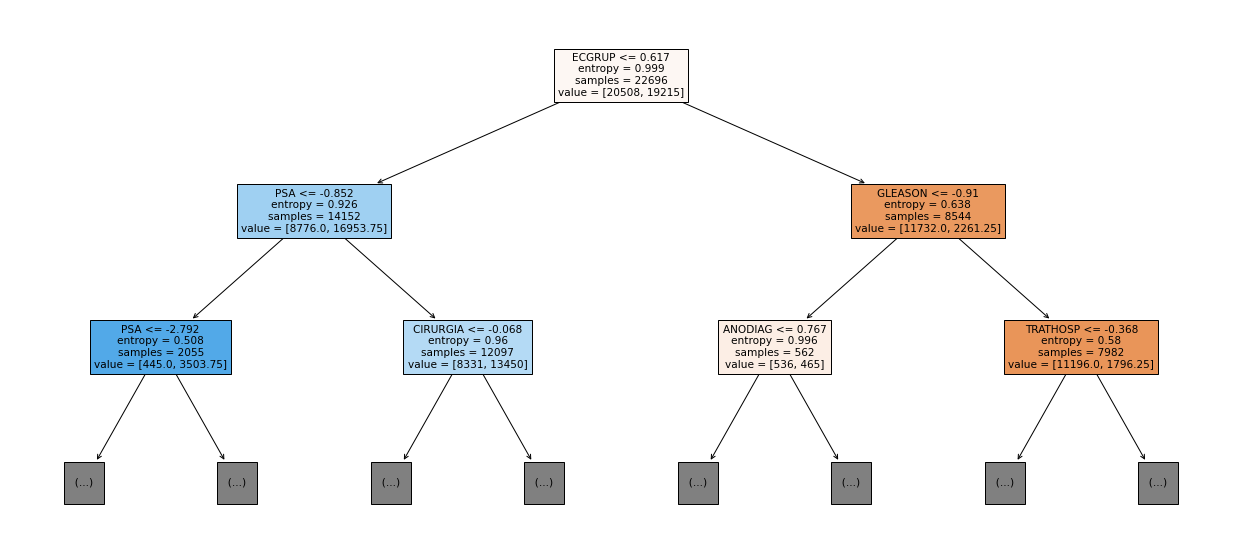

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

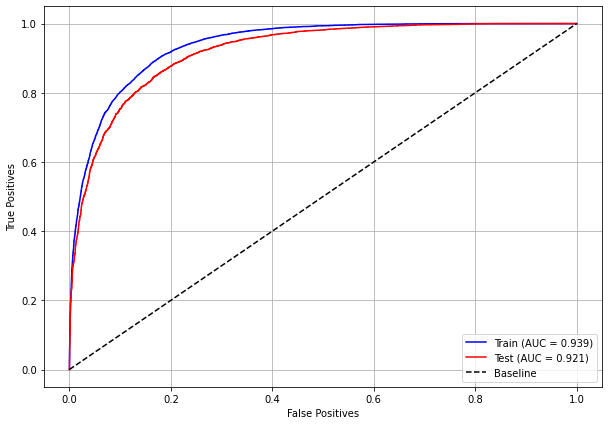

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

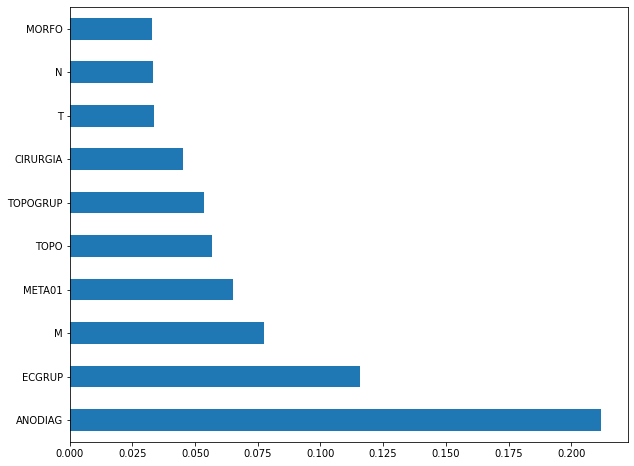

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ANODIAG`, `ECGRUP`, `M`, and `META01`.



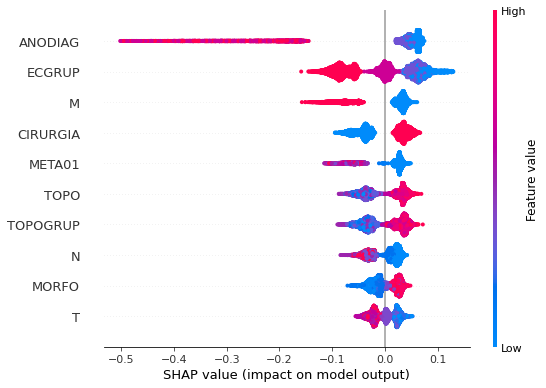

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.86, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.86, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

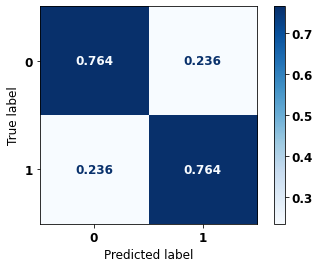


              precision    recall  f1-score   support

           0      0.684     0.764     0.721       351
           1      0.829     0.764     0.795       526

    accuracy                          0.764       877
   macro avg      0.756     0.764     0.758       877
weighted avg      0.771     0.764     0.766       877



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 76% of accuracy.

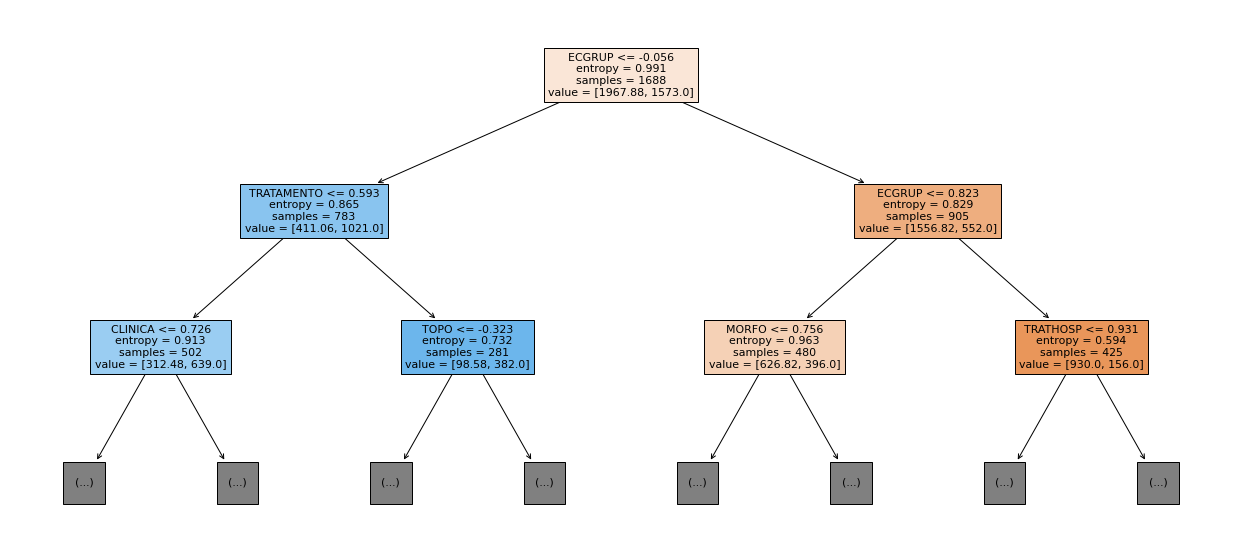

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

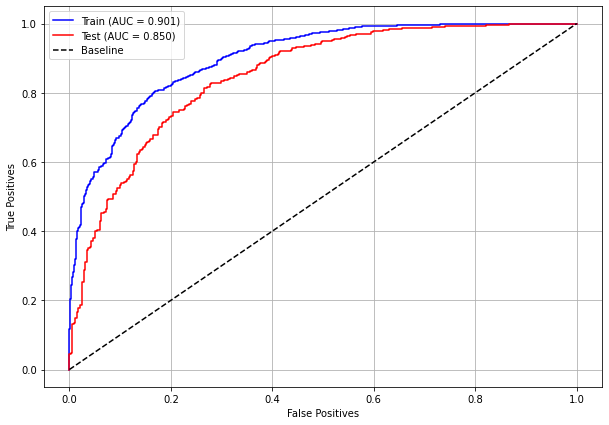

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

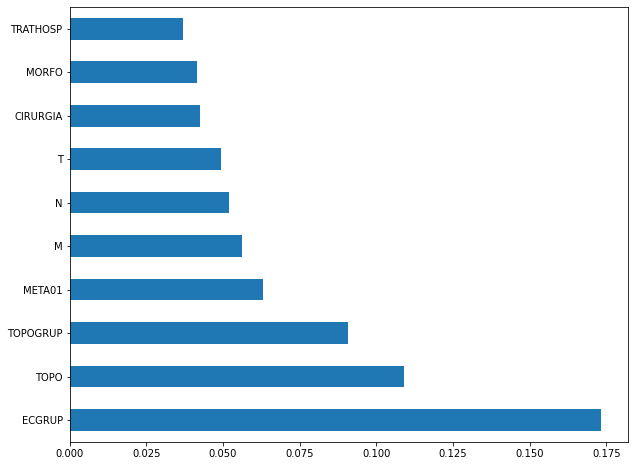

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `META01`.

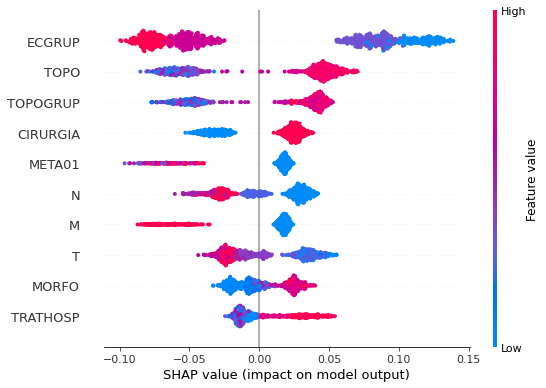

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.75, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1.75, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

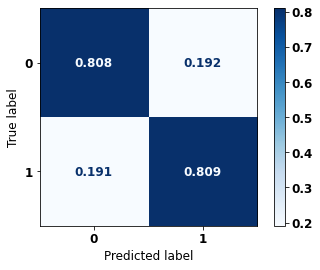


              precision    recall  f1-score   support

           0      0.708     0.808     0.754       443
           1      0.881     0.809     0.843       775

    accuracy                          0.809      1218
   macro avg      0.794     0.809     0.799      1218
weighted avg      0.818     0.809     0.811      1218



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 81% of accuracy.


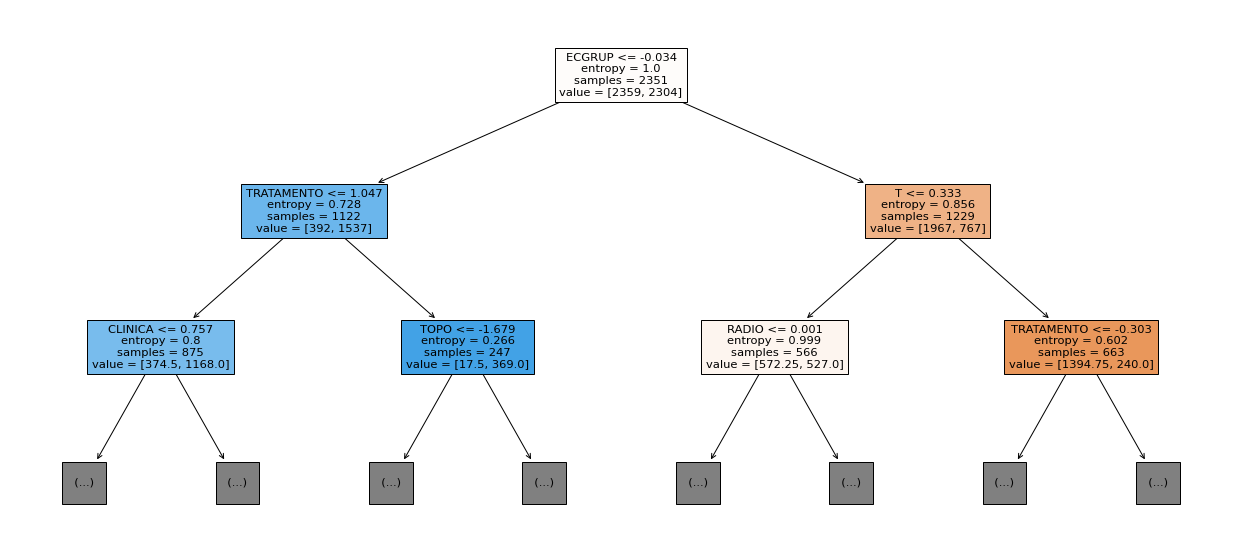

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

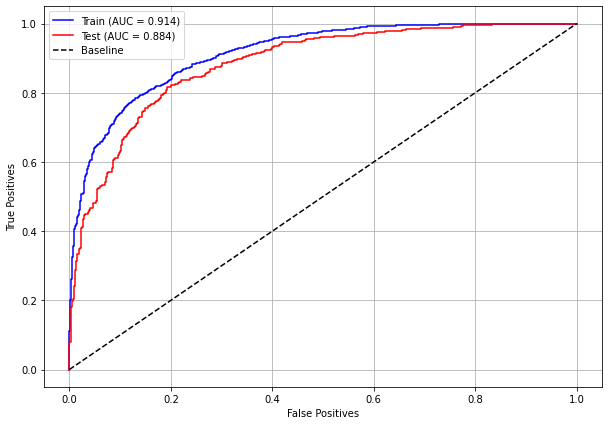

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

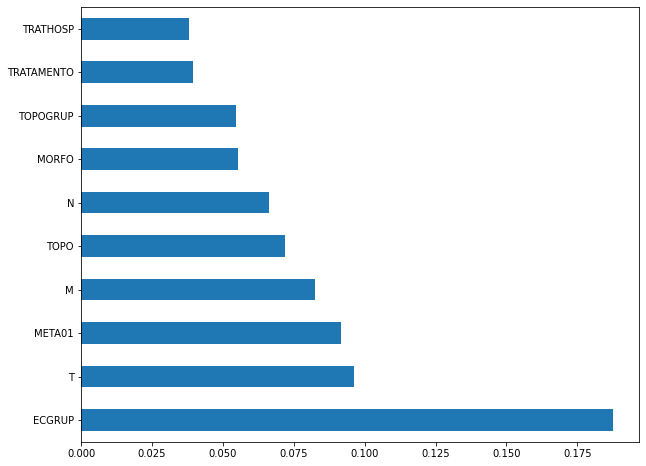

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `META01` and `M`.

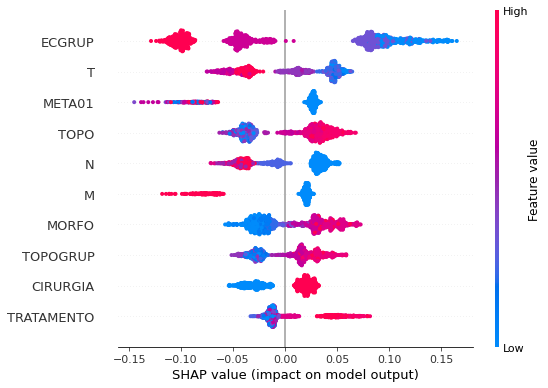

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:2.32, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 2.32, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

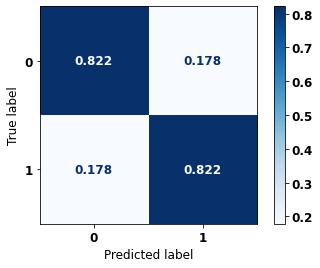


              precision    recall  f1-score   support

           0      0.711     0.822     0.763       510
           1      0.896     0.822     0.857       953

    accuracy                          0.822      1463
   macro avg      0.804     0.822     0.810      1463
weighted avg      0.832     0.822     0.824      1463



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 82% of accuracy.


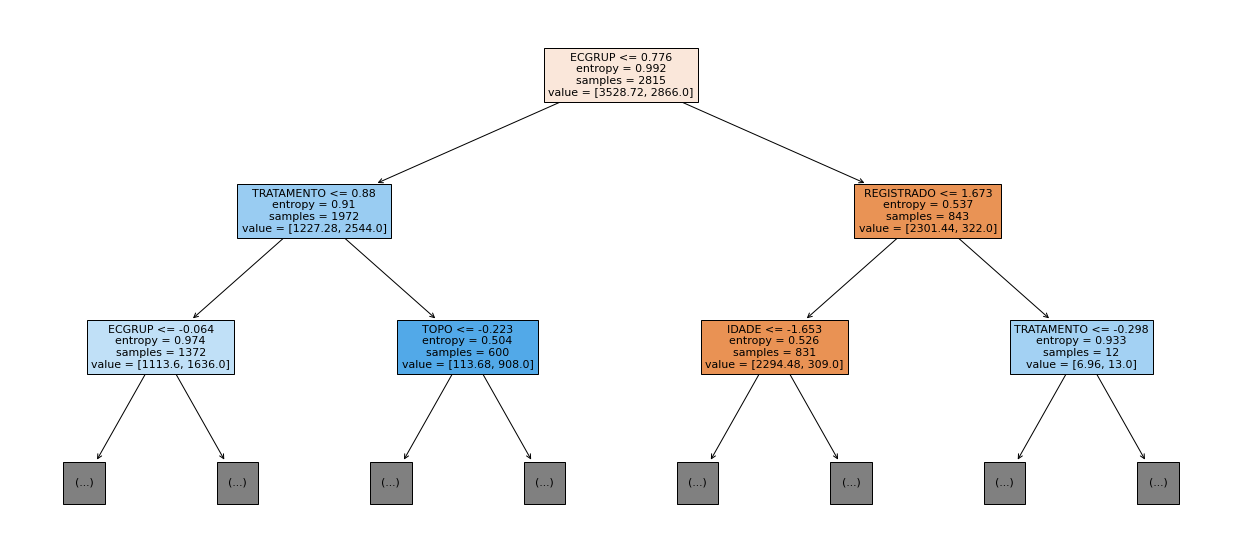

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

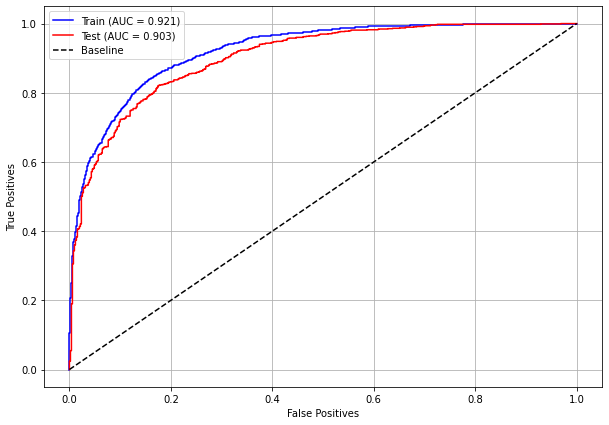

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

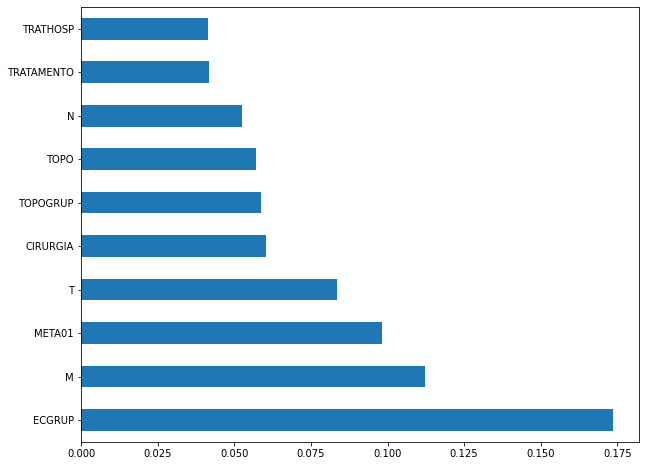

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `T`.

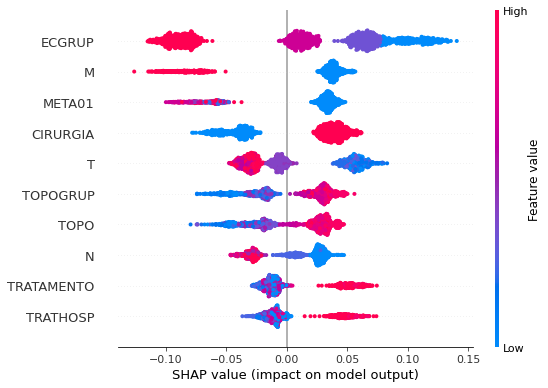

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:3.21, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 3.21, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

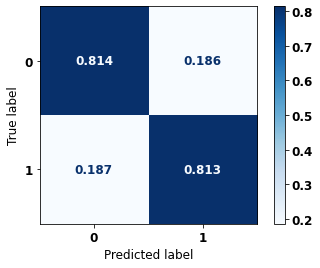


              precision    recall  f1-score   support

           0      0.673     0.814     0.737       571
           1      0.903     0.813     0.856      1211

    accuracy                          0.814      1782
   macro avg      0.788     0.814     0.796      1782
weighted avg      0.829     0.814     0.818      1782



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 81% of accuracy.


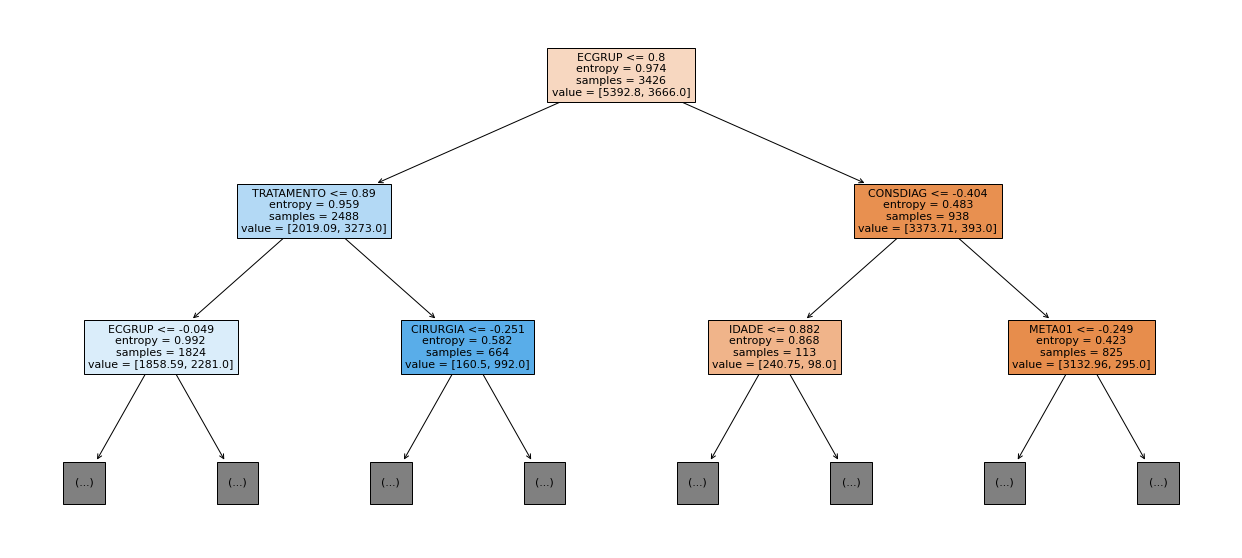

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

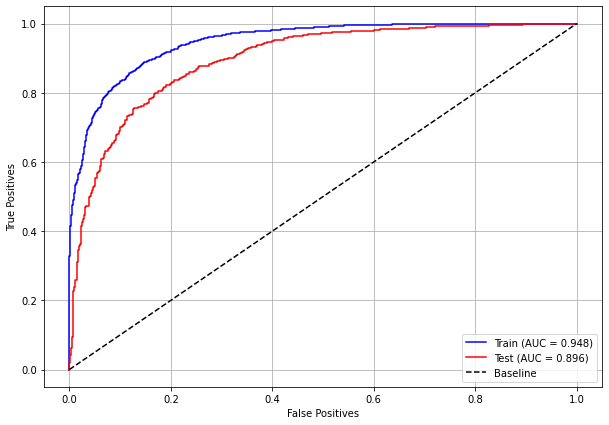

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

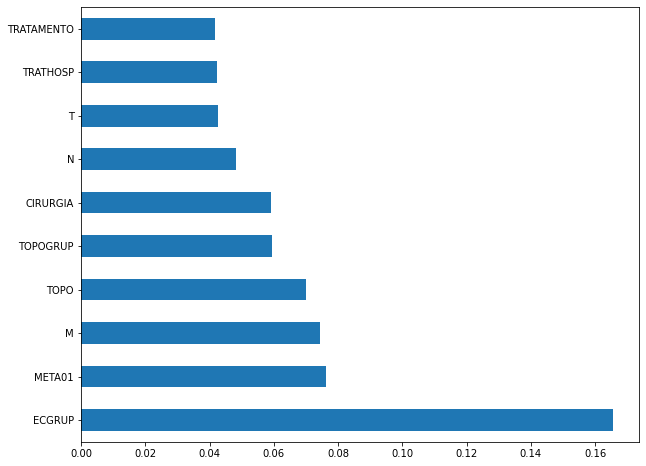

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `META01`, `M` and `TOPO`.

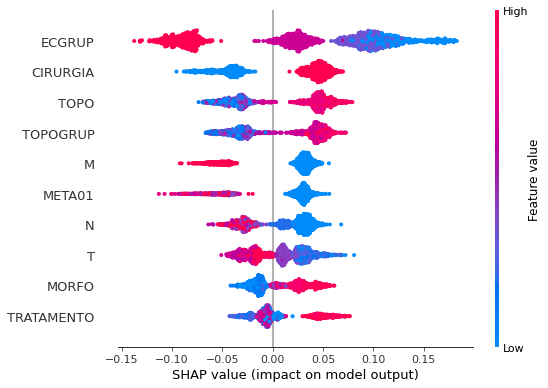

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.09},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 1.09}, criterion='entropy',
                       max_depth=8, random_state=10)

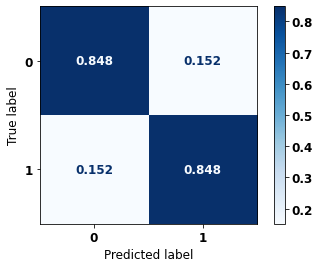


              precision    recall  f1-score   support

           0      0.872     0.848     0.860       539
           1      0.821     0.848     0.834       442

    accuracy                          0.848       981
   macro avg      0.846     0.848     0.847       981
weighted avg      0.849     0.848     0.848       981



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 85% of accuracy.


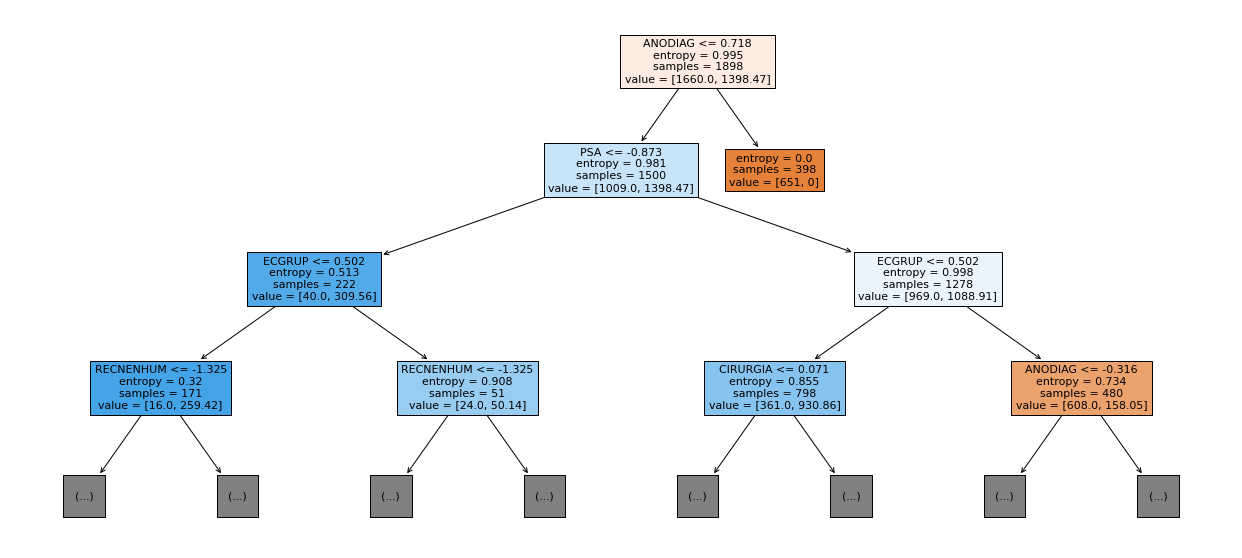

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 3)

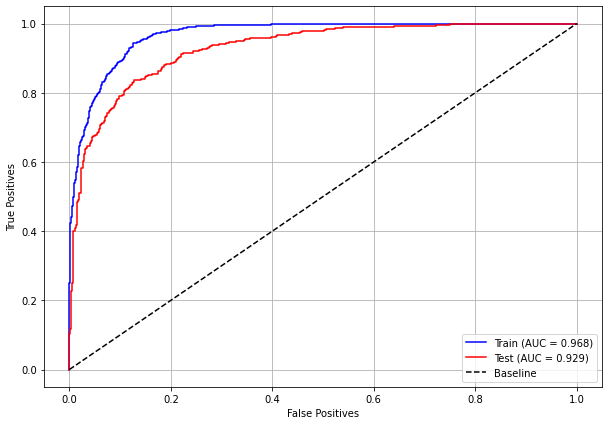

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

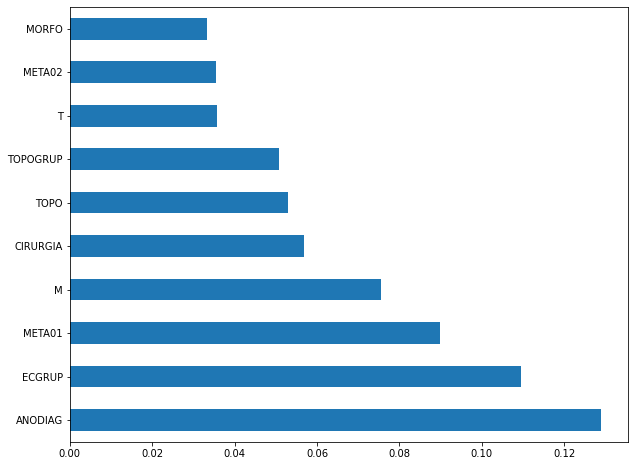

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ANODIAG`, `ECGRUP`, `META01` and `M`.

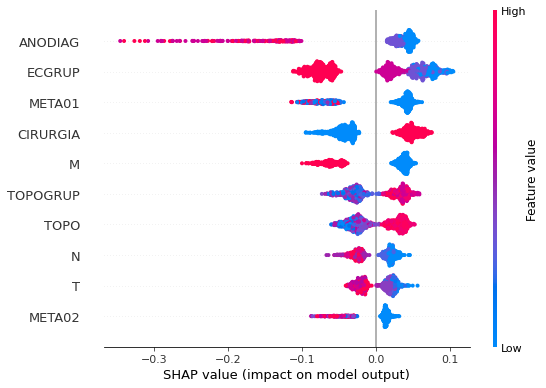

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.7)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.7)

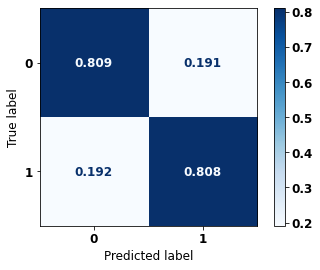


              precision    recall  f1-score   support

           0      0.755     0.809     0.781      6483
           1      0.852     0.808     0.830      8846

    accuracy                          0.808     15329
   macro avg      0.804     0.809     0.805     15329
weighted avg      0.811     0.808     0.809     15329



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 81% of accuracy.

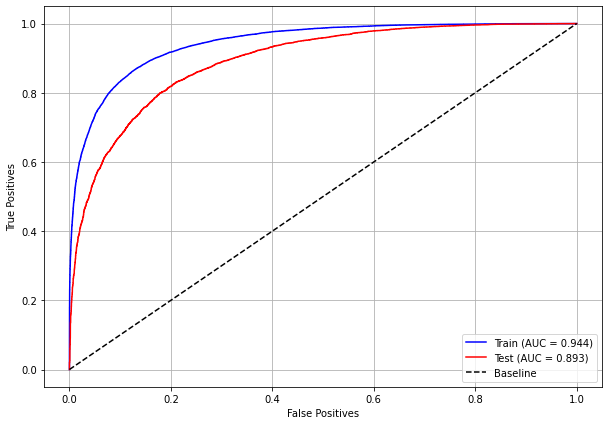

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

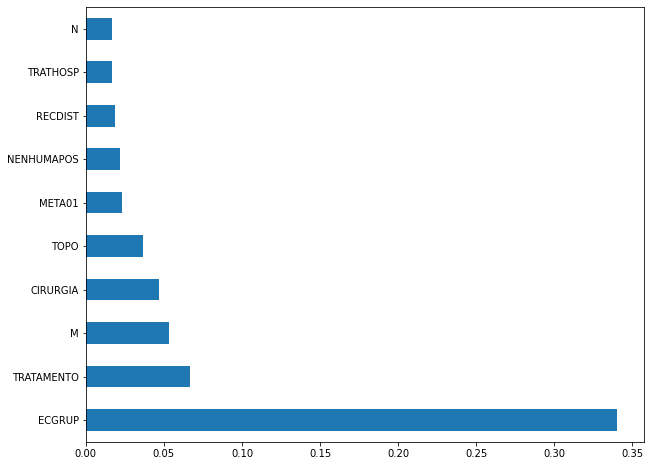

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `TRATAMENTO`, `M` and `CIRURGIA`.

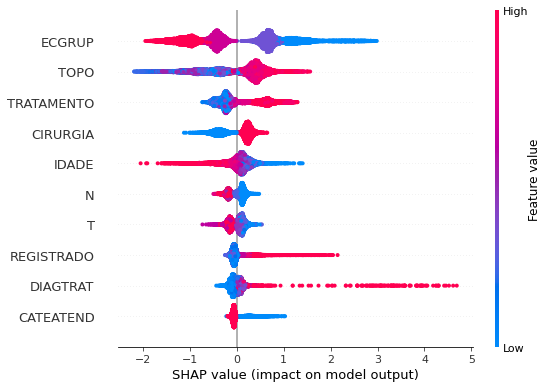

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.619)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.619)

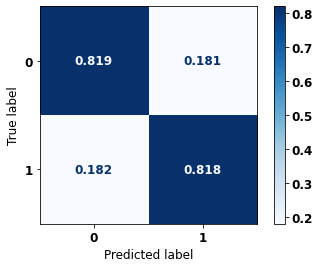


              precision    recall  f1-score   support

           0      0.744     0.819     0.779      7568
           1      0.874     0.818     0.845     11699

    accuracy                          0.818     19267
   macro avg      0.809     0.818     0.812     19267
weighted avg      0.823     0.818     0.819     19267



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 82% of accuracy.


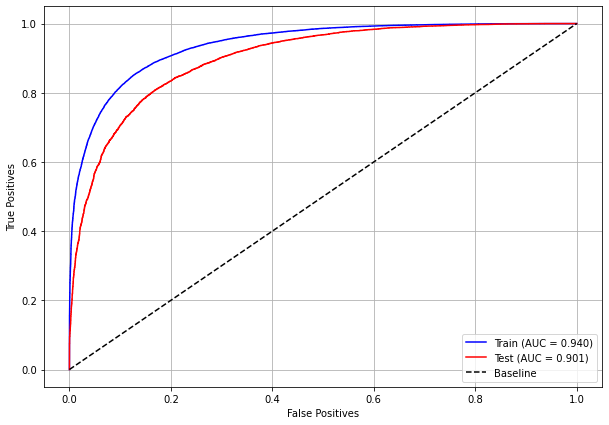

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

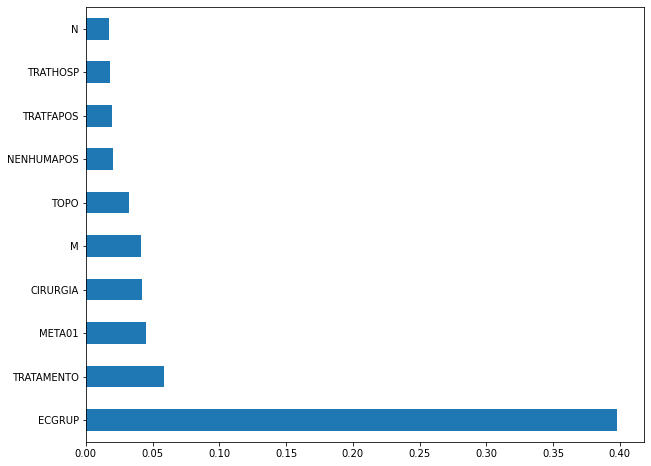

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `TRATAMENTO`, `META01` and `CIRURGIA`. 

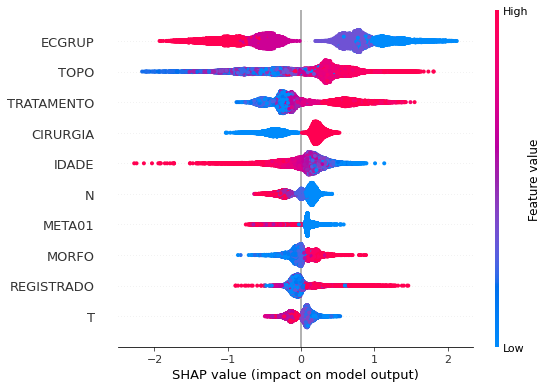

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=0.55,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.55)

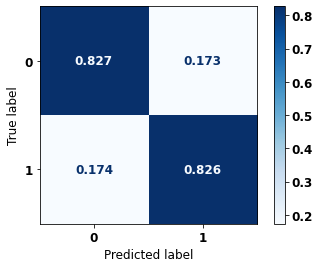


              precision    recall  f1-score   support

           0      0.738     0.827     0.780      9635
           1      0.889     0.826     0.857     16251

    accuracy                          0.826     25886
   macro avg      0.814     0.826     0.818     25886
weighted avg      0.833     0.826     0.828     25886



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

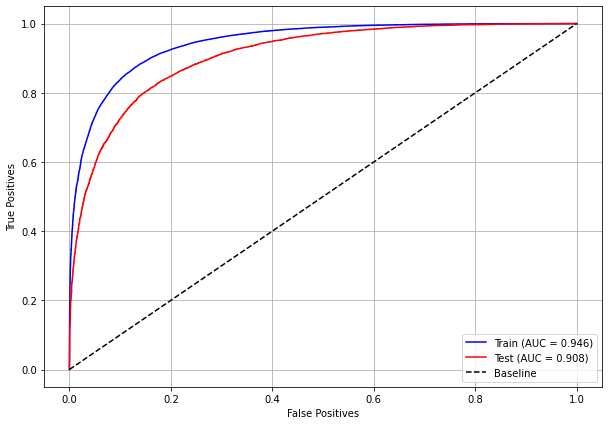

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

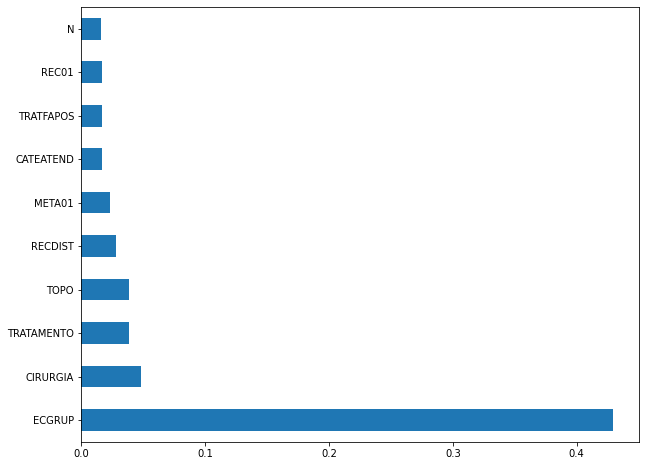

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `CIRURGIA`, `TRATAMENTO` and `TOPO`. 

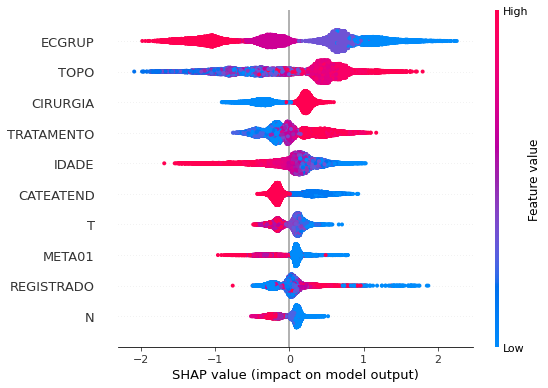

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=0.515)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.515)

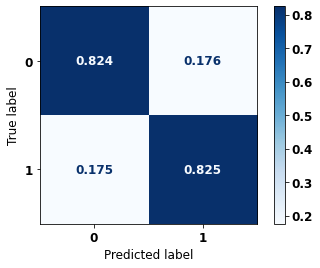


              precision    recall  f1-score   support

           0      0.720     0.824     0.769     10563
           1      0.895     0.825     0.859     19291

    accuracy                          0.824     29854
   macro avg      0.808     0.824     0.814     29854
weighted avg      0.833     0.824     0.827     29854



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

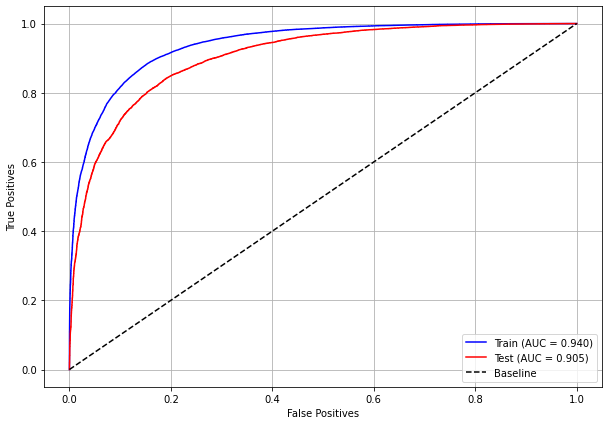

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

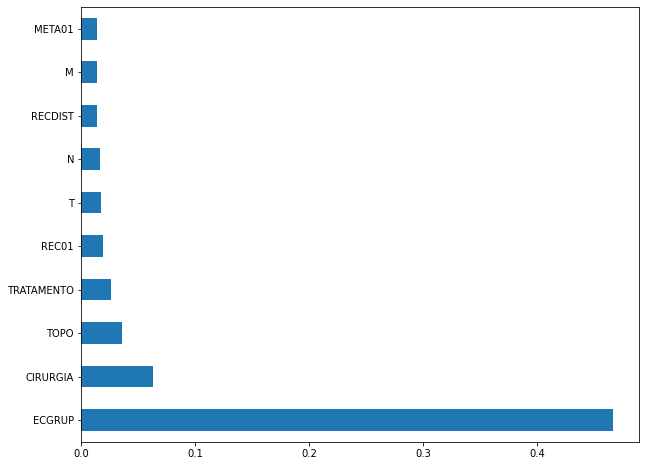

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `CIRURGIA`, `TOPO` and `TRATAMENTO`. 

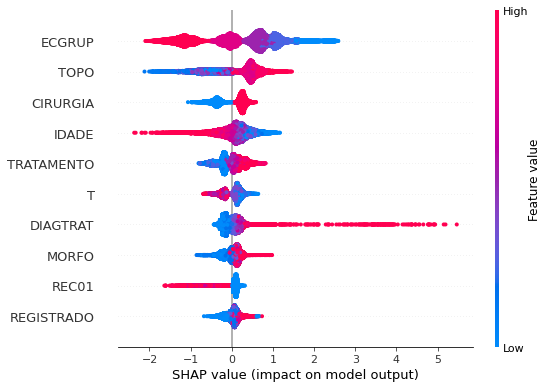

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.28)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.28)

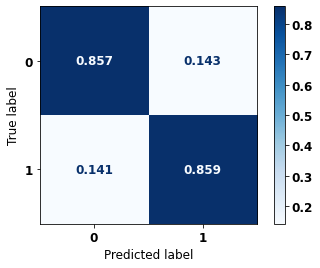


              precision    recall  f1-score   support

           0      0.888     0.857     0.872      6773
           1      0.821     0.859     0.840      5188

    accuracy                          0.858     11961
   macro avg      0.855     0.858     0.856     11961
weighted avg      0.859     0.858     0.858     11961



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 86% of accuracy.


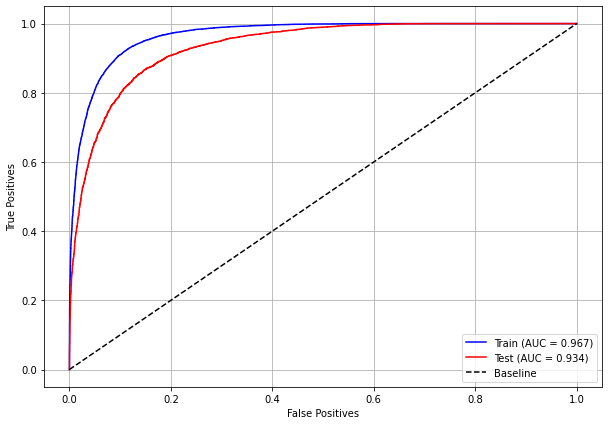

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

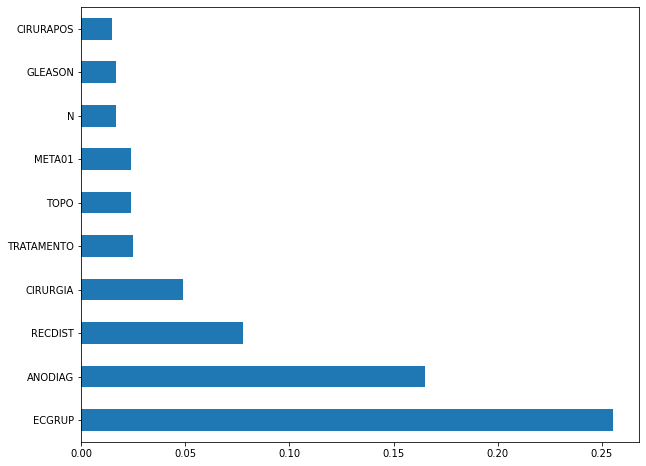

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `ANODIAG`, `RECDIST` and `CIRURGIA`.

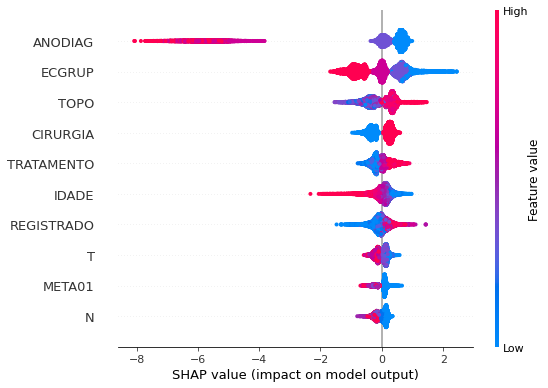

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.528,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.528)

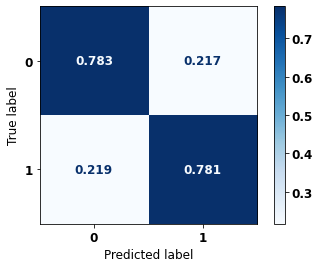


              precision    recall  f1-score   support

           0      0.705     0.783     0.742       351
           1      0.844     0.781     0.811       526

    accuracy                          0.782       877
   macro avg      0.775     0.782     0.777       877
weighted avg      0.788     0.782     0.784       877



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 78% of accuracy.

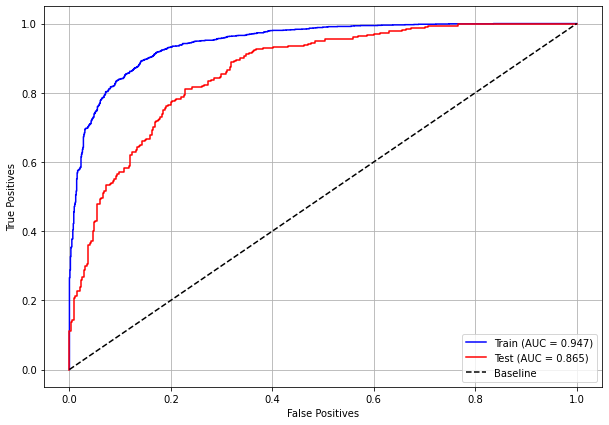

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

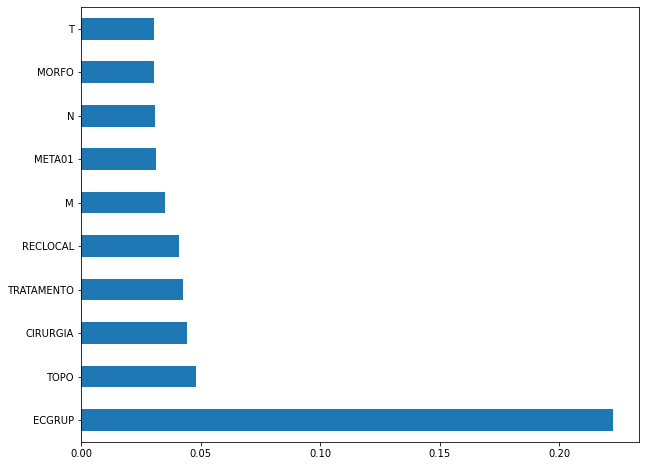

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `TOPO`, `CIRURGIA` and `TRATAMENTO`.

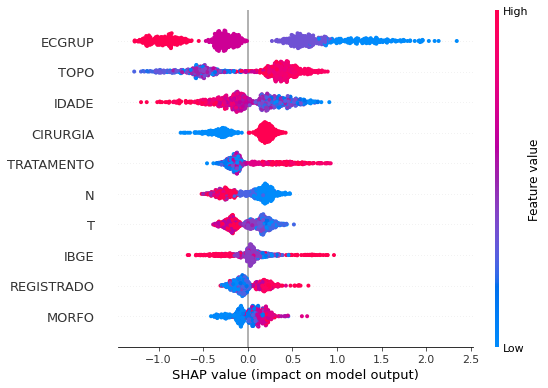

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.62,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.62)

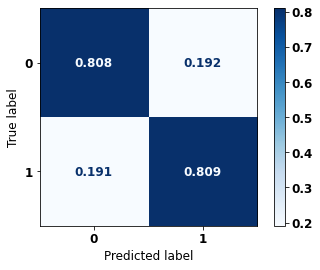


              precision    recall  f1-score   support

           0      0.708     0.808     0.754       443
           1      0.881     0.809     0.843       775

    accuracy                          0.809      1218
   macro avg      0.794     0.809     0.799      1218
weighted avg      0.818     0.809     0.811      1218



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 81% of accuracy.

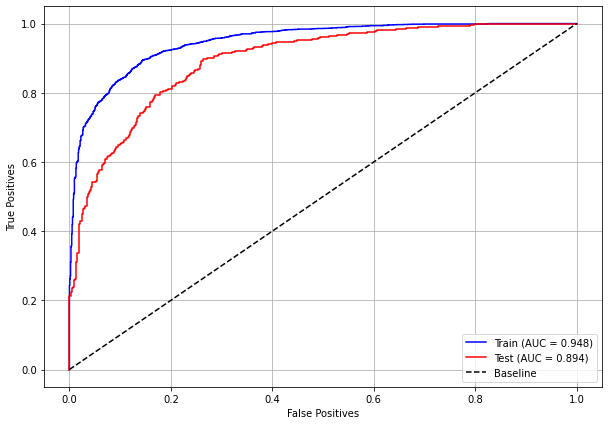

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

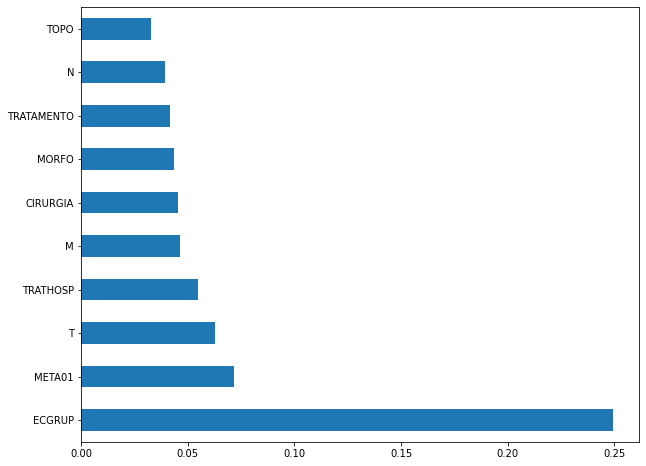

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `META01`, `T` and `TRATHOSP`.

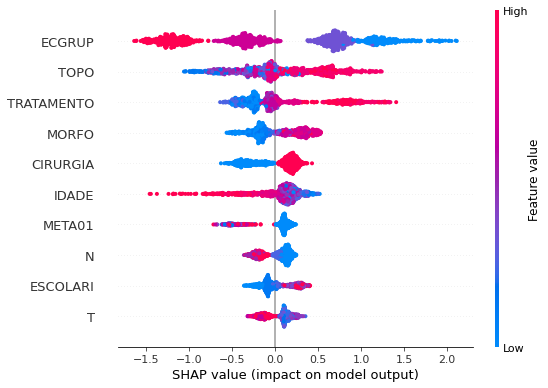

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.5,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.5)

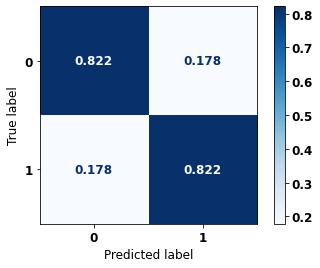


              precision    recall  f1-score   support

           0      0.711     0.822     0.763       510
           1      0.896     0.822     0.857       953

    accuracy                          0.822      1463
   macro avg      0.804     0.822     0.810      1463
weighted avg      0.832     0.822     0.824      1463



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 82% of accuracy.

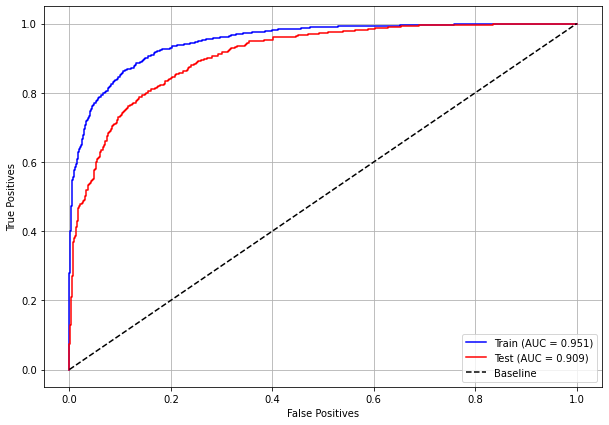

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

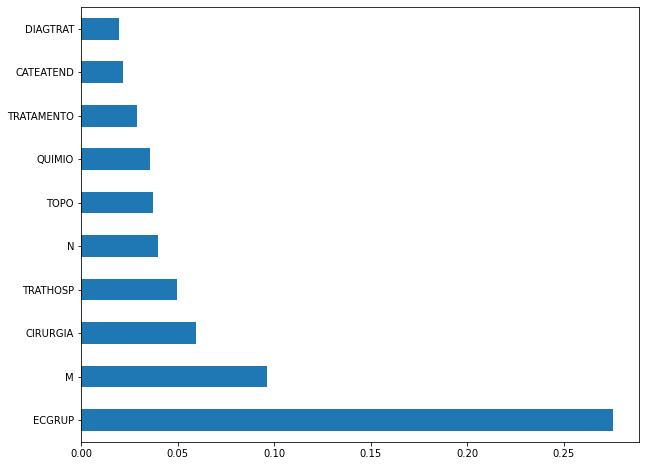

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `CIRURGIA` and `TRATHOSP`.

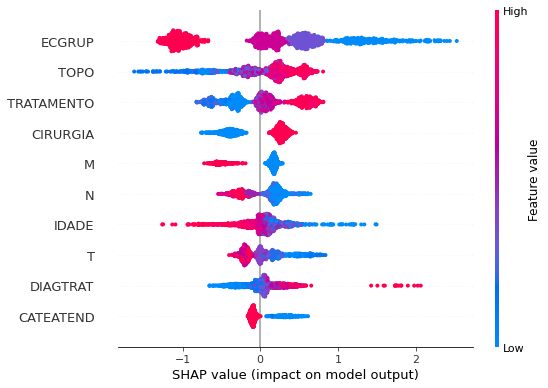

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.36,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.36)

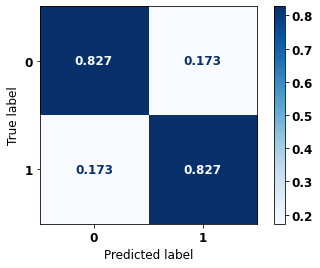


              precision    recall  f1-score   support

           0      0.693     0.827     0.754       571
           1      0.910     0.827     0.867      1211

    accuracy                          0.827      1782
   macro avg      0.802     0.827     0.810      1782
weighted avg      0.841     0.827     0.831      1782



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 83% of accuracy.

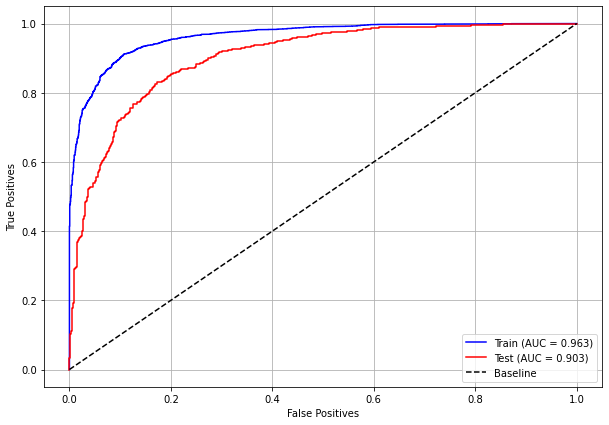

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

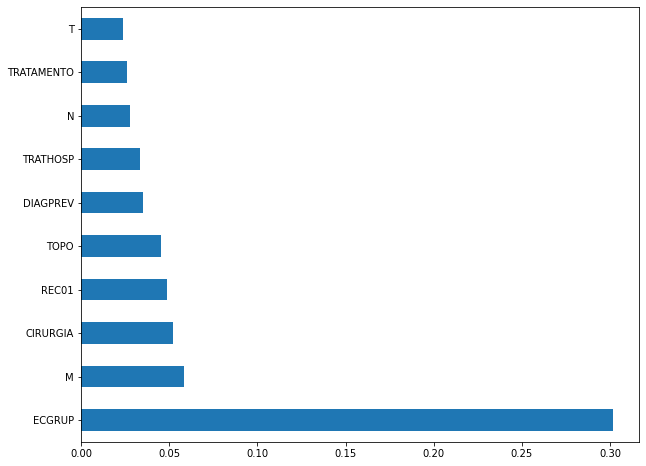

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `M`, `CIRURGIA` and `REC01`.

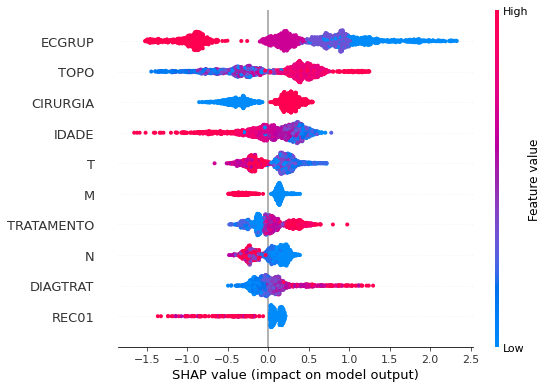

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.02,
                               random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.02)

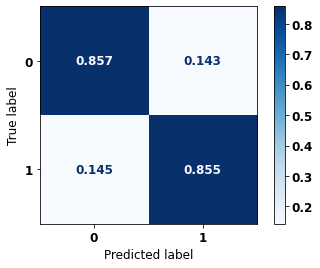


              precision    recall  f1-score   support

           0      0.878     0.857     0.868       539
           1      0.831     0.855     0.843       442

    accuracy                          0.856       981
   macro avg      0.855     0.856     0.855       981
weighted avg      0.857     0.856     0.856       981



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 86% of accuracy.

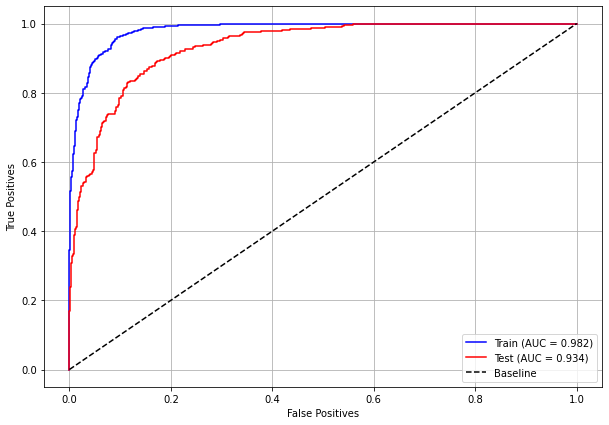

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

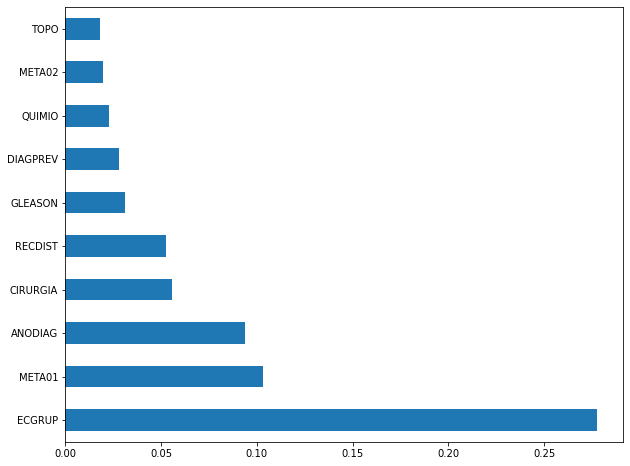

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `META01`, `ANODIAG` and `CIRURGIA`.

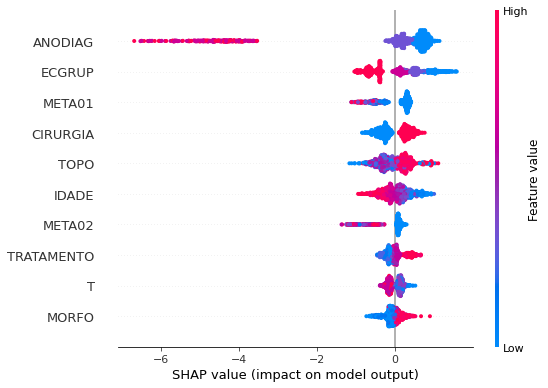

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

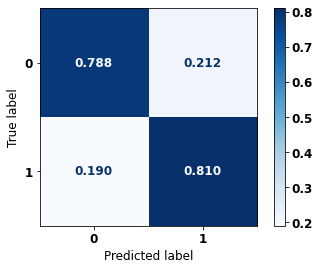


              precision    recall  f1-score   support

           0      0.728     0.788     0.757      7568
           1      0.855     0.810     0.832     11699

    accuracy                          0.801     19267
   macro avg      0.791     0.799     0.794     19267
weighted avg      0.805     0.801     0.802     19267



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

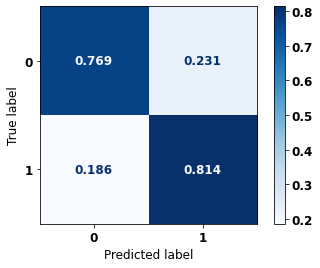


              precision    recall  f1-score   support

           0      0.711     0.769     0.739      9635
           1      0.856     0.814     0.835     16251

    accuracy                          0.798     25886
   macro avg      0.783     0.792     0.787     25886
weighted avg      0.802     0.798     0.799     25886



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

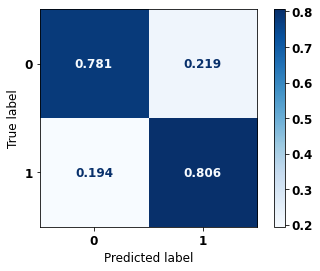


              precision    recall  f1-score   support

           0      0.688     0.781     0.732     10563
           1      0.871     0.806     0.837     19291

    accuracy                          0.797     29854
   macro avg      0.779     0.794     0.784     29854
weighted avg      0.806     0.797     0.800     29854



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

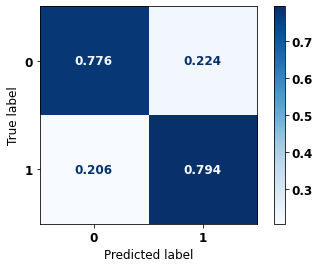


              precision    recall  f1-score   support

           0      0.831     0.776     0.803      6773
           1      0.731     0.794     0.761      5188

    accuracy                          0.784     11961
   macro avg      0.781     0.785     0.782     11961
weighted avg      0.788     0.784     0.785     11961



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

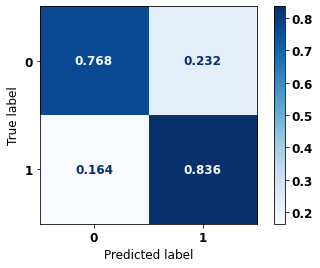


              precision    recall  f1-score   support

           0      0.752     0.768     0.760      7568
           1      0.848     0.836     0.842     11699

    accuracy                          0.810     19267
   macro avg      0.800     0.802     0.801     19267
weighted avg      0.810     0.810     0.810     19267



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

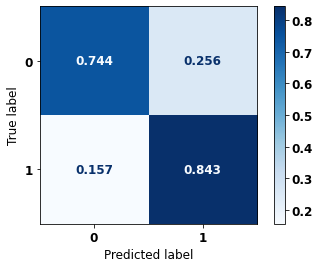


              precision    recall  f1-score   support

           0      0.737     0.744     0.741      9635
           1      0.848     0.843     0.845     16251

    accuracy                          0.806     25886
   macro avg      0.793     0.794     0.793     25886
weighted avg      0.807     0.806     0.806     25886



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

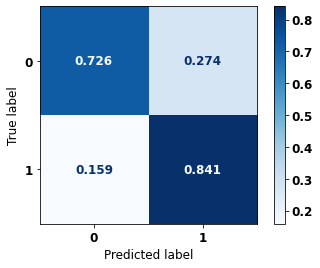


              precision    recall  f1-score   support

           0      0.715     0.726     0.720     10563
           1      0.849     0.841     0.845     19291

    accuracy                          0.801     29854
   macro avg      0.782     0.784     0.783     29854
weighted avg      0.801     0.801     0.801     29854



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

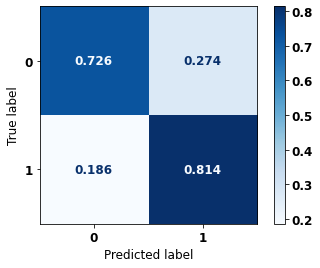


              precision    recall  f1-score   support

           0      0.836     0.726     0.777      6773
           1      0.695     0.814     0.750      5188

    accuracy                          0.764     11961
   macro avg      0.765     0.770     0.764     11961
weighted avg      0.775     0.764     0.765     11961



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

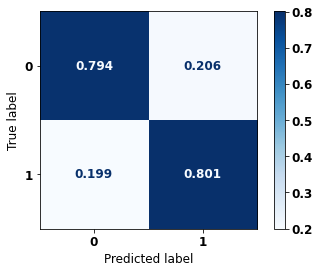


              precision    recall  f1-score   support

           0      0.703     0.794     0.746      9635
           1      0.868     0.801     0.833     16251

    accuracy                          0.798     25886
   macro avg      0.785     0.797     0.789     25886
weighted avg      0.806     0.798     0.800     25886



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

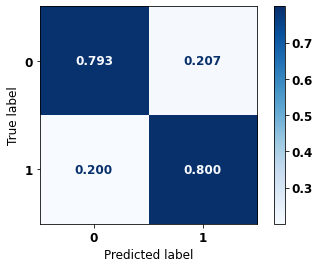


              precision    recall  f1-score   support

           0      0.684     0.793     0.734     10563
           1      0.876     0.800     0.836     19291

    accuracy                          0.797     29854
   macro avg      0.780     0.796     0.785     29854
weighted avg      0.808     0.797     0.800     29854



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

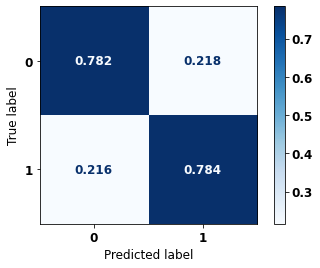


              precision    recall  f1-score   support

           0      0.826     0.782     0.803      6773
           1      0.734     0.784     0.758      5188

    accuracy                          0.783     11961
   macro avg      0.780     0.783     0.781     11961
weighted avg      0.786     0.783     0.784     11961



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

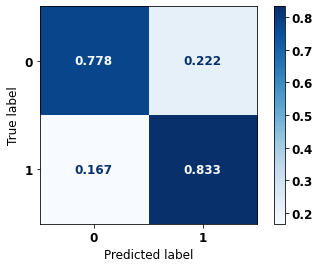


              precision    recall  f1-score   support

           0      0.735     0.778     0.756      9635
           1      0.864     0.833     0.848     16251

    accuracy                          0.813     25886
   macro avg      0.799     0.806     0.802     25886
weighted avg      0.816     0.813     0.814     25886



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

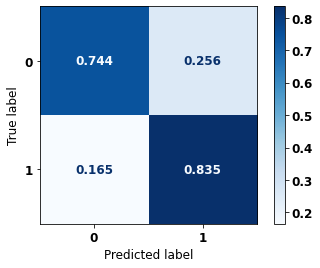


              precision    recall  f1-score   support

           0      0.712     0.744     0.728     10563
           1      0.856     0.835     0.846     19291

    accuracy                          0.803     29854
   macro avg      0.784     0.790     0.787     29854
weighted avg      0.805     0.803     0.804     29854



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

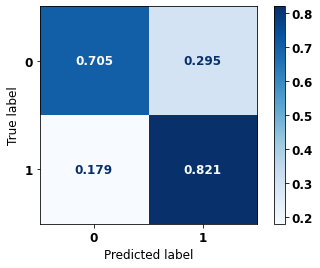


              precision    recall  f1-score   support

           0      0.837     0.705     0.765      6773
           1      0.681     0.821     0.744      5188

    accuracy                          0.755     11961
   macro avg      0.759     0.763     0.755     11961
weighted avg      0.769     0.755     0.756     11961



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

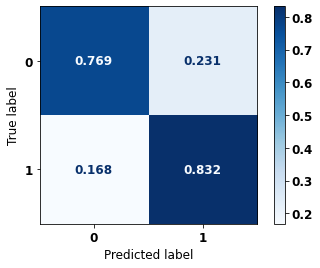


              precision    recall  f1-score   support

           0      0.715     0.769     0.741     10563
           1      0.868     0.832     0.850     19291

    accuracy                          0.810     29854
   macro avg      0.792     0.801     0.796     29854
weighted avg      0.814     0.810     0.812     29854



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

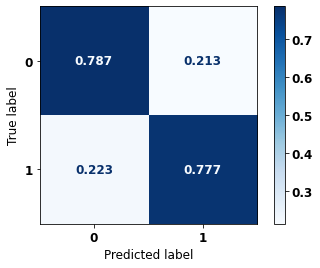


              precision    recall  f1-score   support

           0      0.821     0.787     0.804      6773
           1      0.736     0.777     0.756      5188

    accuracy                          0.782     11961
   macro avg      0.779     0.782     0.780     11961
weighted avg      0.784     0.782     0.783     11961



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

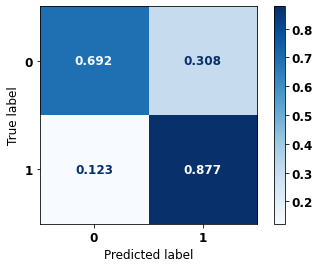


              precision    recall  f1-score   support

           0      0.756     0.692     0.722     10563
           1      0.839     0.877     0.858     19291

    accuracy                          0.812     29854
   macro avg      0.797     0.785     0.790     29854
weighted avg      0.809     0.812     0.810     29854



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

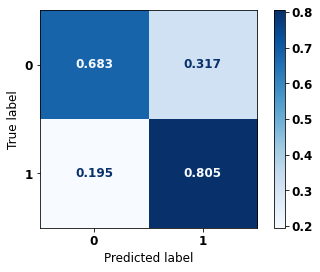


              precision    recall  f1-score   support

           0      0.820     0.683     0.745      6773
           1      0.660     0.805     0.725      5188

    accuracy                          0.735     11961
   macro avg      0.740     0.744     0.735     11961
weighted avg      0.751     0.735     0.736     11961



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

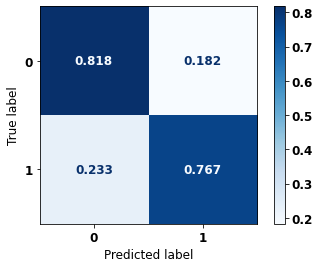


              precision    recall  f1-score   support

           0      0.821     0.818     0.819      6773
           1      0.763     0.767     0.765      5188

    accuracy                          0.796     11961
   macro avg      0.792     0.792     0.792     11961
weighted avg      0.796     0.796     0.796     11961



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

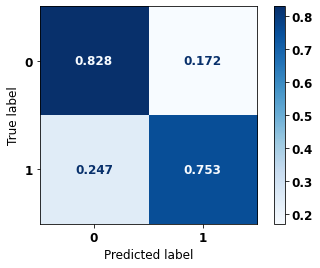


              precision    recall  f1-score   support

           0      0.814     0.828     0.821      6773
           1      0.771     0.753     0.762      5188

    accuracy                          0.796     11961
   macro avg      0.793     0.791     0.792     11961
weighted avg      0.795     0.796     0.796     11961



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

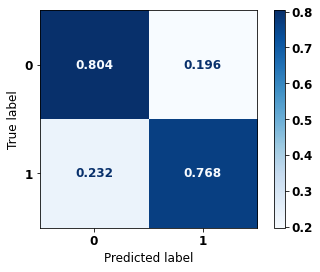


              precision    recall  f1-score   support

           0      0.664     0.804     0.727       443
           1      0.872     0.768     0.817       775

    accuracy                          0.781      1218
   macro avg      0.768     0.786     0.772      1218
weighted avg      0.797     0.781     0.784      1218



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

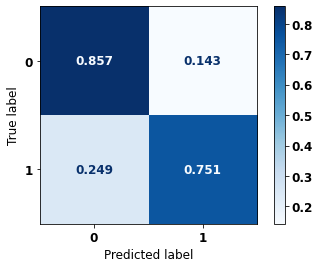


              precision    recall  f1-score   support

           0      0.648     0.857     0.738       510
           1      0.907     0.751     0.822       953

    accuracy                          0.788      1463
   macro avg      0.778     0.804     0.780      1463
weighted avg      0.817     0.788     0.793      1463



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

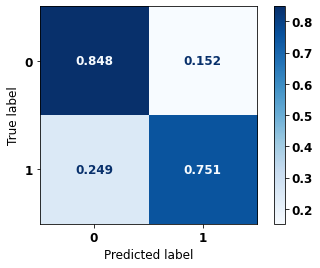


              precision    recall  f1-score   support

           0      0.616     0.848     0.713       571
           1      0.913     0.751     0.824      1211

    accuracy                          0.782      1782
   macro avg      0.764     0.799     0.769      1782
weighted avg      0.818     0.782     0.788      1782



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

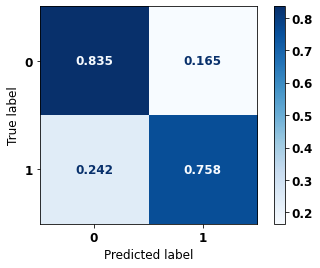


              precision    recall  f1-score   support

           0      0.808     0.835     0.821       539
           1      0.790     0.758     0.774       442

    accuracy                          0.800       981
   macro avg      0.799     0.796     0.797       981
weighted avg      0.800     0.800     0.800       981



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

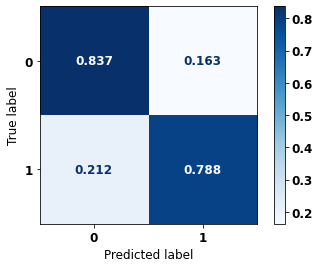


              precision    recall  f1-score   support

           0      0.693     0.837     0.759       443
           1      0.895     0.788     0.838       775

    accuracy                          0.806      1218
   macro avg      0.794     0.813     0.798      1218
weighted avg      0.821     0.806     0.809      1218



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

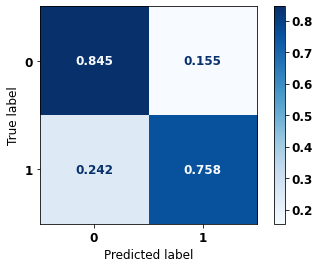


              precision    recall  f1-score   support

           0      0.651     0.845     0.735       510
           1      0.901     0.758     0.823       953

    accuracy                          0.788      1463
   macro avg      0.776     0.801     0.779      1463
weighted avg      0.814     0.788     0.793      1463



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

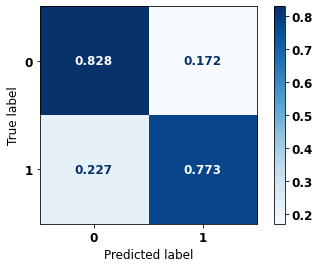


              precision    recall  f1-score   support

           0      0.632     0.828     0.717       571
           1      0.905     0.773     0.834      1211

    accuracy                          0.791      1782
   macro avg      0.769     0.801     0.776      1782
weighted avg      0.818     0.791     0.796      1782



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

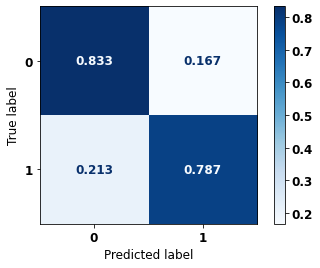


              precision    recall  f1-score   support

           0      0.827     0.833     0.830       539
           1      0.795     0.787     0.791       442

    accuracy                          0.812       981
   macro avg      0.811     0.810     0.810       981
weighted avg      0.812     0.812     0.812       981



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

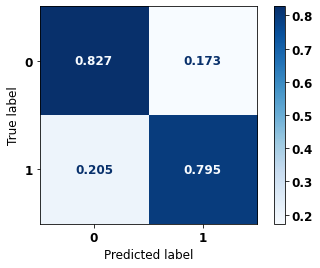


              precision    recall  f1-score   support

           0      0.684     0.827     0.749       510
           1      0.896     0.795     0.843       953

    accuracy                          0.807      1463
   macro avg      0.790     0.811     0.796      1463
weighted avg      0.822     0.807     0.810      1463



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

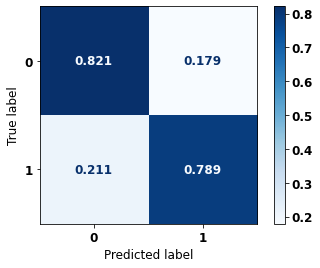


              precision    recall  f1-score   support

           0      0.647     0.821     0.724       571
           1      0.904     0.789     0.842      1211

    accuracy                          0.799      1782
   macro avg      0.775     0.805     0.783      1782
weighted avg      0.821     0.799     0.804      1782



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

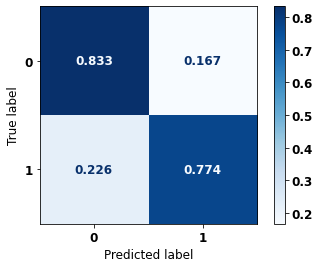


              precision    recall  f1-score   support

           0      0.818     0.833     0.825       539
           1      0.792     0.774     0.783       442

    accuracy                          0.806       981
   macro avg      0.805     0.803     0.804       981
weighted avg      0.806     0.806     0.806       981



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

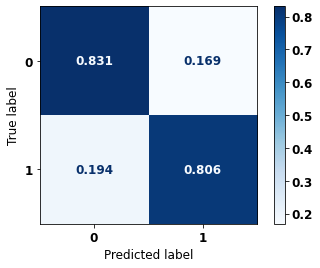


              precision    recall  f1-score   support

           0      0.696     0.831     0.758       510
           1      0.899     0.806     0.850       953

    accuracy                          0.815      1463
   macro avg      0.798     0.819     0.804      1463
weighted avg      0.829     0.815     0.818      1463



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

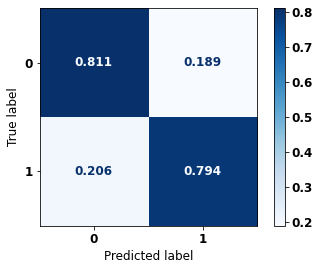


              precision    recall  f1-score   support

           0      0.649     0.811     0.721       571
           1      0.899     0.794     0.843      1211

    accuracy                          0.799      1782
   macro avg      0.774     0.802     0.782      1782
weighted avg      0.819     0.799     0.804      1782



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

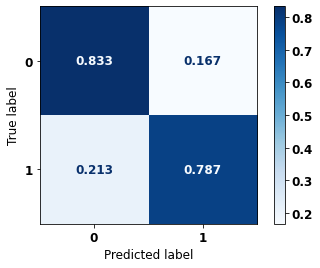


              precision    recall  f1-score   support

           0      0.827     0.833     0.830       539
           1      0.795     0.787     0.791       442

    accuracy                          0.812       981
   macro avg      0.811     0.810     0.810       981
weighted avg      0.812     0.812     0.812       981



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

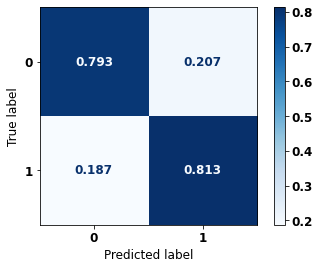


              precision    recall  f1-score   support

           0      0.666     0.793     0.724       571
           1      0.893     0.813     0.851      1211

    accuracy                          0.806      1782
   macro avg      0.780     0.803     0.788      1782
weighted avg      0.820     0.806     0.810      1782



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

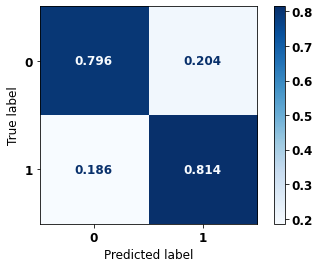


              precision    recall  f1-score   support

           0      0.840     0.796     0.817       539
           1      0.766     0.814     0.789       442

    accuracy                          0.804       981
   macro avg      0.803     0.805     0.803       981
weighted avg      0.806     0.804     0.805       981



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

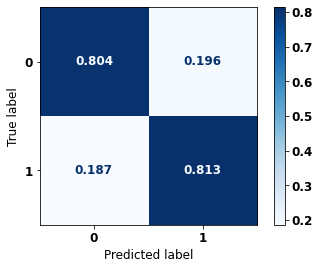


              precision    recall  f1-score   support

           0      0.670     0.804     0.731       571
           1      0.898     0.813     0.854      1211

    accuracy                          0.810      1782
   macro avg      0.784     0.809     0.792      1782
weighted avg      0.825     0.810     0.814      1782



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

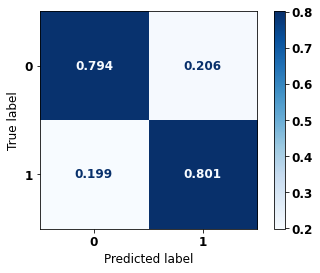


              precision    recall  f1-score   support

           0      0.829     0.794     0.811       539
           1      0.761     0.801     0.781       442

    accuracy                          0.797       981
   macro avg      0.795     0.797     0.796       981
weighted avg      0.799     0.797     0.798       981



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

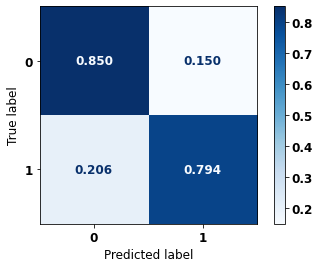


              precision    recall  f1-score   support

           0      0.834     0.850     0.842       539
           1      0.812     0.794     0.803       442

    accuracy                          0.825       981
   macro avg      0.823     0.822     0.823       981
weighted avg      0.824     0.825     0.824       981



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

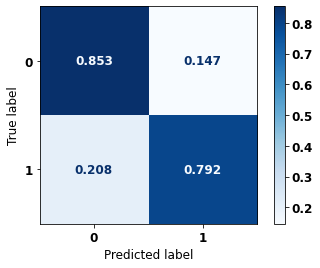


              precision    recall  f1-score   support

           0      0.833     0.853     0.843       539
           1      0.816     0.792     0.804       442

    accuracy                          0.826       981
   macro avg      0.825     0.823     0.823       981
weighted avg      0.825     0.826     0.825       981



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)